<a href="https://colab.research.google.com/github/jjj5306/ComputerVisionClass/blob/main/%5BCV%5DAssignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3
## 0. 공통 실험 설정
다음 요소들을 포함함.
- 데이터셋 로드
- 뉴런 활성화 값과 gradient 흐름 시각화
- Loss, Accuracy 그래프 시각화
- 수렴 속도 측정을 위한 수렴 지점 측정 코드
- base model 구조 정의 클래스


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import os
import time

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # 정규화만 적용
])

# Fashion-MNIST 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 뉴런 활성화값과 graident 저장을 위한 클래스
class ActivationGradientHook:
    def __init__(self):
        self.activations = {}
        self.gradients = {}
        self.hooks = []

    def register_hooks(self, model):
        # 모든 ReLU 레이어에 훅 등록
        for name, module in model.named_modules():
            if isinstance(module, (nn.ReLU, nn.LeakyReLU, nn.Sigmoid)):
              # 순전파 훅
              self.hooks.append(
                  module.register_forward_hook(
                      lambda m, inp, outp, name=name: self.save_activation(name, outp)
                  )
              )
              # 역전파 훅
              self.hooks.append(
                  module.register_full_backward_hook(
                      lambda m, grad_inp, grad_outp, name=name: self.save_gradient(name, grad_inp[0])
                  )
              )

    def save_activation(self, name, activation):
        self.activations[name] = activation.detach().cpu()

    def save_gradient(self, name, gradient):
        self.gradients[name] = gradient.detach().cpu()

    def clear(self):
        self.activations = {}
        self.gradients = {}

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[256, 128], num_classes=10):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # input -> layer1
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.activations.append(nn.ReLU())

        # layer 1 -> layer 2
        self.layers.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))
        self.activations.append(nn.ReLU())

        # layer 2 -> 최종 출력 층
        self.layers.append(nn.Linear(hidden_sizes[1], num_classes))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten

        # 순전파
        layer_outputs = []
        activation_outputs = []

        for i, (layer, activation) in enumerate(zip(self.layers[:-1], self.activations)):
            x = layer(x)
            layer_outputs.append(x)
            x = activation(x)
            activation_outputs.append(x)

        # 출력층
        x = self.layers[-1](x)
        layer_outputs.append(x)

        return x, layer_outputs, activation_outputs

# visualization
# 개별 그래프 시각화
def plot_learning_curves(train_losses, test_losses, train_accs, test_accs, title_suffix="", save_dir="results/learning_curves"):
    save_dir=os.path.join(save_dir, "learning_curves")
    # 디렉토리 없으면 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Loss vs Epoch {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title(f'Accuracy vs Epoch {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'learning_curves{title_suffix.replace(" ", "_")}.png'))
    plt.show()

# 활성화 히트맵 시각화
def plot_activation_heatmap(activation_history, title_suffix="", save_dir="results"):
    # 초, 중, 후반의 에포크에 대한 모든 layer의 activation heatmap 출력
    save_dir = os.path.join(save_dir, "activation")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 모든 에포크 가져오기
    all_epochs = sorted(list(activation_history.keys()))
    layers = list(activation_history[all_epochs[0]].keys())

    # 에포크 샘플링: 첫 두 개, 중간 두 개, 마지막 두 개
    sampled_epochs = []

    if len(all_epochs) <= 6:
        # 6개 이하면 모두 사용
        sampled_epochs = all_epochs
    else:
        # 첫 두 개
        sampled_epochs.extend(all_epochs[:2])

        # 중간 두 개
        mid_idx = len(all_epochs) // 2
        sampled_epochs.extend(all_epochs[mid_idx-1:mid_idx+1])

        # 마지막 두 개
        sampled_epochs.extend(all_epochs[-2:])

    # 모든 활성화 데이터의 최대값 찾기 (공통 스케일 사용)
    max_val = float('-inf')
    for epoch in all_epochs:  # 모든 에포크에서 최대값 찾기 (일관된 스케일링을 위해)
        for layer in layers:
            act_data = activation_history[epoch][layer]
            avg_act = np.mean(act_data, axis=0)
            max_val = max(max_val, np.max(avg_act))

    # 한 행에 2개의 에포크씩 표시, 필요한 행 수 계산
    num_rows = (len(sampled_epochs) + 1) // 2

    # 가로로 2개의 에포크, 각 에포크마다 모든 레이어 표시
    num_cols = len(layers) * 2

    # 그림 크기 설정
    fig_width = min(20, max(12, num_cols * 3))  # 열 수에 비례하여 너비 조정
    fig_height = num_rows * 3.5  # 행 수에 비례하여 높이 조정

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    # 단일 행인 경우 2D 배열로 변환
    if num_rows == 1:
        axes = np.array([axes]).reshape(1, -1)

    # 모든 서브플롯 초기화 (사용하지 않는 서브플롯 제거를 위해)
    for ax in axes.flatten():
        ax.axis('off')

    # 각 행에 대해 처리
    for row in range(num_rows):
        # 현재 행의 에포크 인덱스 계산
        start_idx = row * 2
        end_idx = min(start_idx + 2, len(sampled_epochs))

        # 현재 행의 에포크
        current_epochs = sampled_epochs[start_idx:end_idx]

        for i, epoch in enumerate(current_epochs):
            # 현재 에포크의 열 오프셋 계산
            col_offset = i * len(layers)

            for layer_idx, layer in enumerate(layers):
                # 현재 층의 열 인덱스 계산
                col = col_offset + layer_idx

                # 서브플롯 활성화
                ax = axes[row, col]
                ax.axis('on')

                # 활성화 데이터 가져오기
                activations = activation_history[epoch][layer]
                batch_size, num_neurons = activations.shape

                # 배치의 평균 활성화 계산
                avg_activations = np.mean(activations, axis=0)
                avg_activations = avg_activations.reshape(1, -1)

                # 히트맵 표시
                im = ax.imshow(avg_activations, aspect='auto', cmap='viridis', vmin=0, vmax=max_val)

                # 제목 설정
                ax.set_title(f'Epoch {epoch} Layer {layer_idx+1}', fontsize=10)

                # X축 라벨은 마지막 행에만 표시
                if row == num_rows - 1:
                    ax.set_xlabel('Neuron Index', fontsize=9)
                else:
                    ax.set_xticklabels([])

                # Y축 라벨은 각 에포크의 첫 번째 레이어에만 표시
                if layer_idx == 0:
                    ax.set_ylabel('Batch Avg', fontsize=9)
                else:
                    ax.set_yticklabels([])

                # X축 눈금 설정 (적절한 간격으로)
                if num_neurons > 30:
                    tick_interval = max(1, num_neurons // 5)
                    ax.set_xticks(np.arange(0, num_neurons, tick_interval))

                # Dead ReLU 비율 계산 및 표시
                dead_ratio = np.mean(activations == 0) * 100
                ax.text(0.02, 0.9, f'Dead: {dead_ratio:.1f}%',
                        transform=ax.transAxes, color='red', fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.7),
                        verticalalignment='top')

    # 공통 컬러바 추가
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Activation Value', fontsize=10)

    plt.suptitle(f'Activation Values {title_suffix}', fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.92, 0.95])

    plt.savefig(os.path.join(save_dir, f'activation_heatmap{title_suffix.replace(" ", "_")}.png'), dpi=150)
    plt.show()

# 그래디언트 히트맵 시각화
def plot_gradient_flow_heatmap(gradient_history, title_suffix="", save_dir="results/gradient", max_epochs_to_show=10):
    save_dir = os.path.join(save_dir, "gradient")
    # 디렉토리 없으면 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 각 레이어의 그래디언트 크기를 히트맵으로 시각화 -> 그래디언트 흐름
    epochs = sorted(list(gradient_history.keys()))
    layers = list(gradient_history[epochs[0]].keys())

    # 에포크 샘플링 : 초중후반에서 균등하게 선택
    sampled_epochs = []
    total_epochs = len(epochs)

    if total_epochs <= max_epochs_to_show:
        # 에포크 수가 max_epochs_to_show 이하면 모두 사용
        sampled_epochs = epochs
    else:
        # 초반, 중반, 후반에서 균등하게 샘플링
        # 초반 (약 30%)
        early_count = max_epochs_to_show // 3
        early_indices = np.linspace(0, total_epochs // 3 - 1, early_count, dtype=int)

        # 중반 (약 40%)
        mid_count = max_epochs_to_show // 3 + (max_epochs_to_show % 3 > 0)
        mid_start = total_epochs // 3
        mid_end = 2 * total_epochs // 3
        mid_indices = np.linspace(mid_start, mid_end - 1, mid_count, dtype=int)

        # 후반 (약 30%)
        late_count = max_epochs_to_show - early_count - mid_count
        late_start = 2 * total_epochs // 3
        late_indices = np.linspace(late_start, total_epochs - 1, late_count, dtype=int)

        # 인덱스를 사용하여 에포크 번호 추출
        for idx in np.concatenate([early_indices, mid_indices, late_indices]):
            sampled_epochs.append(epochs[idx])

    # 그래디언트 크기 데이터 준비
    grad_flow_data = np.zeros((len(sampled_epochs), len(layers)))

    for i, epoch in enumerate(sampled_epochs):
        for j, layer in enumerate(layers):
            # 각 레이어의 그래디언트 절대값 평균
            grad_flow_data[i, j] = np.abs(gradient_history[epoch][layer]).mean()

    # 가로로 표시하기 위해 전치(transpose)
    grad_flow_data = grad_flow_data.T

    plt.figure(figsize=(12, max(6, len(layers)/2)))  # 레이어 수에 따라 세로 크기 조정
    im = plt.imshow(grad_flow_data, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Gradient Magnitude')

    # Y축: 레이어 레이블
    plt.yticks(range(len(layers)), layers)

    # X축: 에포크 레이블 (10개 이하면 모두 표시, 그 이상이면 간격을 두고 표시)
    plt.xticks(range(len(sampled_epochs)), [f'Epoch {e}' for e in sampled_epochs], rotation=45)

    plt.title(f'Gradient Flow Heatmap {title_suffix}')
    plt.ylabel('Layer')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'gradient_flow_heatmap{title_suffix.replace(" ", "_")}.png'))
    plt.show()

    return sampled_epochs

def detect_convergence(losses, window=10, rel_threshold=0.01):
    if len(losses) <= window * 2:
        return len(losses) - 1

    # 이동 평균 계산
    smoothed_losses = []
    for i in range(len(losses) - window + 1):
        smoothed_losses.append(sum(losses[i:i+window]) / window)

    # 이동 평균으로 수렴 판단
    for i in range(window, len(smoothed_losses) - window):
        current_window = smoothed_losses[i:i+window]
        avg_loss = sum(current_window) / len(current_window)

        # 상대적 변화율 계산
        if avg_loss < 1e-6:  # 매우 작은 값이면 절대 변화량 사용
            change = max(current_window) - min(current_window)
        else:
            change = (max(current_window) - min(current_window)) / avg_loss

        if change < rel_threshold:
            return i + window  # 수렴 판단

    # 마지막 구간에서의 진동 확인
    final_window = smoothed_losses[-window:]
    avg_loss = sum(final_window) / len(final_window)

    if avg_loss < 1e-6:
        final_change = max(final_window) - min(final_window)
    else:
        final_change = (max(final_window) - min(final_window)) / avg_loss

    # 마지막 구간이 임계값의 1.5배 이내로 변동이면 수렴으로 판단
    if final_change < rel_threshold * 1.5:
        return len(smoothed_losses) - window // 2

    return len(losses) - 1  # 수렴하지 않음

Using cpu device


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.39MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.49MB/s]


# 1. Experiment A - 손실 함수 비교


===== 실험 A: 손실 함수 비교 (CrossEntropy vs MSE) =====


--- A-1: CrossEntropy Loss Experiment ---

Epoch [1/35], Train Loss: 0.4931, Test Loss: 0.4208, Train Acc: 0.8189, Test Acc: 0.8496
Epoch [2/35], Train Loss: 0.3691, Test Loss: 0.4024, Train Acc: 0.8637, Test Acc: 0.8499
Epoch [3/35], Train Loss: 0.3316, Test Loss: 0.3620, Train Acc: 0.8782, Test Acc: 0.8674
Epoch [4/35], Train Loss: 0.3047, Test Loss: 0.3509, Train Acc: 0.8877, Test Acc: 0.8733
Epoch [5/35], Train Loss: 0.2873, Test Loss: 0.3497, Train Acc: 0.8932, Test Acc: 0.8727
Epoch [6/35], Train Loss: 0.2689, Test Loss: 0.3929, Train Acc: 0.8998, Test Acc: 0.8662
Epoch [7/35], Train Loss: 0.2558, Test Loss: 0.3319, Train Acc: 0.9039, Test Acc: 0.8839
Epoch [8/35], Train Loss: 0.2430, Test Loss: 0.3293, Train Acc: 0.9080, Test Acc: 0.8836
Epoch [9/35], Train Loss: 0.2327, Test Loss: 0.3323, Train Acc: 0.9122, Test Acc: 0.8837
Epoch [10/35], Train Loss: 0.2184, Test Loss: 0.3594, Train Acc: 0.9171, Test Acc: 0.8805
Epoch [11/35],

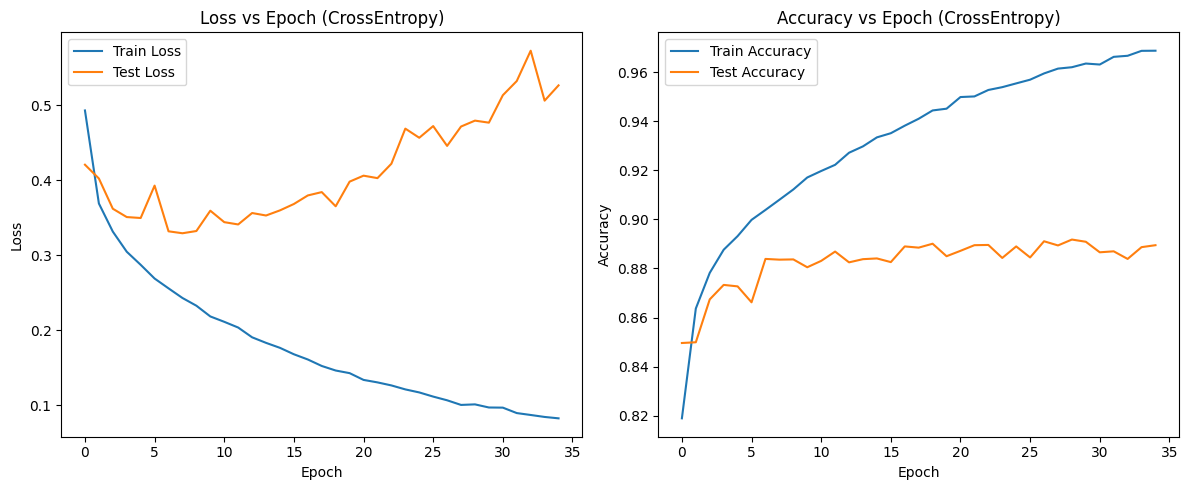

<ipython-input-15-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


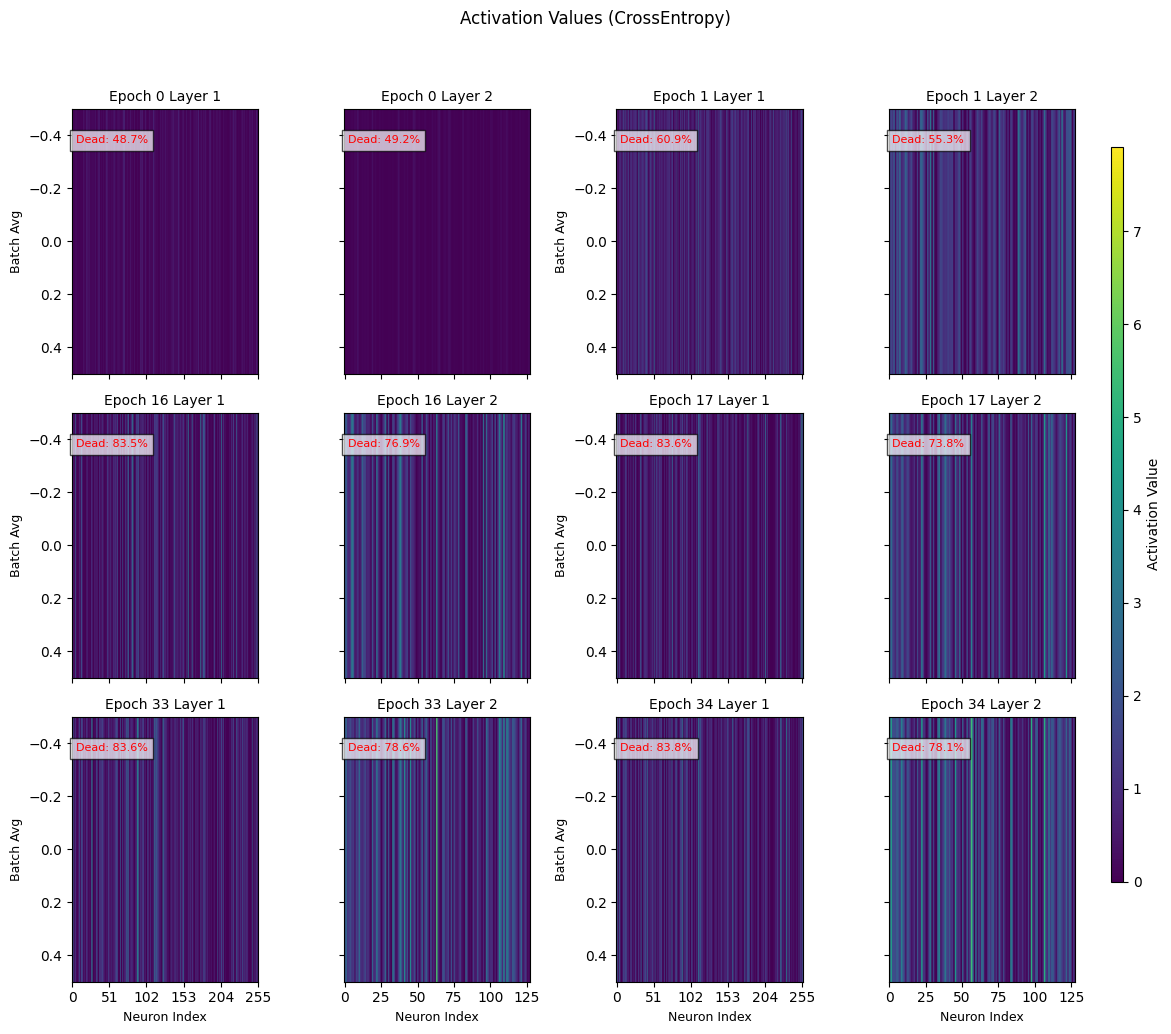

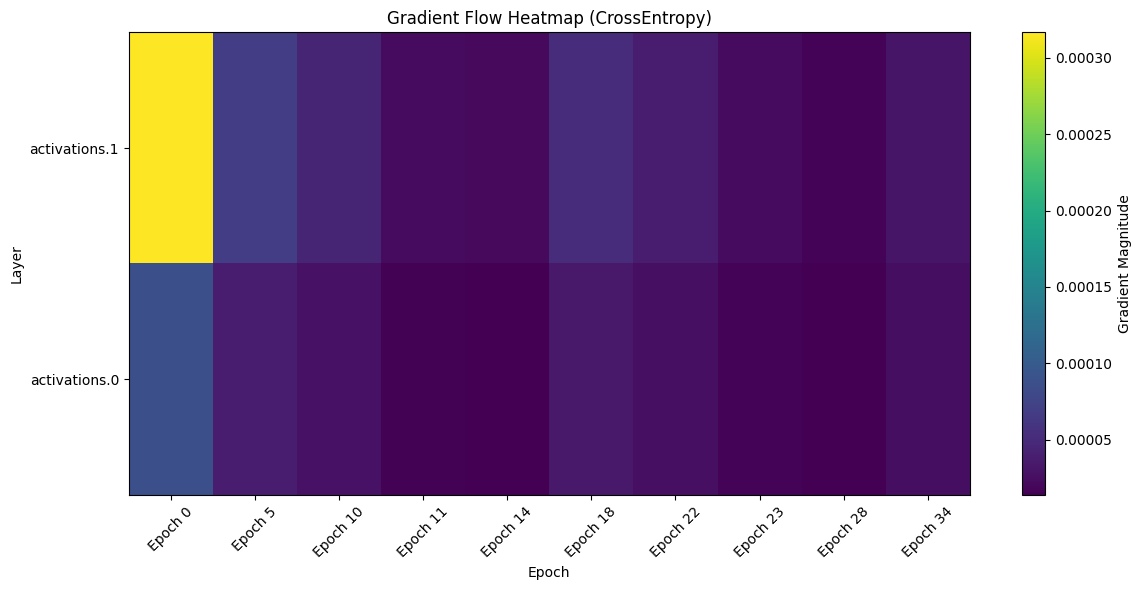


--- A-2: MSE Loss (with softmax) Experiment ---

Epoch [1/35], Train Loss: 0.0259, Test Loss: 0.0231, Train Acc: 0.8165, Test Acc: 0.8389
Epoch [2/35], Train Loss: 0.0199, Test Loss: 0.0205, Train Acc: 0.8619, Test Acc: 0.8541
Epoch [3/35], Train Loss: 0.0182, Test Loss: 0.0199, Train Acc: 0.8743, Test Acc: 0.8631
Epoch [4/35], Train Loss: 0.0171, Test Loss: 0.0194, Train Acc: 0.8819, Test Acc: 0.8647
Epoch [5/35], Train Loss: 0.0161, Test Loss: 0.0185, Train Acc: 0.8899, Test Acc: 0.8747
Epoch [6/35], Train Loss: 0.0152, Test Loss: 0.0184, Train Acc: 0.8961, Test Acc: 0.8731
Epoch [7/35], Train Loss: 0.0147, Test Loss: 0.0181, Train Acc: 0.8995, Test Acc: 0.8755
Epoch [8/35], Train Loss: 0.0142, Test Loss: 0.0182, Train Acc: 0.9039, Test Acc: 0.8738
Epoch [9/35], Train Loss: 0.0135, Test Loss: 0.0174, Train Acc: 0.9086, Test Acc: 0.8819
Epoch [10/35], Train Loss: 0.0131, Test Loss: 0.0171, Train Acc: 0.9115, Test Acc: 0.8818
Epoch [11/35], Train Loss: 0.0127, Test Loss: 0.0168, Train

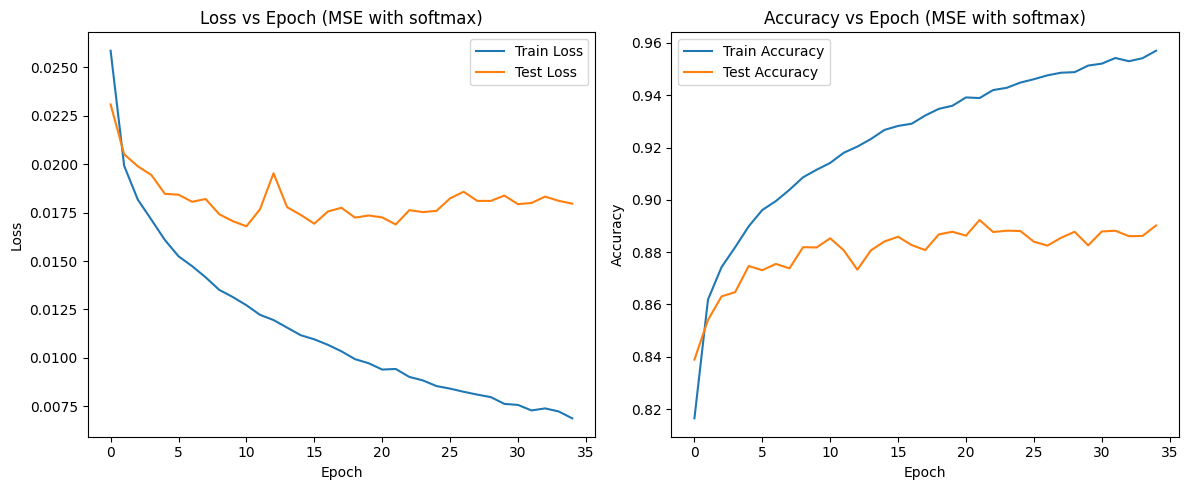

<ipython-input-15-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


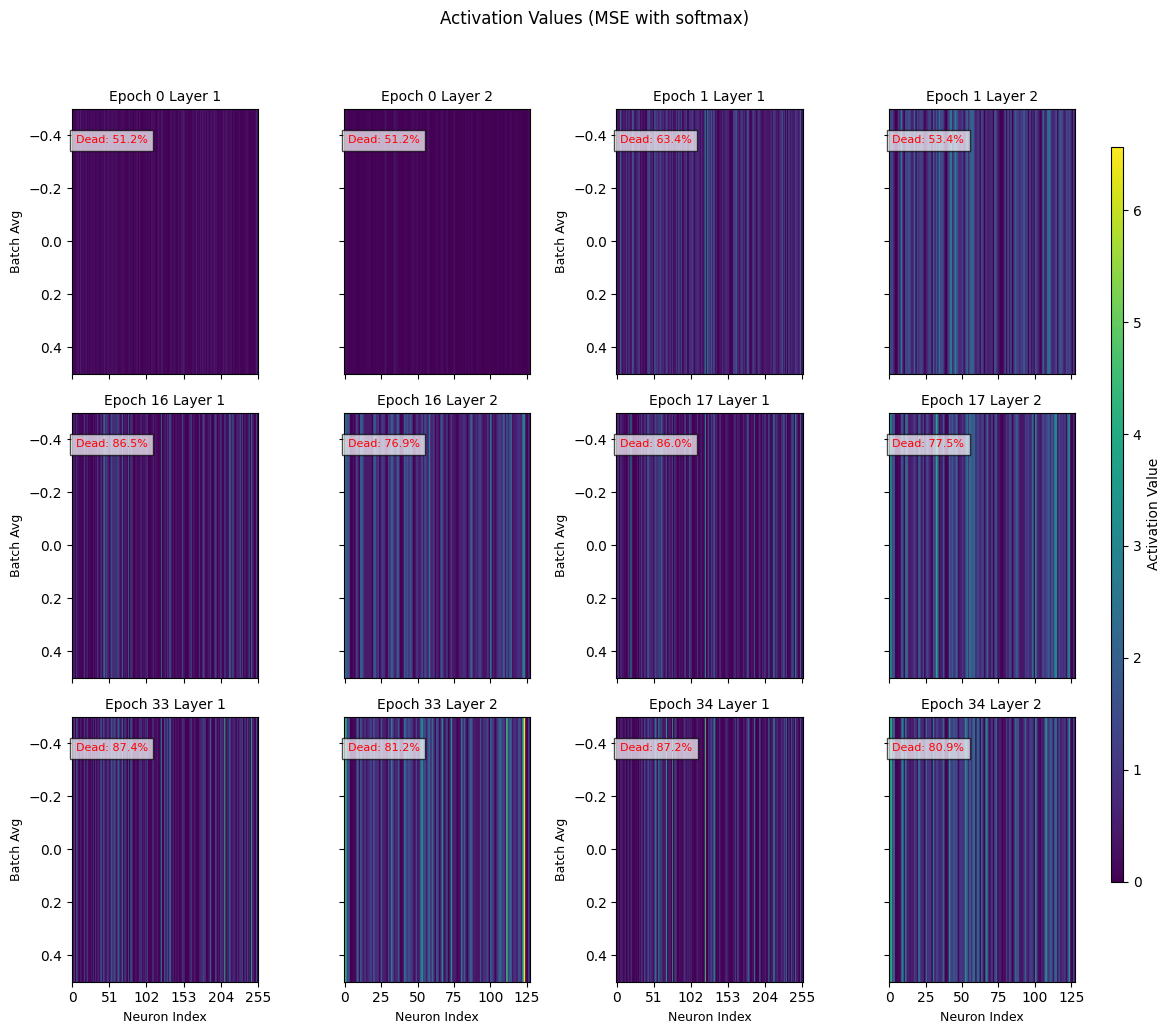

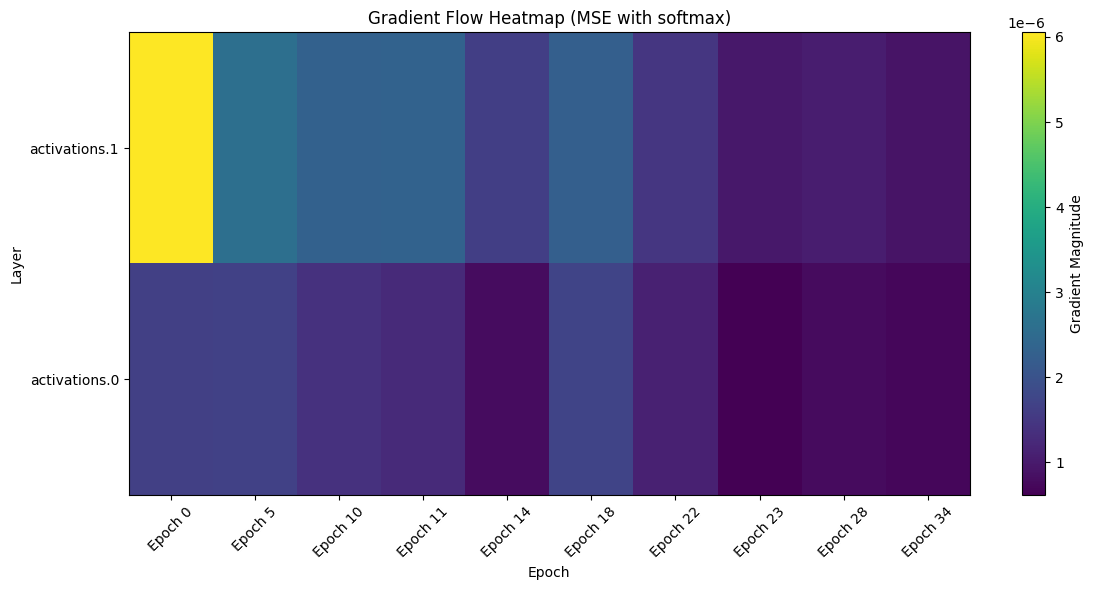

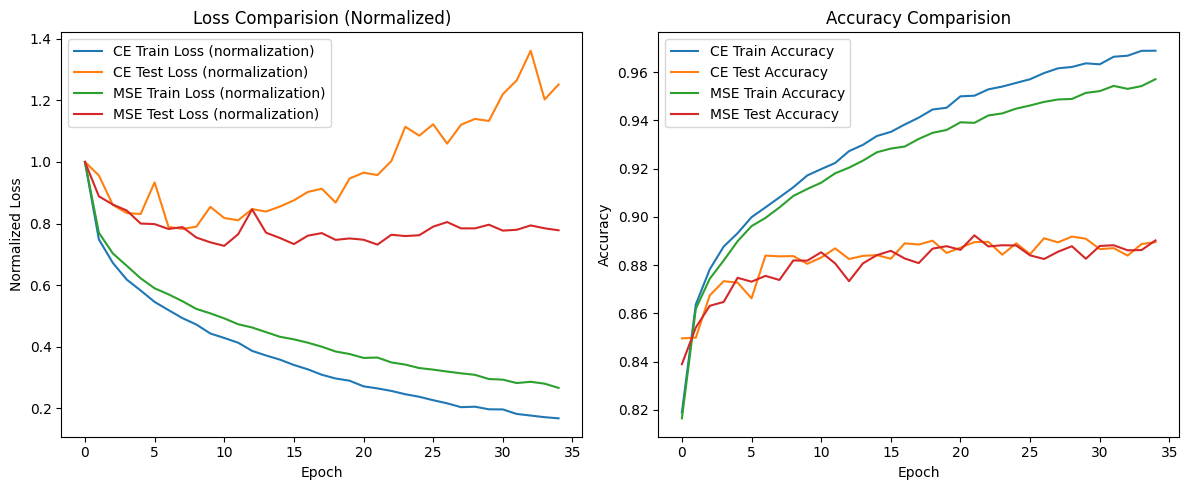

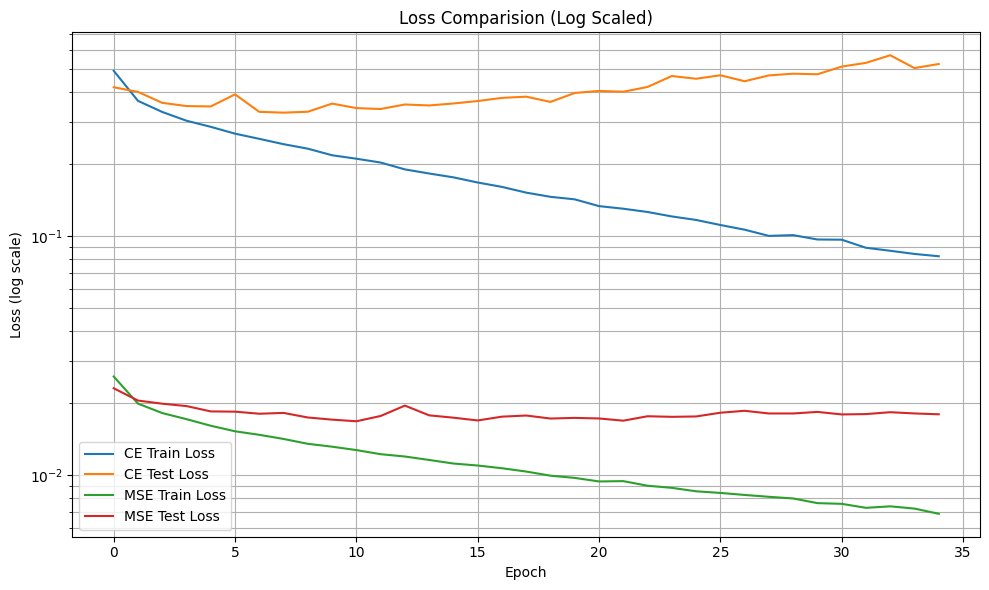

CrossEntropy 수렴 에폭: 34
MSE 수렴 에폭: 34
상대적 수렴 속도: 동일

CrossEntropy 최종 학습 정확도: 0.9688
MSE 최종 학습 정확도: 0.9570
CrossEntropy 최종 테스트 정확도: 0.8895
MSE 최종 테스트 정확도: 0.8902


In [ ]:
# 비교 시각화 함수
def plot_comparison(ce_results, mse_results, save_dir="results/comparison"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    ce_train_losses, ce_test_losses, ce_train_accs, ce_test_accs = ce_results[:4]
    mse_train_losses, mse_test_losses, mse_train_accs, mse_test_accs = mse_results[:4]

    # 1. 정규화된 손실 비교
    plt.figure(figsize=(12, 5))

    # 정규화된 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot([loss/ce_train_losses[0] for loss in ce_train_losses], label='CE Train Loss (normalization)')
    plt.plot([loss/ce_test_losses[0] for loss in ce_test_losses], label='CE Test Loss (normalization)')
    plt.plot([loss/mse_train_losses[0] for loss in mse_train_losses], label='MSE Train Loss (normalization)')
    plt.plot([loss/mse_test_losses[0] for loss in mse_test_losses], label='MSE Test Loss (normalization)')
    plt.title('Loss Comparision (Normalized)')
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(ce_train_accs, label='CE Train Accuracy')
    plt.plot(ce_test_accs, label='CE Test Accuracy')
    plt.plot(mse_train_accs, label='MSE Train Accuracy')
    plt.plot(mse_test_accs, label='MSE Test Accuracy')
    plt.title('Accuracy Comparision')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'normalized_comparison.png'))
    plt.show()

    # 2. 로그 스케일 손실 비교
    plt.figure(figsize=(10, 6))
    plt.semilogy(ce_train_losses, label='CE Train Loss')
    plt.semilogy(ce_test_losses, label='CE Test Loss')
    plt.semilogy(mse_train_losses, label='MSE Train Loss')
    plt.semilogy(mse_test_losses, label='MSE Test Loss')
    plt.title('Loss Comparision (Log Scaled)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'log_scale_comparison.png'))
    plt.show()

    # 3. 수렴 분석
    ce_convergence = detect_convergence(ce_test_losses)
    mse_convergence = detect_convergence(mse_test_losses)

    # 결과 출력
    print(f"CrossEntropy 수렴 에폭: {ce_convergence}")
    print(f"MSE 수렴 에폭: {mse_convergence}")
    print(f"상대적 수렴 속도: {'CrossEntropy가 더 빠름' if ce_convergence < mse_convergence else 'MSE가 더 빠름' if mse_convergence < ce_convergence else '동일'}")

    print(f"\nCrossEntropy 최종 학습 정확도: {ce_train_accs[-1]:.4f}")
    print(f"MSE 최종 학습 정확도: {mse_train_accs[-1]:.4f}")
    print(f"CrossEntropy 최종 테스트 정확도: {ce_test_accs[-1]:.4f}")
    print(f"MSE 최종 테스트 정확도: {mse_test_accs[-1]:.4f}")

    # 파일에 결과 저장
    with open(os.path.join(save_dir, 'comparison_results.txt'), 'w') as f:
        f.write(f"CrossEntropy 수렴 에폭: {ce_convergence}\n")
        f.write(f"MSE 수렴 에폭: {mse_convergence}\n")
        f.write(f"상대적 수렴 속도: {'CrossEntropy가 더 빠름' if ce_convergence < mse_convergence else 'MSE가 더 빠름' if mse_convergence < ce_convergence else '동일'}\n\n")

        f.write(f"CrossEntropy 최종 학습 정확도: {ce_train_accs[-1]:.4f}\n")
        f.write(f"MSE 최종 학습 정확도: {mse_train_accs[-1]:.4f}\n")
        f.write(f"CrossEntropy 최종 테스트 정확도: {ce_test_accs[-1]:.4f}\n")
        f.write(f"MSE 최종 테스트 정확도: {mse_test_accs[-1]:.4f}\n\n")

    return ce_convergence, mse_convergence

# CrossEntropy Loss 학습 함수
def train_model_CE(model, train_loader, test_loader, criterion, optimizer, num_epochs=30):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    # 활성화값과 그래디언트 훅 등록
    act_grad_hook = ActivationGradientHook()
    act_grad_hook.register_hooks(model)

    # 각 에폭별 활성화값과 그래디언트 저장용
    activation_history = {epoch: {} for epoch in range(num_epochs)}
    gradient_history = {epoch: {} for epoch in range(num_epochs)}
    dead_relu_history = {epoch: {} for epoch in range(num_epochs)}

    for epoch in range(num_epochs):
        # 학습
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, layer_outputs, activation_outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # 자동 미분 사용
            optimizer.step() # optimizer

            train_loss += loss.item() # loss 계산
            _, predicted = torch.max(outputs.data, 1) # 최대값 인덱스 -> y^ (예측한 클래스)
            train_preds.extend(predicted.cpu().numpy()) # y^ -> numpy
            train_labels.extend(labels.cpu().numpy()) # y -> numpy

            # 활성화값, 그래디언트 저장. 메모리 한계와 미니 배치의 특성상 첫 번째 배치에서만 저장하도록 구성
            if batch_idx == 0:
                # 활성화값 저장
                for i, act in enumerate(activation_outputs):
                    activation_history[epoch][f'layer_{i+1}'] = act.detach().cpu().numpy()
                    # Dead ReLU 계산, 0인 비율을 계산하면 됨
                    dead_relu_history[epoch][f'layer_{i+1}'] = (act == 0).float().mean().item()

                # 그래디언트
                for name, gradient in act_grad_hook.gradients.items():
                    gradient_history[epoch][name] = gradient.numpy()

                # 메모리 정리용
                act_grad_hook.clear()

        # model.eval 사용
        model.eval()
        test_loss = 0
        test_preds = []
        test_labels = []

        with torch.no_grad(): # gradient 계산 X
            for inputs, labels in test_loader: # 테스트 데이터 로드
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _, _ = model(inputs) # 예측값 계산
                loss = criterion(outputs, labels) # loss 계산
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1) # 예측 결과
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # 결과 계산
        train_loss = train_loss / len(train_loader)
        test_loss = test_loss / len(test_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        test_acc = accuracy_score(test_labels, test_preds)

        # 결과 저장
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Test Acc: {test_acc:.4f}')

    # 훅 제거
    act_grad_hook.remove_hooks()

    return train_losses, test_losses, train_accs, test_accs, activation_history, gradient_history, dead_relu_history

# MSE Loss 학습 함수
def train_model_MSE(model, train_loader, test_loader, criterion, optimizer, num_epochs=30):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    # 활성화값과 그래디언트 훅 등록
    act_grad_hook = ActivationGradientHook()
    act_grad_hook.register_hooks(model)

    # 각 에폭별 활성화값과 그래디언트 저장용
    activation_history = {epoch: {} for epoch in range(num_epochs)}
    gradient_history = {epoch: {} for epoch in range(num_epochs)}
    dead_relu_history = {epoch: {} for epoch in range(num_epochs)}

    for epoch in range(num_epochs):
        # 학습
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 원-핫 인코딩으로 변환 (MSE Loss 사용시 필요)
            labels_one_hot = torch.zeros(labels.size(0), 10).to(device)  # Fashion-MNIST는 10개 클래스
            labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

            optimizer.zero_grad()
            outputs, layer_outputs, activation_outputs = model(inputs)

            # MSE Loss 사용시 softmax 적용
            outputs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels_one_hot)  # MSE Loss 계산

            loss.backward()  # 자동 미분 사용
            optimizer.step()  # optimizer

            train_loss += loss.item()  # loss 계산
            _, predicted = torch.max(outputs.data, 1)  # 최대값 인덱스 -> y^ (예측한 클래스)
            train_preds.extend(predicted.cpu().numpy())  # y^ -> numpy
            train_labels.extend(labels.cpu().numpy())  # y -> numpy

            # 활성화값, 그래디언트 저장. 메모리 한계와 미니 배치의 특성상 첫 번째 배치에서만 저장하도록 구성
            if batch_idx == 0:
                # 활성화값 저장
                for i, act in enumerate(activation_outputs):
                    activation_history[epoch][f'layer_{i+1}'] = act.detach().cpu().numpy()
                    # Dead ReLU 계산, 0인 비율을 계산하면 됨
                    dead_relu_history[epoch][f'layer_{i+1}'] = (act == 0).float().mean().item()

                # 그래디언트
                for name, gradient in act_grad_hook.gradients.items():
                    gradient_history[epoch][name] = gradient.numpy()

                # 메모리 정리용
                act_grad_hook.clear()

        # model.eval 사용
        model.eval()
        test_loss = 0
        test_preds = []
        test_labels = []

        with torch.no_grad():  # gradient 계산 X
            for inputs, labels in test_loader:  # 테스트 데이터 로드
                inputs, labels = inputs.to(device), labels.to(device)

                # 원-핫 인코딩으로 변환 (MSE Loss 사용시 필요)
                labels_one_hot = torch.zeros(labels.size(0), 10).to(device)
                labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

                outputs, _, _ = model(inputs)  # 예측값 계산

                # MSE Loss 사용시 softmax 적용
                outputs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels_one_hot)  # MSE Loss 계산

                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)  # 예측 결과
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # 결과 계산
        train_loss = train_loss / len(train_loader)
        test_loss = test_loss / len(test_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        test_acc = accuracy_score(test_labels, test_preds)

        # 결과 저장
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Test Acc: {test_acc:.4f}')

    # 훅 제거
    act_grad_hook.remove_hooks()

    return train_losses, test_losses, train_accs, test_accs, activation_history, gradient_history, dead_relu_history


# 실험 A 메인 함수
def run_experiment_A():
    print("\n===== 실험 A: 손실 함수 비교 (CrossEntropy vs MSE) =====\n")

    # 결과 저장 디렉토리 생성
    if not os.path.exists("expA_results"):
        os.makedirs("expA_results")

    # 1. CrossEntropy Loss 실험
    print("\n--- A-1: CrossEntropy Loss Experiment ---\n")

    # 모델 정의
    ce_model = MLP().to(device)

    # 손실 함수와 옵티마이저 명시적 설정
    ce_loss_fn = nn.CrossEntropyLoss()  # CrossEntropy Loss
    ce_optimizer = optim.Adam(ce_model.parameters(), lr=0.001)  # Adam 옵티마이저, 학습률 0.001

    # 학습 및 결과 수집
    ce_results = train_model_CE(
        model=ce_model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=ce_loss_fn,
        optimizer=ce_optimizer,
        num_epochs=35  # 에폭 수 설정
    )

    # 개별 결과 시각화
    plot_learning_curves(
        ce_results[0], ce_results[1], ce_results[2], ce_results[3],
        title_suffix="(CrossEntropy)",
        save_dir="expA_results/CE"
    )

    plot_activation_heatmap(
        ce_results[4],
        title_suffix="(CrossEntropy)",
        save_dir="expA_results/CE"
    )

    plot_gradient_flow_heatmap(
        ce_results[5],
        title_suffix="(CrossEntropy)",
        save_dir="expA_results/CE"
    )

    # 2. MSE Loss 실험
    print("\n--- A-2: MSE Loss (with softmax) Experiment ---\n")

    # 모델 정의
    mse_model = MLP().to(device)

    # 손실 함수, Otimizer 설정
    mse_loss_fn = nn.MSELoss()  # MSE Loss
    mse_optimizer = optim.Adam(mse_model.parameters(), lr=0.001)  # Adam 옵티마이저, 학습률 0.001

    # 학습 및 결과 수집
    mse_results = train_model_MSE(
        model=mse_model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=mse_loss_fn,
        optimizer=mse_optimizer,
        num_epochs=35
    )

    # 개별 결과 시각화
    plot_learning_curves(
        mse_results[0], mse_results[1], mse_results[2], mse_results[3],
        title_suffix="(MSE with softmax)",
        save_dir="expA_results/MSE"
    )

    plot_activation_heatmap(
        mse_results[4],
        title_suffix="(MSE with softmax)",
        save_dir="expA_results/MSE"
    )

    plot_gradient_flow_heatmap(
        mse_results[5],
        title_suffix="(MSE with softmax)",
        save_dir="expA_results/MSE"
    )

    # 결과 비교 시각화
    plot_comparison(ce_results[:4], mse_results[:4], save_dir="expA_results/comparison")

    return ce_results, mse_results

# 메인 실행 코드
if __name__ == "__main__":
    # 실험 A 실행
    ce_results, mse_results = run_experiment_A()

# 2. Experiment B - 활성화 함수 비교 :  ReLU vs LeakyReLU vs Sigmoid


===== Experiment B: Activation Function Comparison (ReLU vs LeakyReLU vs Sigmoid) =====


--- B-1: ReLU Experiment ---

Epoch [1/350], Train Loss: 0.6938, Test Loss: 0.6905, Train Acc: 0.4981, Test Acc: 0.6600
Epoch [2/350], Train Loss: 0.6846, Test Loss: 0.6802, Train Acc: 0.6406, Test Acc: 0.4925
Epoch [3/350], Train Loss: 0.6553, Test Loss: 0.6350, Train Acc: 0.5025, Test Acc: 0.5150
Epoch [4/350], Train Loss: 0.5787, Test Loss: 0.5360, Train Acc: 0.7300, Test Acc: 0.8125
Epoch [5/350], Train Loss: 0.4843, Test Loss: 0.4593, Train Acc: 0.8150, Test Acc: 0.8325
Epoch [6/350], Train Loss: 0.4139, Test Loss: 0.3894, Train Acc: 0.8294, Test Acc: 0.8600
Epoch [7/350], Train Loss: 0.3498, Test Loss: 0.3369, Train Acc: 0.8500, Test Acc: 0.8800
Epoch [8/350], Train Loss: 0.3133, Test Loss: 0.3136, Train Acc: 0.8581, Test Acc: 0.8775
Epoch [9/350], Train Loss: 0.2968, Test Loss: 0.3068, Train Acc: 0.8681, Test Acc: 0.8875
Epoch [10/350], Train Loss: 0.2895, Test Loss: 0.3028, Train Acc: 0.8

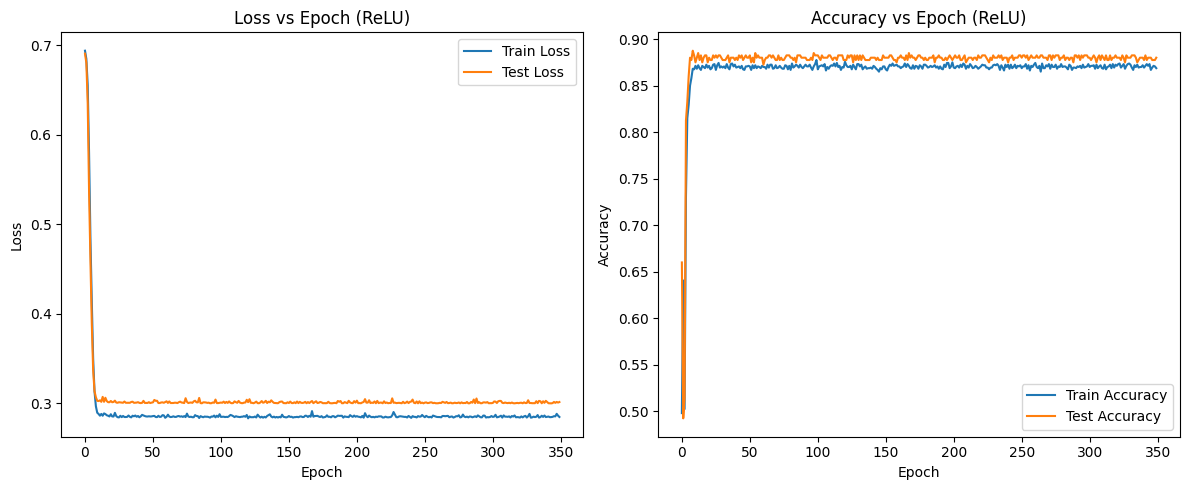

<ipython-input-15-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


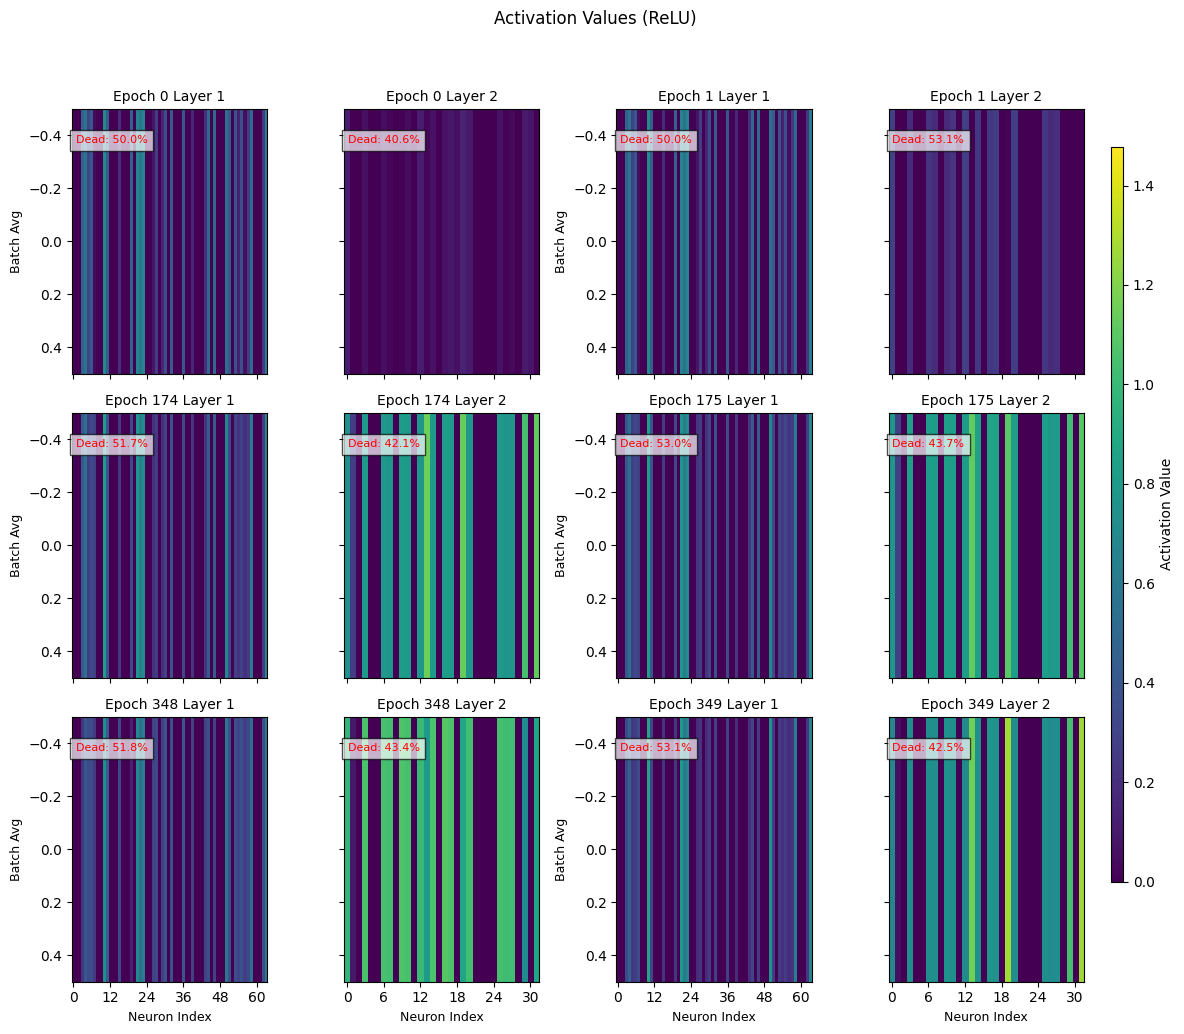

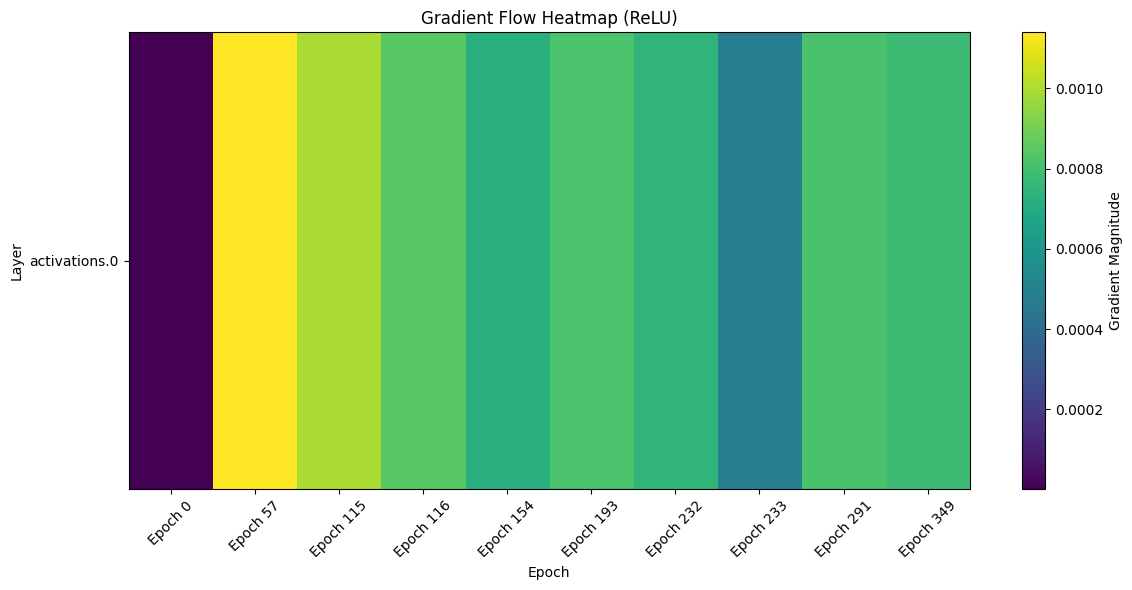

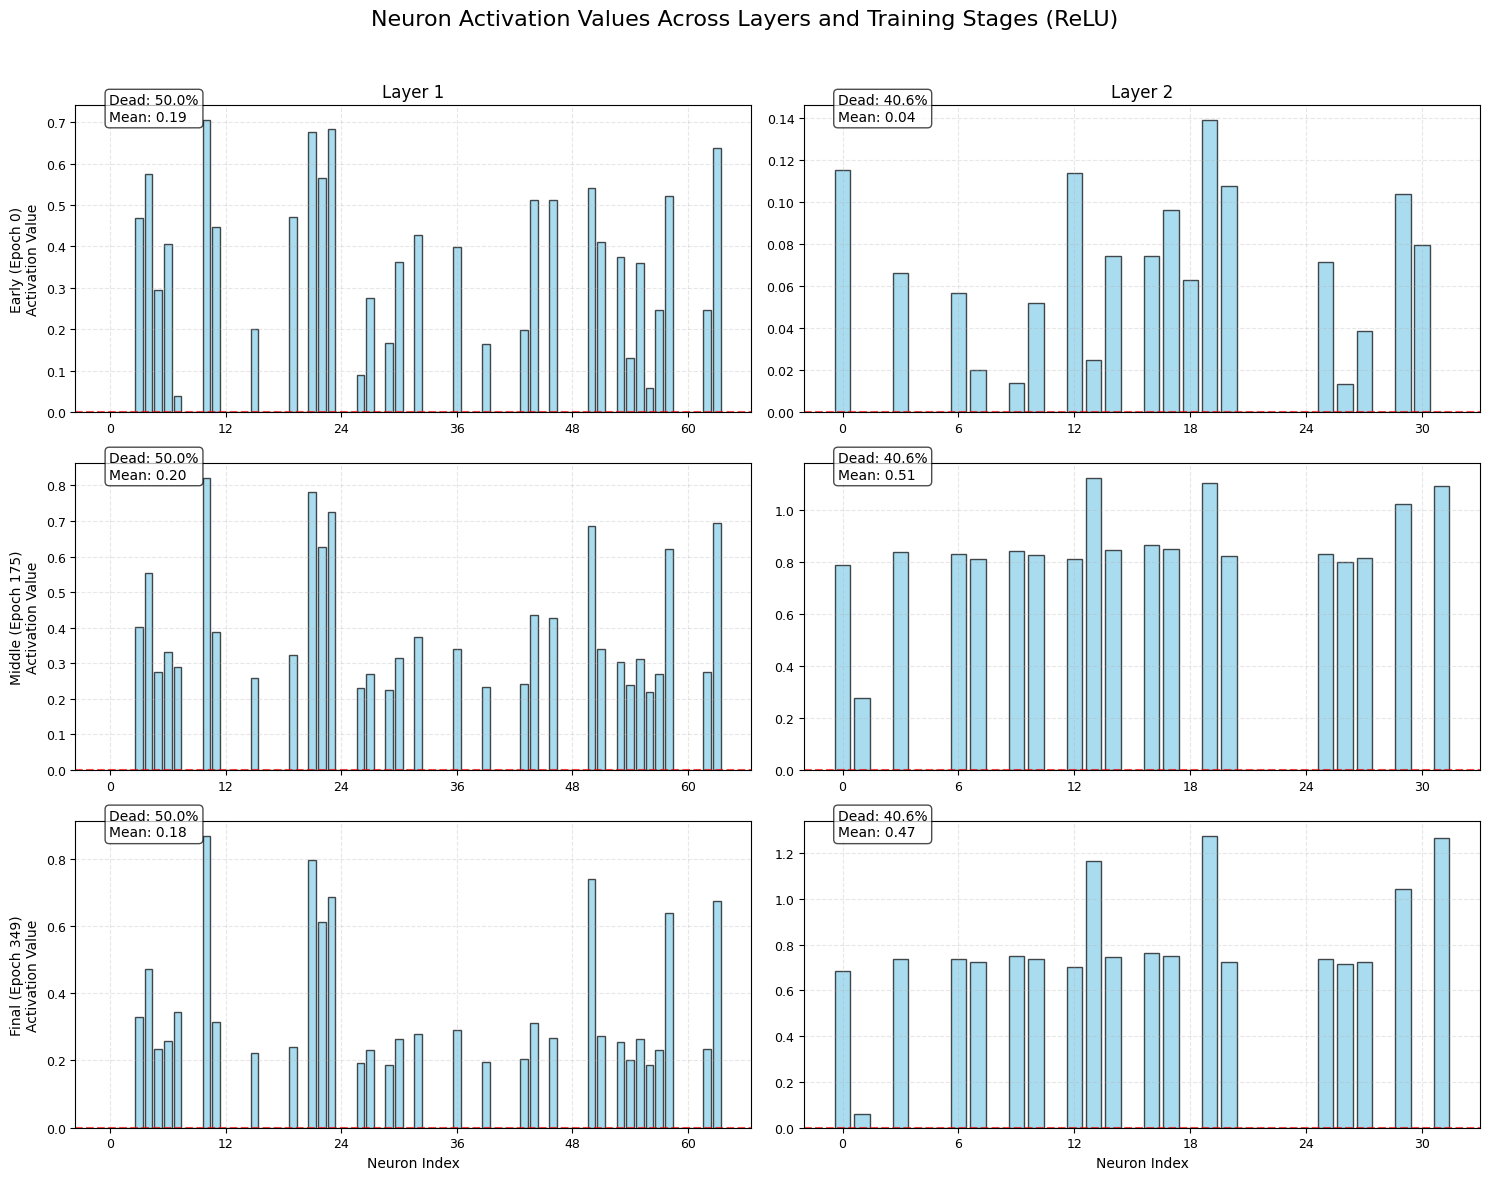


--- B-2: LeakyReLU Experiment ---

Epoch [1/350], Train Loss: 0.6953, Test Loss: 0.6912, Train Acc: 0.4981, Test Acc: 0.5075
Epoch [2/350], Train Loss: 0.6876, Test Loss: 0.6819, Train Acc: 0.5631, Test Acc: 0.4925
Epoch [3/350], Train Loss: 0.6607, Test Loss: 0.6412, Train Acc: 0.5019, Test Acc: 0.5150
Epoch [4/350], Train Loss: 0.5727, Test Loss: 0.4930, Train Acc: 0.7256, Test Acc: 0.8175
Epoch [5/350], Train Loss: 0.3963, Test Loss: 0.3430, Train Acc: 0.8269, Test Acc: 0.8525
Epoch [6/350], Train Loss: 0.3137, Test Loss: 0.2991, Train Acc: 0.8500, Test Acc: 0.8800
Epoch [7/350], Train Loss: 0.2857, Test Loss: 0.2831, Train Acc: 0.8656, Test Acc: 0.8775
Epoch [8/350], Train Loss: 0.2742, Test Loss: 0.2800, Train Acc: 0.8731, Test Acc: 0.8800
Epoch [9/350], Train Loss: 0.2686, Test Loss: 0.2703, Train Acc: 0.8775, Test Acc: 0.8875
Epoch [10/350], Train Loss: 0.2665, Test Loss: 0.2640, Train Acc: 0.8844, Test Acc: 0.8925
Epoch [11/350], Train Loss: 0.2614, Test Loss: 0.2585, Train Ac

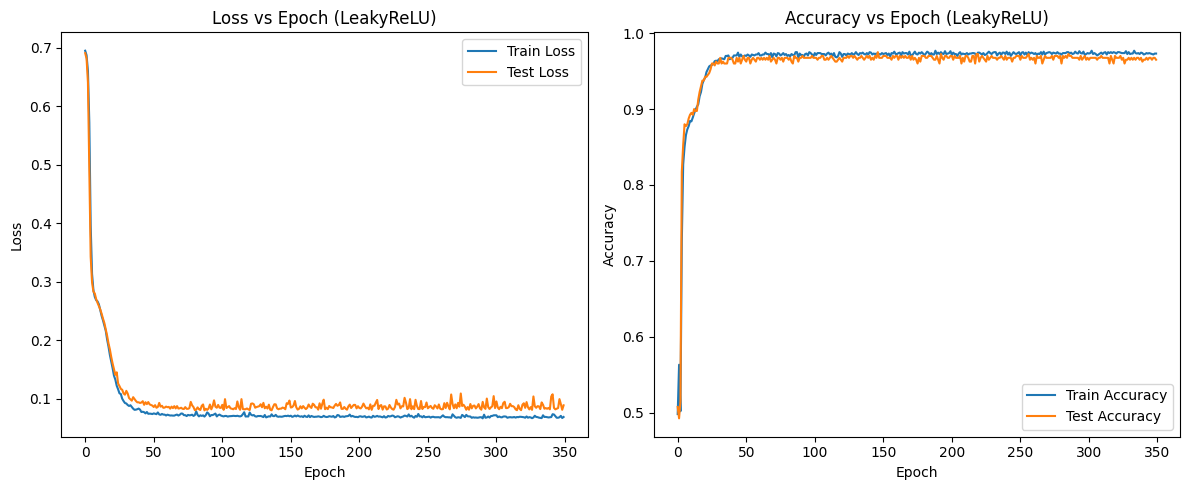

<ipython-input-15-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


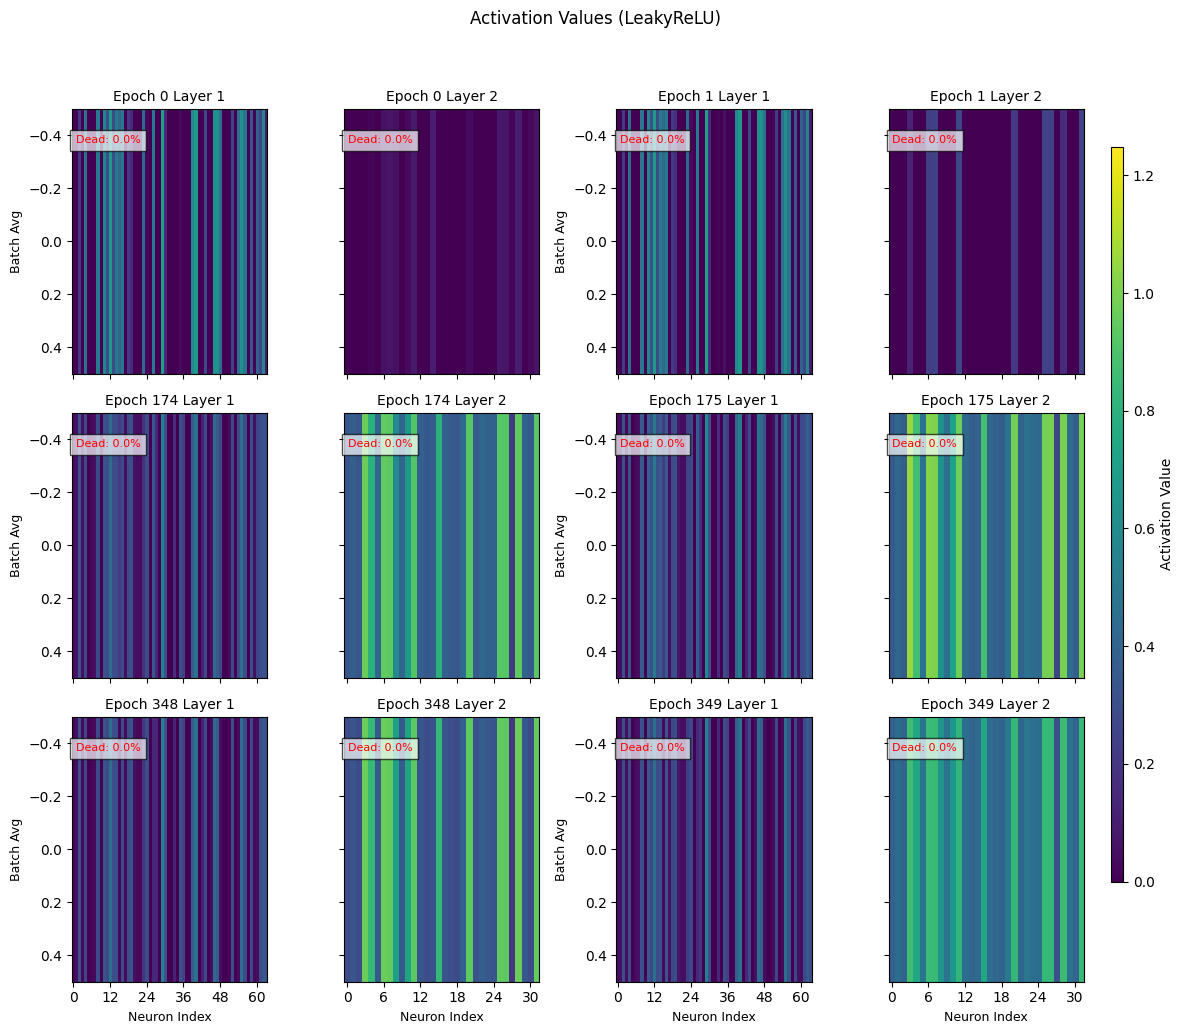

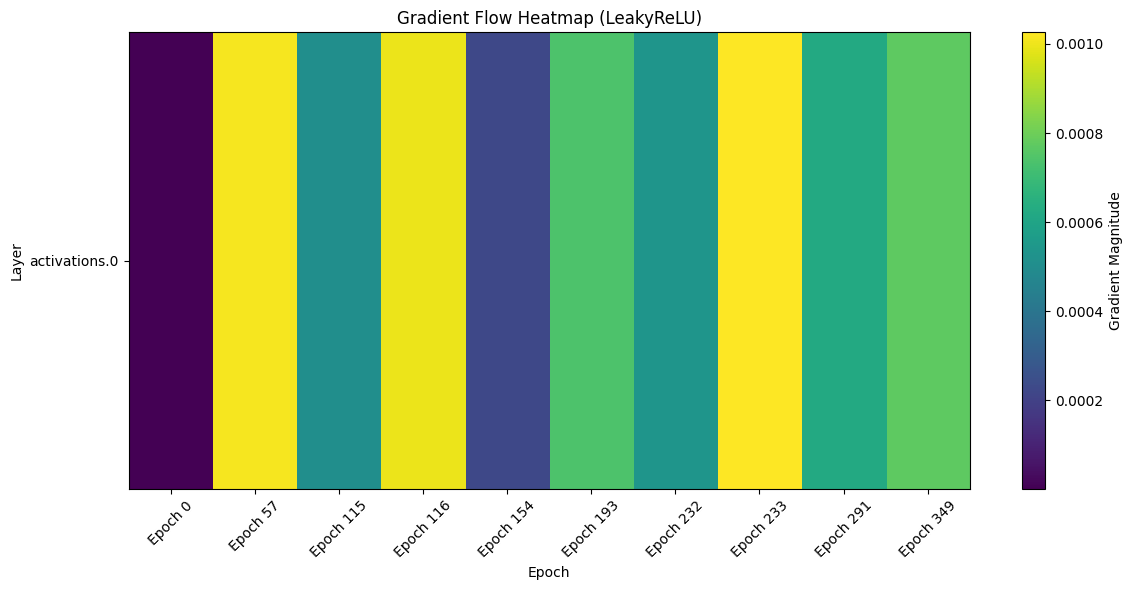

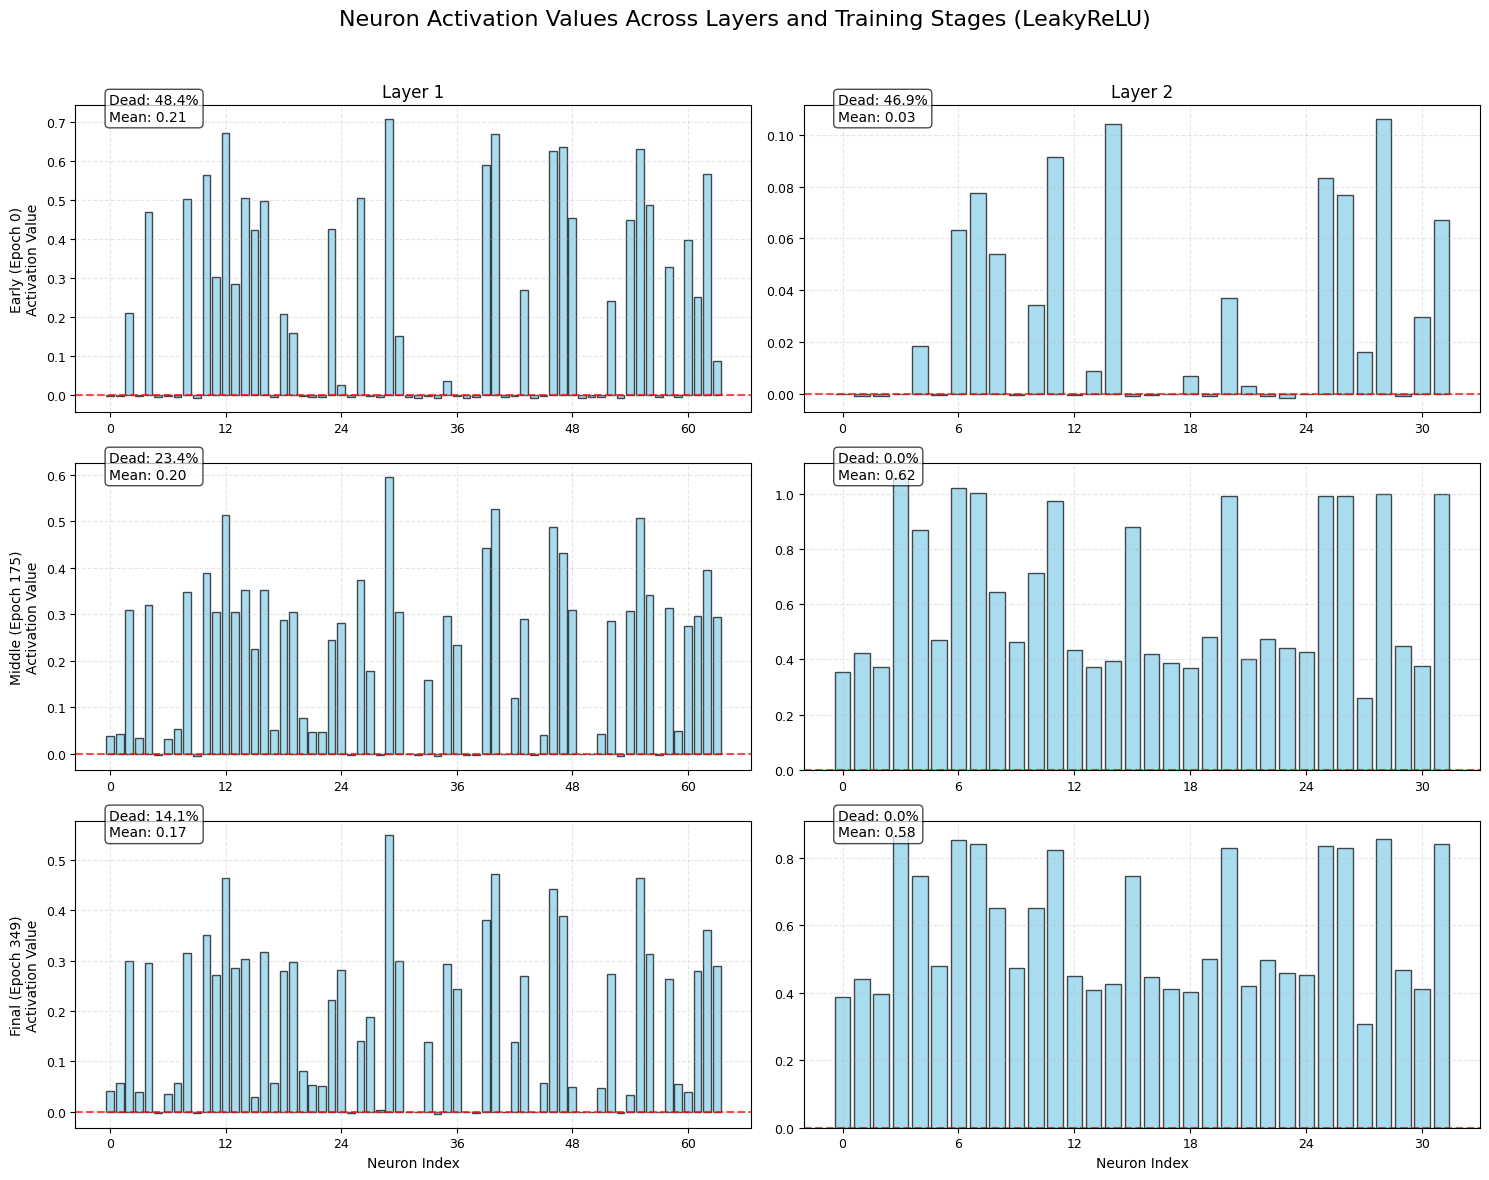


--- B-3: Sigmoid Experiment ---

Epoch [1/350], Train Loss: 0.6946, Test Loss: 0.6939, Train Acc: 0.4856, Test Acc: 0.4925
Epoch [2/350], Train Loss: 0.6941, Test Loss: 0.6932, Train Acc: 0.4844, Test Acc: 0.4925
Epoch [3/350], Train Loss: 0.6934, Test Loss: 0.6933, Train Acc: 0.5019, Test Acc: 0.4925
Epoch [4/350], Train Loss: 0.6925, Test Loss: 0.6916, Train Acc: 0.5181, Test Acc: 0.7575
Epoch [5/350], Train Loss: 0.6913, Test Loss: 0.6888, Train Acc: 0.5413, Test Acc: 0.5075
Epoch [6/350], Train Loss: 0.6871, Test Loss: 0.6851, Train Acc: 0.6019, Test Acc: 0.4950
Epoch [7/350], Train Loss: 0.6795, Test Loss: 0.6726, Train Acc: 0.6700, Test Acc: 0.8100
Epoch [8/350], Train Loss: 0.6628, Test Loss: 0.6505, Train Acc: 0.8056, Test Acc: 0.7850
Epoch [9/350], Train Loss: 0.6338, Test Loss: 0.6184, Train Acc: 0.8087, Test Acc: 0.8250
Epoch [10/350], Train Loss: 0.5915, Test Loss: 0.5685, Train Acc: 0.8119, Test Acc: 0.7900
Epoch [11/350], Train Loss: 0.5336, Test Loss: 0.5109, Train Acc:

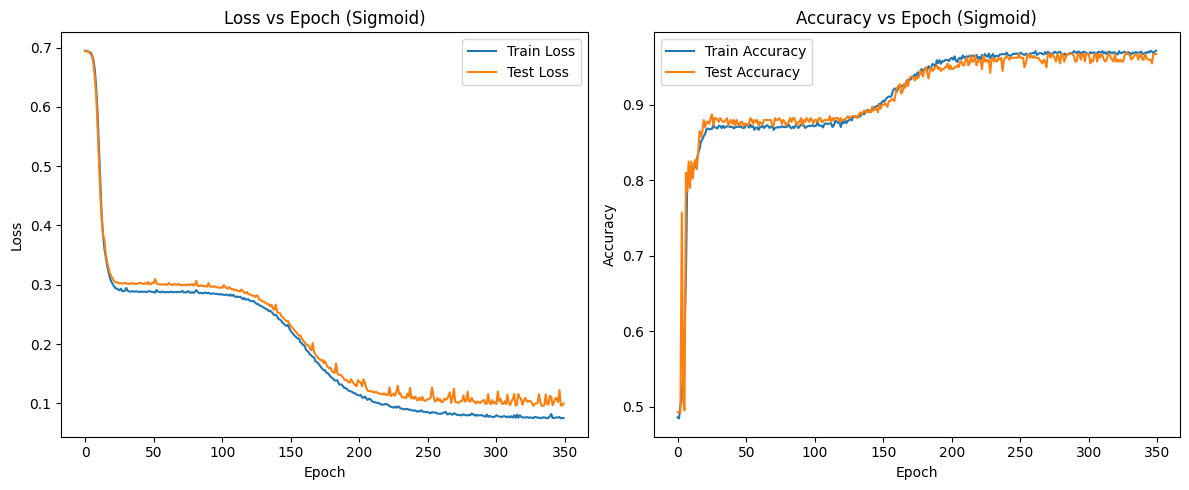

<ipython-input-15-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


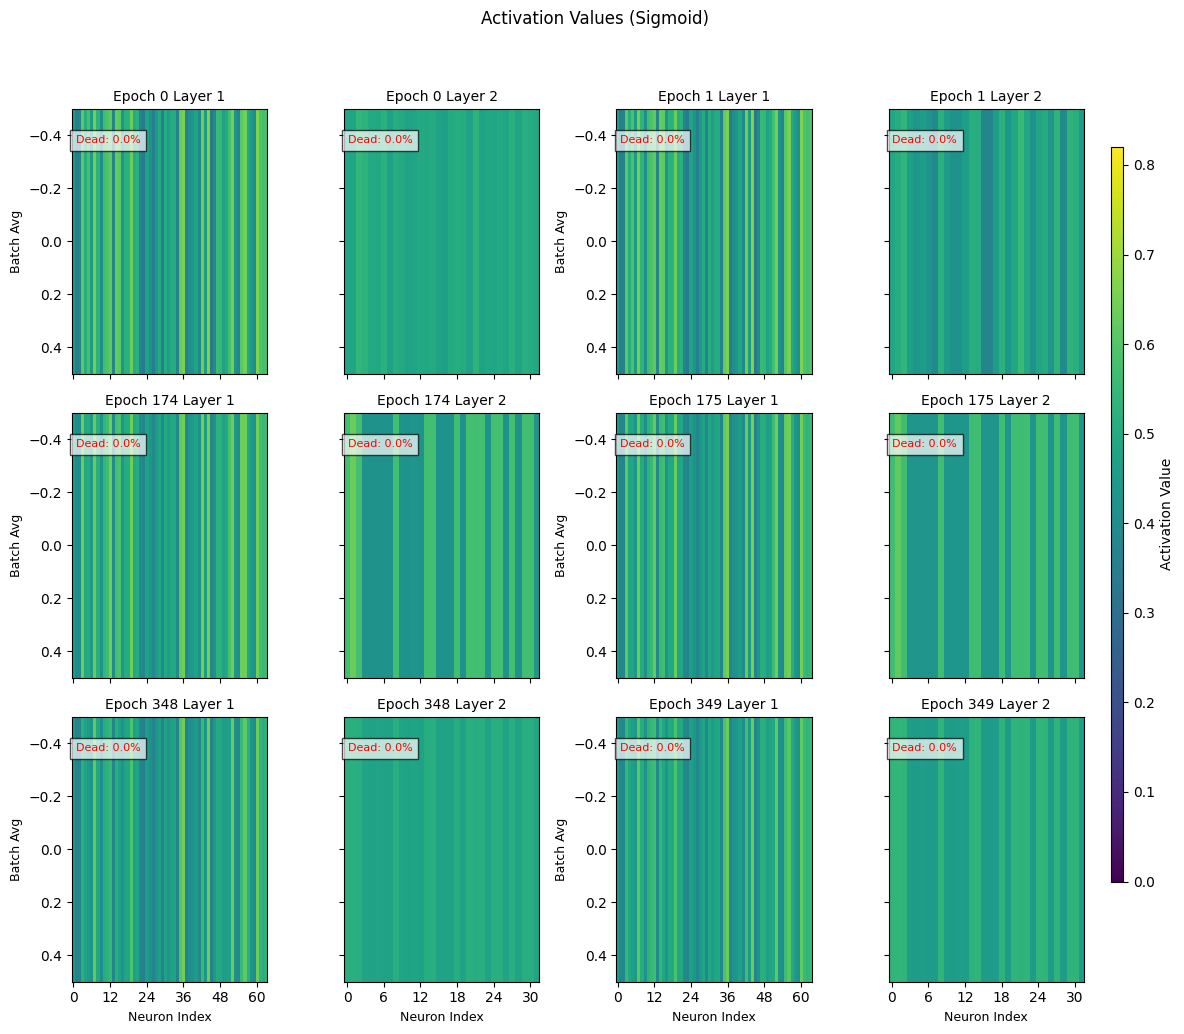

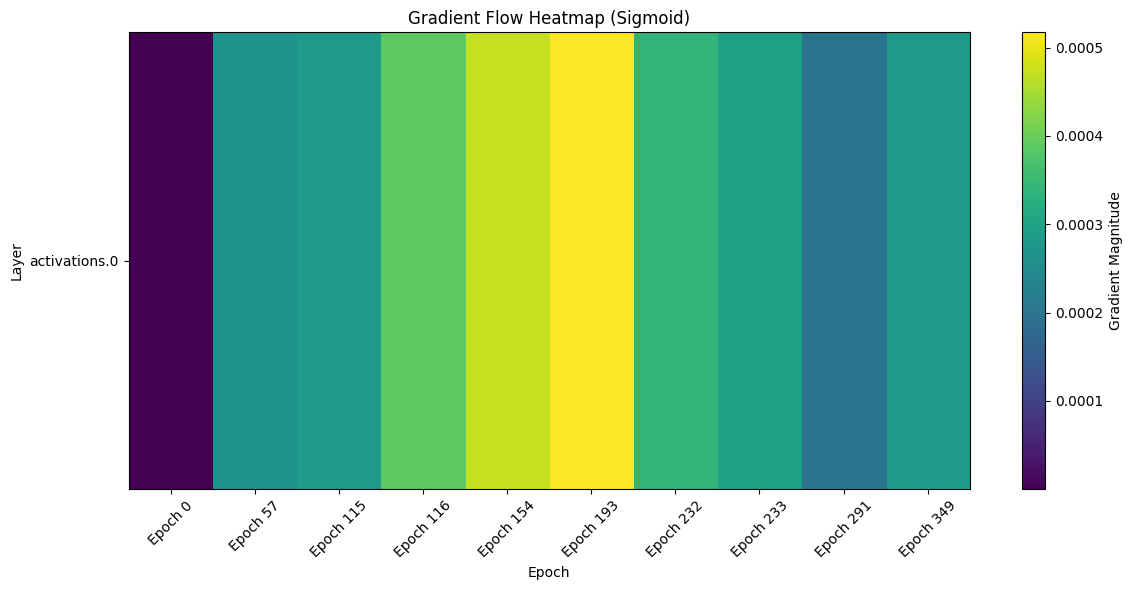

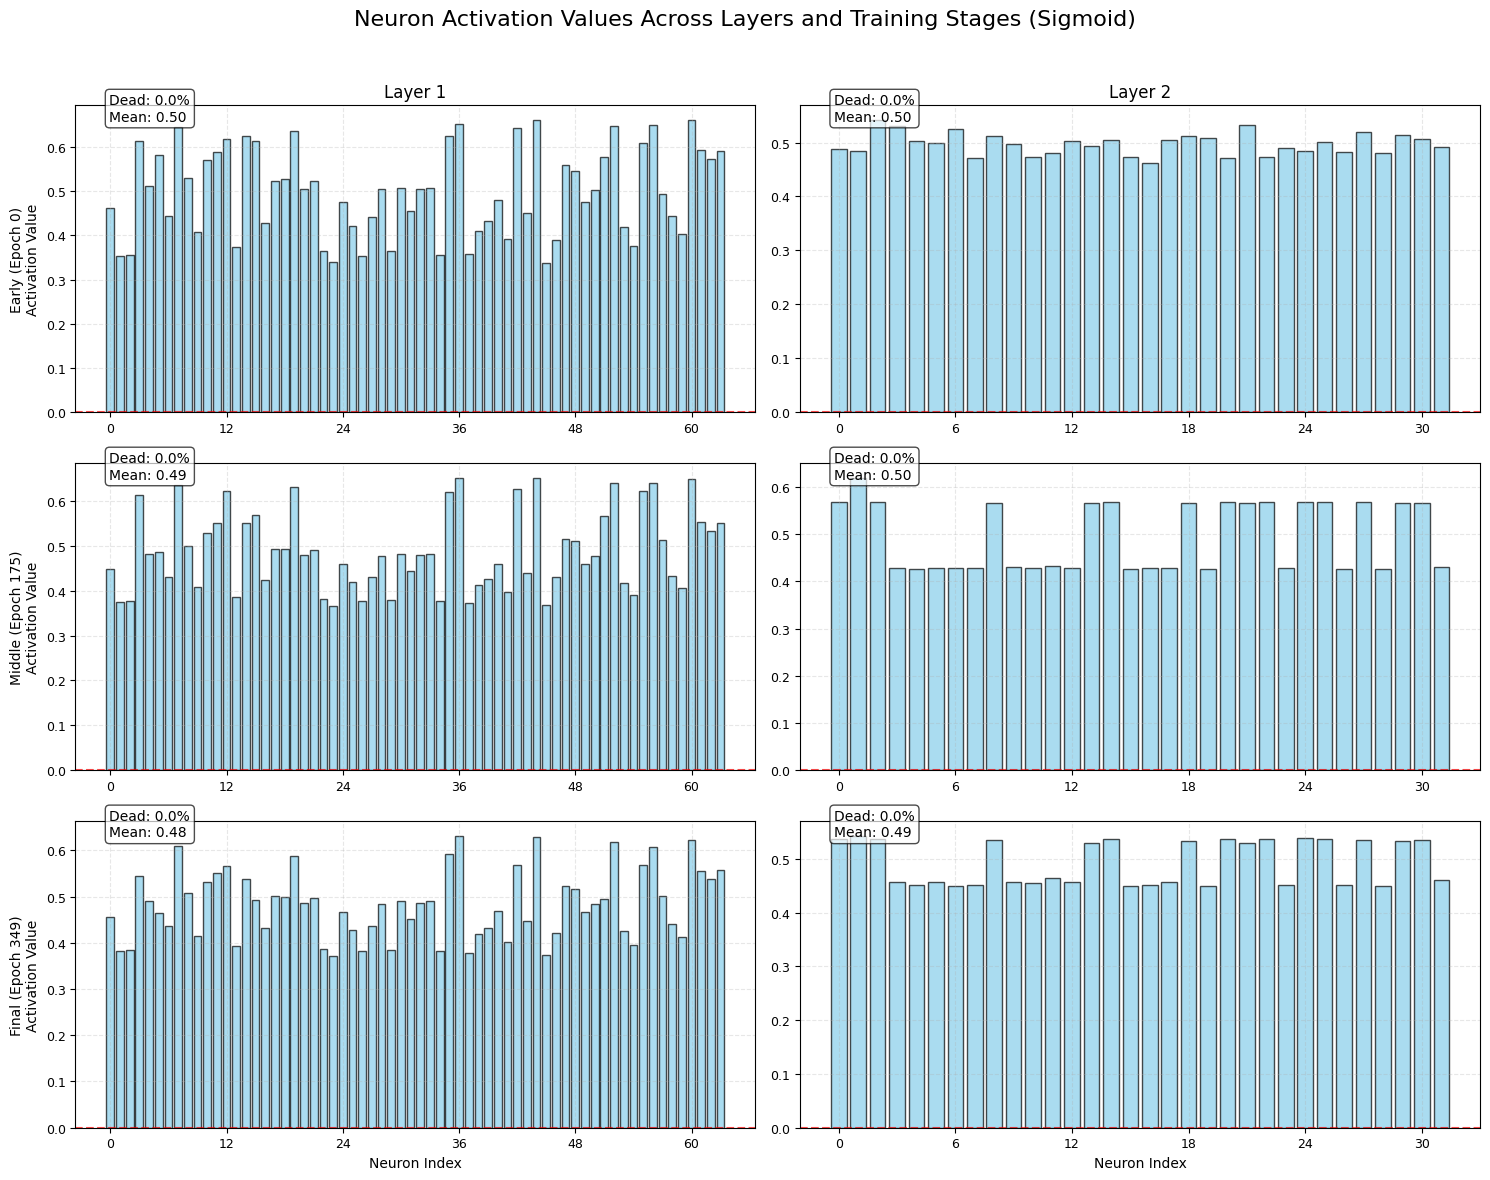

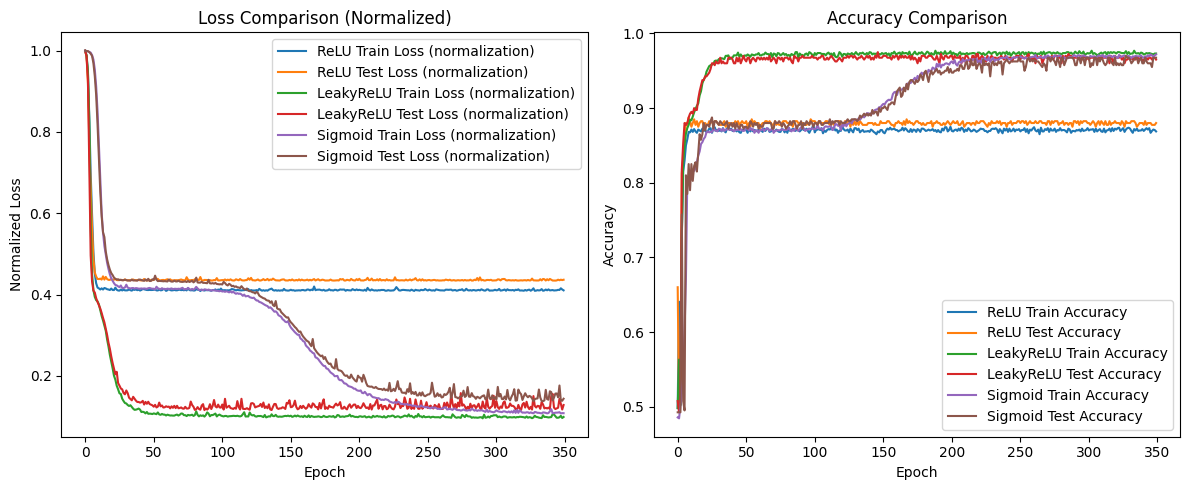

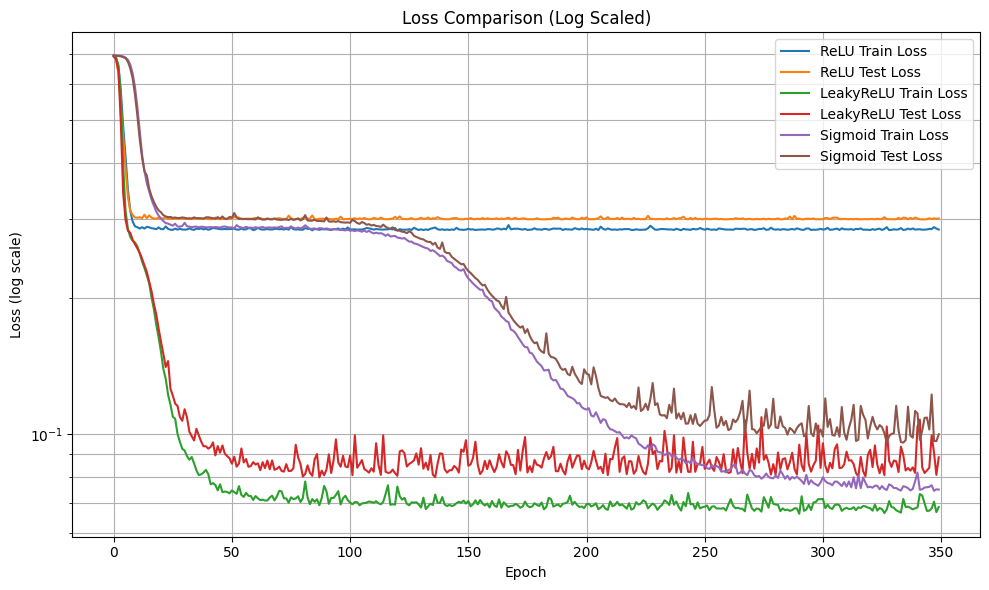

ReLU Convergence Epoch: 20
LeakyReLU Convergence Epoch: 349
Sigmoid Convergence Epoch: 30
Fastest convergence: ReLU at epoch 20

ReLU Final Train Accuracy: 0.8688
LeakyReLU Final Train Accuracy: 0.9731
Sigmoid Final Train Accuracy: 0.9719
ReLU Final Test Accuracy: 0.8800
LeakyReLU Final Test Accuracy: 0.9650
Sigmoid Final Test Accuracy: 0.9675


In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


# make_moons 데이터셋 로드 함수
def load_moons_dataset(n_samples=1000, noise=0.1, random_state=42, batch_size=64):
    # 데이터 생성
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # PyTorch 텐서로 변환
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    # 데이터 로더 생성
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# MLP 모델 정의
class MLPWithActivation(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[64, 32], num_classes=2, activation_type='relu', weight_std=0.01):
        super(MLPWithActivation, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        self.activation_type = activation_type

        # 활성화 함수 선택
        if activation_type == 'relu':
            activation_fn = nn.ReLU()
        elif activation_type == 'leaky_relu':
            activation_fn = nn.LeakyReLU(0.01)  # 기본 기울기 0.01
        elif activation_type == 'sigmoid':
            activation_fn = nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation type: {activation_type}")

        # 입력층 -> 첫 번째 은닉층
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        # 가중치 초기화 (Dead ReLU 유도를 위해 작은 표준편차 사용)
        nn.init.normal_(self.layers[-1].weight, std=weight_std)
        self.activations.append(activation_fn)

        # 중간 은닉층들
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            nn.init.normal_(self.layers[-1].weight, std=weight_std)
            self.activations.append(activation_fn)

        # 마지막 은닉층 -> 출력층
        self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        nn.init.normal_(self.layers[-1].weight, std=weight_std)

    def forward(self, x):
        layer_outputs = []
        activation_outputs = []

        # 순전파
        for i, (layer, activation) in enumerate(zip(self.layers[:-1], self.activations)):
            x = layer(x)
            layer_outputs.append(x)
            x = activation(x)
            activation_outputs.append(x)

        # 출력층
        x = self.layers[-1](x)
        layer_outputs.append(x)

        return x, layer_outputs, activation_outputs


# 활성화 함수별 학습 함수
def train_model_with_activation(model, train_loader, test_loader, criterion, optimizer, num_epochs=200, activation_type='relu'):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    # 활성화값과 그래디언트 훅 등록
    act_grad_hook = ActivationGradientHook()
    act_grad_hook.register_hooks(model)

    # 각 에폭별 활성화값과 그래디언트 저장용
    activation_history = {epoch: {} for epoch in range(num_epochs)}
    gradient_history = {epoch: {} for epoch in range(num_epochs)}
    dead_relu_history = {epoch: {} for epoch in range(num_epochs)}

    for epoch in range(num_epochs):
        # 학습
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, layer_outputs, activation_outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            # 활성화값, 그래디언트 저장. 메모리 한계와 미니 배치의 특성상 첫 번째 배치에서만 저장하도록 구성
            if batch_idx == 0:
                # 활성화값 저장
                for i, act in enumerate(activation_outputs):
                    activation_history[epoch][f'layer_{i+1}'] = act.detach().cpu().numpy()
                    # Dead ReLU 계산 (ReLU인 경우만)
                    if activation_type == 'relu' or activation_type == 'leaky_relu':
                        dead_ratio = (act <= 0).float().mean().item()
                        dead_relu_history[epoch][f'layer_{i+1}'] = dead_ratio
                    else:
                        dead_relu_history[epoch][f'layer_{i+1}'] = 0  # 시그모이드는 Dead ReLU 없음

                # 그래디언트
                for name, gradient in act_grad_hook.gradients.items():
                    gradient_history[epoch][name] = gradient.numpy()

                # 메모리 정리용
                act_grad_hook.clear()

        # 테스트
        model.eval()
        test_loss = 0
        test_preds = []
        test_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _, _ = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # 결과 계산
        train_loss = train_loss / len(train_loader)
        test_loss = test_loss / len(test_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        test_acc = accuracy_score(test_labels, test_preds)

        # 결과 저장
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Test Acc: {test_acc:.4f}')

    # 훅 제거
    act_grad_hook.remove_hooks()

    return train_losses, test_losses, train_accs, test_accs, activation_history, gradient_history, dead_relu_history


# 활성화 함수 비교 시각화
def plot_activation_comparison(relu_results, leaky_results, sigmoid_results, save_dir="expB_results/comparison"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 결과 추출
    relu_train_losses, relu_test_losses, relu_train_accs, relu_test_accs = relu_results[:4]
    leaky_train_losses, leaky_test_losses, leaky_train_accs, leaky_test_accs = leaky_results[:4]
    sigmoid_train_losses, sigmoid_test_losses, sigmoid_train_accs, sigmoid_test_accs = sigmoid_results[:4]

    # 1. 정규화된 손실 비교
    plt.figure(figsize=(12, 5))

    # 정규화된 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot([loss/relu_train_losses[0] for loss in relu_train_losses], label='ReLU Train Loss (normalization)')
    plt.plot([loss/relu_test_losses[0] for loss in relu_test_losses], label='ReLU Test Loss (normalization)')
    plt.plot([loss/leaky_train_losses[0] for loss in leaky_train_losses], label='LeakyReLU Train Loss (normalization)')
    plt.plot([loss/leaky_test_losses[0] for loss in leaky_test_losses], label='LeakyReLU Test Loss (normalization)')
    plt.plot([loss/sigmoid_train_losses[0] for loss in sigmoid_train_losses], label='Sigmoid Train Loss (normalization)')
    plt.plot([loss/sigmoid_test_losses[0] for loss in sigmoid_test_losses], label='Sigmoid Test Loss (normalization)')
    plt.title('Loss Comparison (Normalized)')
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(relu_train_accs, label='ReLU Train Accuracy')
    plt.plot(relu_test_accs, label='ReLU Test Accuracy')
    plt.plot(leaky_train_accs, label='LeakyReLU Train Accuracy')
    plt.plot(leaky_test_accs, label='LeakyReLU Test Accuracy')
    plt.plot(sigmoid_train_accs, label='Sigmoid Train Accuracy')
    plt.plot(sigmoid_test_accs, label='Sigmoid Test Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'normalized_comparison.png'))
    plt.show()

    # 2. 로그 스케일 손실 비교
    plt.figure(figsize=(10, 6))
    plt.semilogy(relu_train_losses, label='ReLU Train Loss')
    plt.semilogy(relu_test_losses, label='ReLU Test Loss')
    plt.semilogy(leaky_train_losses, label='LeakyReLU Train Loss')
    plt.semilogy(leaky_test_losses, label='LeakyReLU Test Loss')
    plt.semilogy(sigmoid_train_losses, label='Sigmoid Train Loss')
    plt.semilogy(sigmoid_test_losses, label='Sigmoid Test Loss')
    plt.title('Loss Comparison (Log Scaled)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'log_scale_comparison.png'))
    plt.show()

    # 3. 수렴 분석
    relu_convergence = detect_convergence(relu_test_losses)
    leaky_convergence = detect_convergence(leaky_test_losses)
    sigmoid_convergence = detect_convergence(sigmoid_test_losses)

    # 결과 출력
    print(f"ReLU Convergence Epoch: {relu_convergence}")
    print(f"LeakyReLU Convergence Epoch: {leaky_convergence}")
    print(f"Sigmoid Convergence Epoch: {sigmoid_convergence}")

    fastest = min(relu_convergence, leaky_convergence, sigmoid_convergence)
    if fastest == relu_convergence:
        fastest_name = "ReLU"
    elif fastest == leaky_convergence:
        fastest_name = "LeakyReLU"
    else:
        fastest_name = "Sigmoid"

    print(f"Fastest convergence: {fastest_name} at epoch {fastest}")

    print(f"\nReLU Final Train Accuracy: {relu_train_accs[-1]:.4f}")
    print(f"LeakyReLU Final Train Accuracy: {leaky_train_accs[-1]:.4f}")
    print(f"Sigmoid Final Train Accuracy: {sigmoid_train_accs[-1]:.4f}")
    print(f"ReLU Final Test Accuracy: {relu_test_accs[-1]:.4f}")
    print(f"LeakyReLU Final Test Accuracy: {leaky_test_accs[-1]:.4f}")
    print(f"Sigmoid Final Test Accuracy: {sigmoid_test_accs[-1]:.4f}")

    # 파일에 결과 저장
    with open(os.path.join(save_dir, 'comparison_results.txt'), 'w') as f:
        f.write(f"ReLU Convergence Epoch: {relu_convergence}\n")
        f.write(f"LeakyReLU Convergence Epoch: {leaky_convergence}\n")
        f.write(f"Sigmoid Convergence Epoch: {sigmoid_convergence}\n")
        f.write(f"Fastest convergence: {fastest_name} at epoch {fastest}\n\n")

        f.write(f"ReLU Final Train Accuracy: {relu_train_accs[-1]:.4f}\n")
        f.write(f"LeakyReLU Final Train Accuracy: {leaky_train_accs[-1]:.4f}\n")
        f.write(f"Sigmoid Final Train Accuracy: {sigmoid_train_accs[-1]:.4f}\n")
        f.write(f"ReLU Final Test Accuracy: {relu_test_accs[-1]:.4f}\n")
        f.write(f"LeakyReLU Final Test Accuracy: {leaky_test_accs[-1]:.4f}\n")
        f.write(f"Sigmoid Final Test Accuracy: {sigmoid_test_accs[-1]:.4f}\n")

    return relu_convergence, leaky_convergence, sigmoid_convergence

def plot_layer_distributions(activation_history, title_suffix="", save_dir="results/distributions", max_neurons=100):
    """
    대표 에포크(초기, 중간, 후기)에 대한 각 레이어의 뉴런별 활성화 값을 시각화

    Parameters:
        activation_history: 에포크별 레이어별 활성화 값 기록
        title_suffix: 제목에 추가할 문자열
        save_dir: 결과 저장 디렉토리
        max_neurons: 표시할 최대 뉴런 수 (너무 많은 경우 샘플링)
    """
    # 저장 디렉토리 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 에포크 및 레이어 정보 가져오기
    all_epochs = sorted(list(activation_history.keys()))
    layers = list(activation_history[all_epochs[0]].keys())

    # 대표 에포크 선택 (초기, 중간, 후기)
    early_epoch = all_epochs[0]
    mid_epoch = all_epochs[len(all_epochs) // 2]
    last_epoch = all_epochs[-1]
    selected_epochs = [early_epoch, mid_epoch, last_epoch]
    epoch_labels = ['Early', 'Middle', 'Final']

    # 모든 레이어의 모든 선택된 에포크에 대한 하나의 그림 생성
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3행(에포크) x 2열(레이어)

    # 각 에포크와 레이어 조합에 대한 바 차트
    for epoch_idx, (epoch, label) in enumerate(zip(selected_epochs, epoch_labels)):
        for layer_idx, layer in enumerate(layers):
            # 현재 서브플롯 선택
            ax = axes[epoch_idx, layer_idx]

            # 활성화값 가져오기 (첫 번째 배치만 사용)
            activations = activation_history[epoch][layer]

            # 각 뉴런의 평균 활성화값 계산 (배치에 대한 평균)
            neuron_means = np.mean(activations, axis=0)

            # 너무 많은 뉴런이 있는 경우 샘플링
            num_neurons = len(neuron_means)
            if num_neurons > max_neurons:
                # 균등하게 샘플링
                indices = np.linspace(0, num_neurons - 1, max_neurons, dtype=int)
                neuron_means = neuron_means[indices]
                num_neurons = max_neurons

            # 바 차트 그리기
            x = np.arange(num_neurons)
            ax.bar(x, neuron_means, width=0.8, alpha=0.7, color='skyblue', edgecolor='black')

            # 0 위치에 수평선 추가 (ReLU에서 중요)
            ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)

            # Dead 뉴런 비율 계산
            dead_ratio = np.mean(neuron_means <= 0) * 100
            mean_val = np.mean(neuron_means)

            # 텍스트 정보 추가 (Dead, Mean만 표시)
            ax.annotate(f'Dead: {dead_ratio:.1f}%\nMean: {mean_val:.2f}',
                        xy=(0.05, 0.95), xycoords='axes fraction',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

            # 제목 설정
            if epoch_idx == 0:
                ax.set_title(f'Layer {layer_idx+1}')

            # X축 레이블은 마지막 행에만 표시
            if epoch_idx == 2:
                ax.set_xlabel('Neuron Index')

            # Y축 레이블은 첫 번째 열에만 표시
            if layer_idx == 0:
                ax.set_ylabel(f'{label} (Epoch {epoch})\nActivation Value')

            # 그리드 추가
            ax.grid(True, alpha=0.3, linestyle='--')

            # 눈금 설정 (x축은 5개 정도만 표시)
            tick_interval = max(1, num_neurons // 5)
            ax.set_xticks(np.arange(0, num_neurons, tick_interval))
            ax.set_xticklabels(np.arange(0, num_neurons, tick_interval))
            ax.tick_params(axis='both', which='major', labelsize=9)

            # y축 범위는 각 레이어와 에포크에 맞게 자동 조정

    # 전체 제목 설정
    plt.suptitle(f'Neuron Activation Values Across Layers and Training Stages {title_suffix}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # suptitle을 위한 여백 확보

    # 저장 및 표시
    plt.savefig(os.path.join(save_dir, f'all_layers_neuron_activations{title_suffix.replace(" ", "_")}.png'), dpi=150)
    plt.show()

    return "Layer neuron activation visualization completed."

# 실험 B 실행 함수
def run_experiment_B():
    print("\n===== Experiment B: Activation Function Comparison (ReLU vs LeakyReLU vs Sigmoid) =====\n")

    # 결과 저장 디렉토리 생성
    if not os.path.exists("expB_results"):
        os.makedirs("expB_results")

    # 데이터셋 로드
    train_loader, test_loader = load_moons_dataset(n_samples=2000, noise=0.2)

    num_epochs = 350 # 에포크 수 설정
    weight_std = 0.01  # Dead ReLU 유도를 위한 작은 초기 가중치

    # 1. ReLU 실험
    print("\n--- B-1: ReLU Experiment ---\n")

    # 모델 정의
    relu_model = MLPWithActivation(activation_type='relu', weight_std=weight_std).to(device)

    # 손실 함수와 옵티마이저 설정
    relu_loss_fn = nn.CrossEntropyLoss()
    relu_optimizer = optim.Adam(relu_model.parameters(), lr=0.001)

    # 학습 및 결과 수집
    relu_results = train_model_with_activation(
        model=relu_model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=relu_loss_fn,
        optimizer=relu_optimizer,
        num_epochs=num_epochs,
        activation_type='relu'
    )

    # 개별 결과 시각화
    plot_learning_curves(
        relu_results[0], relu_results[1], relu_results[2], relu_results[3],
        title_suffix="(ReLU)",
        save_dir="expB_results/ReLU"
    )

    plot_activation_heatmap(
        relu_results[4],
        title_suffix="(ReLU)",
        save_dir="expB_results/ReLU"
    )

    plot_gradient_flow_heatmap(
        relu_results[5],
        title_suffix="(ReLU)",
        save_dir="expB_results/ReLU"
    )

    plot_layer_distributions(
        relu_results[4],
        title_suffix="(ReLU)",
        save_dir="expB_results/ReLU/distributions"
    )

    # 2. LeakyReLU 실험
    print("\n--- B-2: LeakyReLU Experiment ---\n")

    # 모델 정의
    leaky_model = MLPWithActivation(activation_type='leaky_relu', weight_std=weight_std).to(device)

    # 손실 함수와 옵티마이저 설정
    leaky_loss_fn = nn.CrossEntropyLoss()
    leaky_optimizer = optim.Adam(leaky_model.parameters(), lr=0.001)

    # 학습 및 결과 수집
    leaky_results = train_model_with_activation(
        model=leaky_model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=leaky_loss_fn,
        optimizer=leaky_optimizer,
        num_epochs=num_epochs,
        activation_type='leaky_relu'
    )

    # 개별 결과 시각화
    plot_learning_curves(
        leaky_results[0], leaky_results[1], leaky_results[2], leaky_results[3],
        title_suffix="(LeakyReLU)",
        save_dir="expB_results/LeakyReLU"
    )

    plot_activation_heatmap(
        leaky_results[4],
        title_suffix="(LeakyReLU)",
        save_dir="expB_results/LeakyReLU"
    )

    plot_gradient_flow_heatmap(
        leaky_results[5],
        title_suffix="(LeakyReLU)",
        save_dir="expB_results/LeakyReLU"
    )

    plot_layer_distributions(
        leaky_results[4],
        title_suffix="(LeakyReLU)",
        save_dir="expB_results/LeakyReLU/distributions"
    )

    # 3. Sigmoid 실험
    print("\n--- B-3: Sigmoid Experiment ---\n")

    # 모델 정의
    sigmoid_model = MLPWithActivation(activation_type='sigmoid', weight_std=weight_std).to(device)

    # 손실 함수와 옵티마이저 설정
    sigmoid_loss_fn = nn.CrossEntropyLoss()
    sigmoid_optimizer = optim.Adam(sigmoid_model.parameters(), lr=0.001)

    # 학습 및 결과 수집
    sigmoid_results = train_model_with_activation(
        model=sigmoid_model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=sigmoid_loss_fn,
        optimizer=sigmoid_optimizer,
        num_epochs=num_epochs,
        activation_type='sigmoid'
    )

    # 개별 결과 시각화
    plot_learning_curves(
        sigmoid_results[0], sigmoid_results[1], sigmoid_results[2], sigmoid_results[3],
        title_suffix="(Sigmoid)",
        save_dir="expB_results/Sigmoid"
    )

    plot_activation_heatmap(
        sigmoid_results[4],
        title_suffix="(Sigmoid)",
        save_dir="expB_results/Sigmoid"
    )

    plot_gradient_flow_heatmap(
        sigmoid_results[5],
        title_suffix="(Sigmoid)",
        save_dir="expB_results/Sigmoid"
    )

    plot_layer_distributions(
        sigmoid_results[4],
        title_suffix="(Sigmoid)",
        save_dir="expB_results/Sigmoid/distributions"
    )

    # 4. 활성화 함수 비교 시각화
    plot_activation_comparison(
        relu_results[:4],
        leaky_results[:4],
        sigmoid_results[:4],
        save_dir="expB_results/comparison"
    )

    return relu_results, leaky_results, sigmoid_results

# 메인 실행 코드
if __name__ == "__main__":
    # 실험 B 실행
    relu_results, leaky_results, sigmoid_results = run_experiment_B()

# 3. Experiment C - Optimizer 비교 :  SGD, SGD+Momentum, Adam


===== 실험 C: 최적화 알고리즘 비교 (SGD, SGD+Momentum, Adam) =====


--- SGD 학습률 실험 ---


--- SGD (lr=0.1) ---

Epoch [1/30], LR: 0.100000, Train Loss: 0.5782, Test Loss: 0.4912, Train Acc: 0.7885, Test Acc: 0.8215
Epoch [2/30], LR: 0.100000, Train Loss: 0.4018, Test Loss: 0.4893, Train Acc: 0.8514, Test Acc: 0.8147
Epoch [3/30], LR: 0.100000, Train Loss: 0.3566, Test Loss: 0.4167, Train Acc: 0.8677, Test Acc: 0.8487
Epoch [4/30], LR: 0.100000, Train Loss: 0.3272, Test Loss: 0.4228, Train Acc: 0.8786, Test Acc: 0.8472
Epoch [5/30], LR: 0.100000, Train Loss: 0.3102, Test Loss: 0.3575, Train Acc: 0.8839, Test Acc: 0.8703
Epoch [6/30], LR: 0.100000, Train Loss: 0.2933, Test Loss: 0.3726, Train Acc: 0.8901, Test Acc: 0.8635
Epoch [7/30], LR: 0.100000, Train Loss: 0.2788, Test Loss: 0.3377, Train Acc: 0.8949, Test Acc: 0.8743
Epoch [8/30], LR: 0.100000, Train Loss: 0.2645, Test Loss: 0.3632, Train Acc: 0.9012, Test Acc: 0.8627
Epoch [9/30], LR: 0.100000, Train Loss: 0.2528, Test Loss: 0.3501, Train A

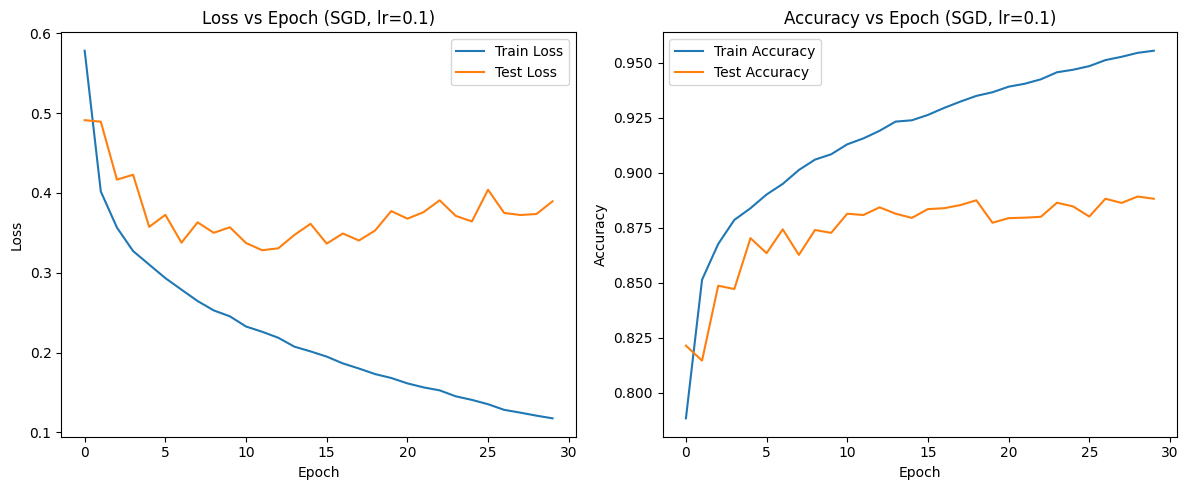

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


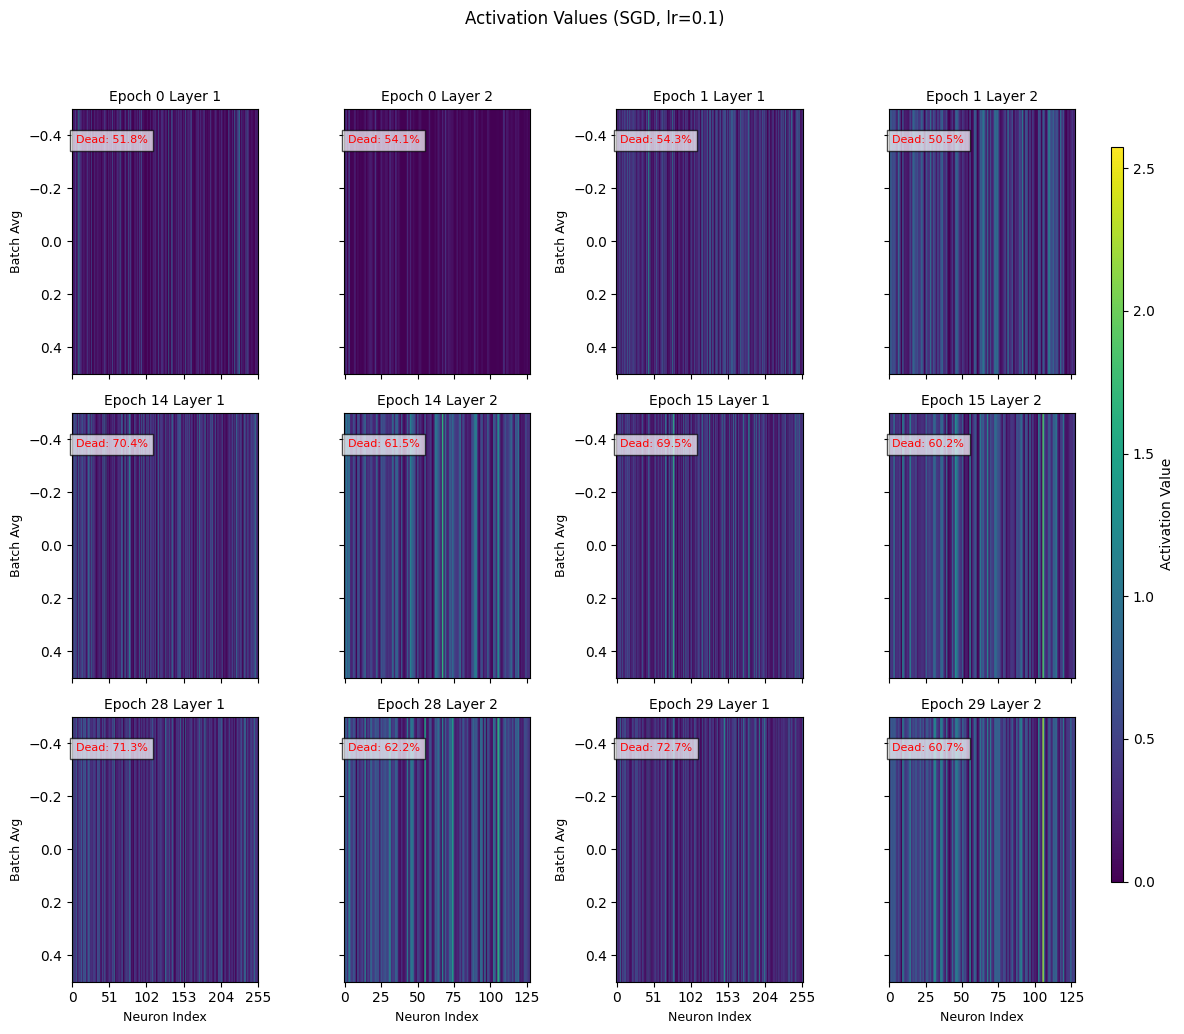

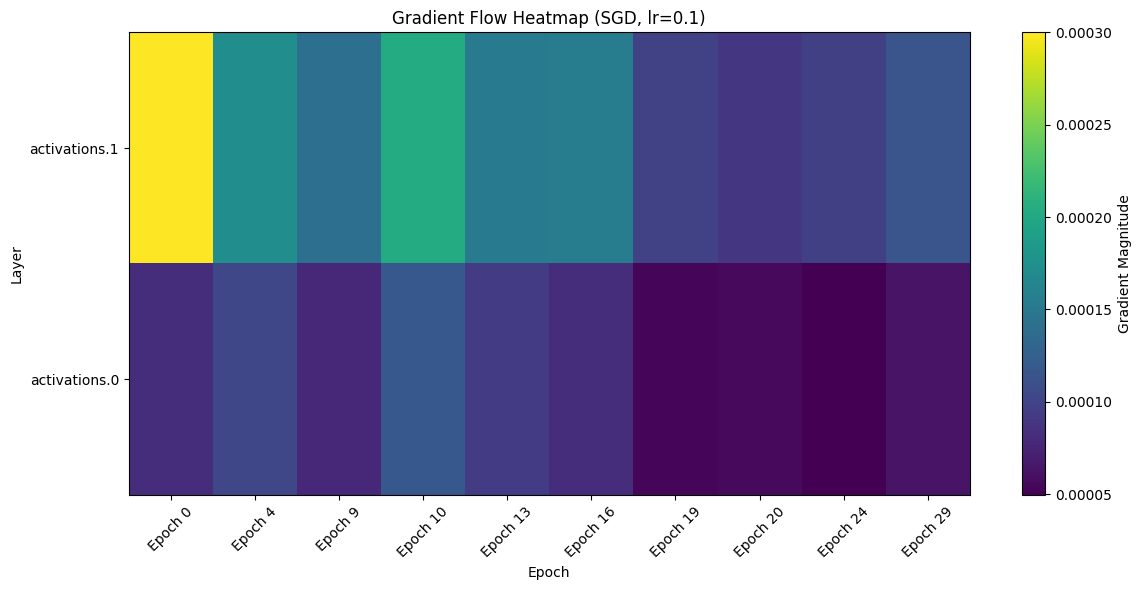


--- SGD (lr=0.01) ---

Epoch [1/30], LR: 0.010000, Train Loss: 0.9761, Test Loss: 0.6282, Train Acc: 0.6888, Test Acc: 0.7693
Epoch [2/30], LR: 0.010000, Train Loss: 0.5480, Test Loss: 0.5378, Train Acc: 0.8017, Test Acc: 0.8026
Epoch [3/30], LR: 0.010000, Train Loss: 0.4843, Test Loss: 0.5089, Train Acc: 0.8268, Test Acc: 0.8134
Epoch [4/30], LR: 0.010000, Train Loss: 0.4497, Test Loss: 0.4635, Train Acc: 0.8401, Test Acc: 0.8335
Epoch [5/30], LR: 0.010000, Train Loss: 0.4272, Test Loss: 0.4496, Train Acc: 0.8481, Test Acc: 0.8407
Epoch [6/30], LR: 0.010000, Train Loss: 0.4111, Test Loss: 0.4344, Train Acc: 0.8528, Test Acc: 0.8426
Epoch [7/30], LR: 0.010000, Train Loss: 0.3962, Test Loss: 0.4232, Train Acc: 0.8579, Test Acc: 0.8469
Epoch [8/30], LR: 0.010000, Train Loss: 0.3840, Test Loss: 0.4222, Train Acc: 0.8627, Test Acc: 0.8458
Epoch [9/30], LR: 0.010000, Train Loss: 0.3737, Test Loss: 0.4029, Train Acc: 0.8667, Test Acc: 0.8542
Epoch [10/30], LR: 0.010000, Train Loss: 0.3639, 

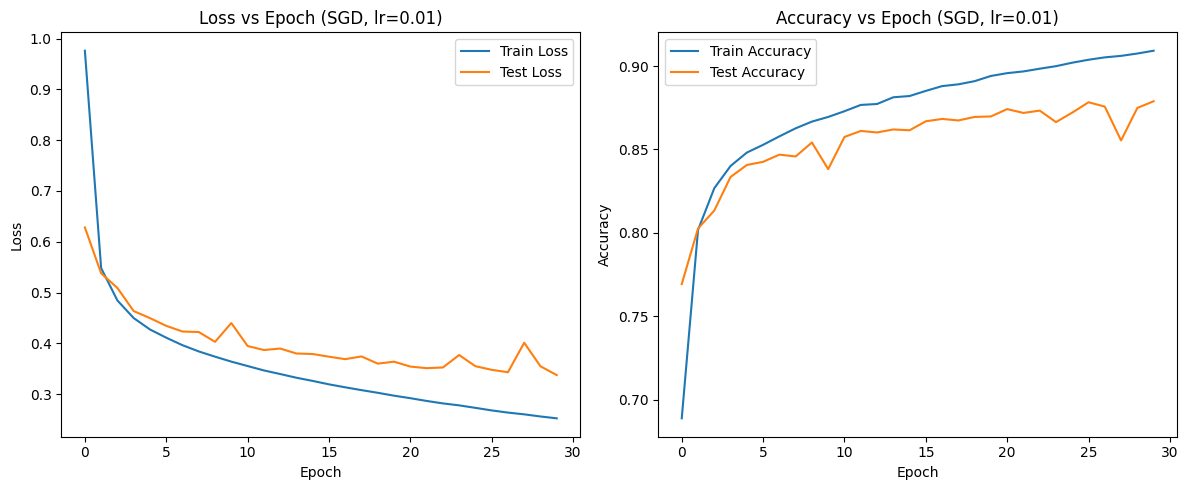

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


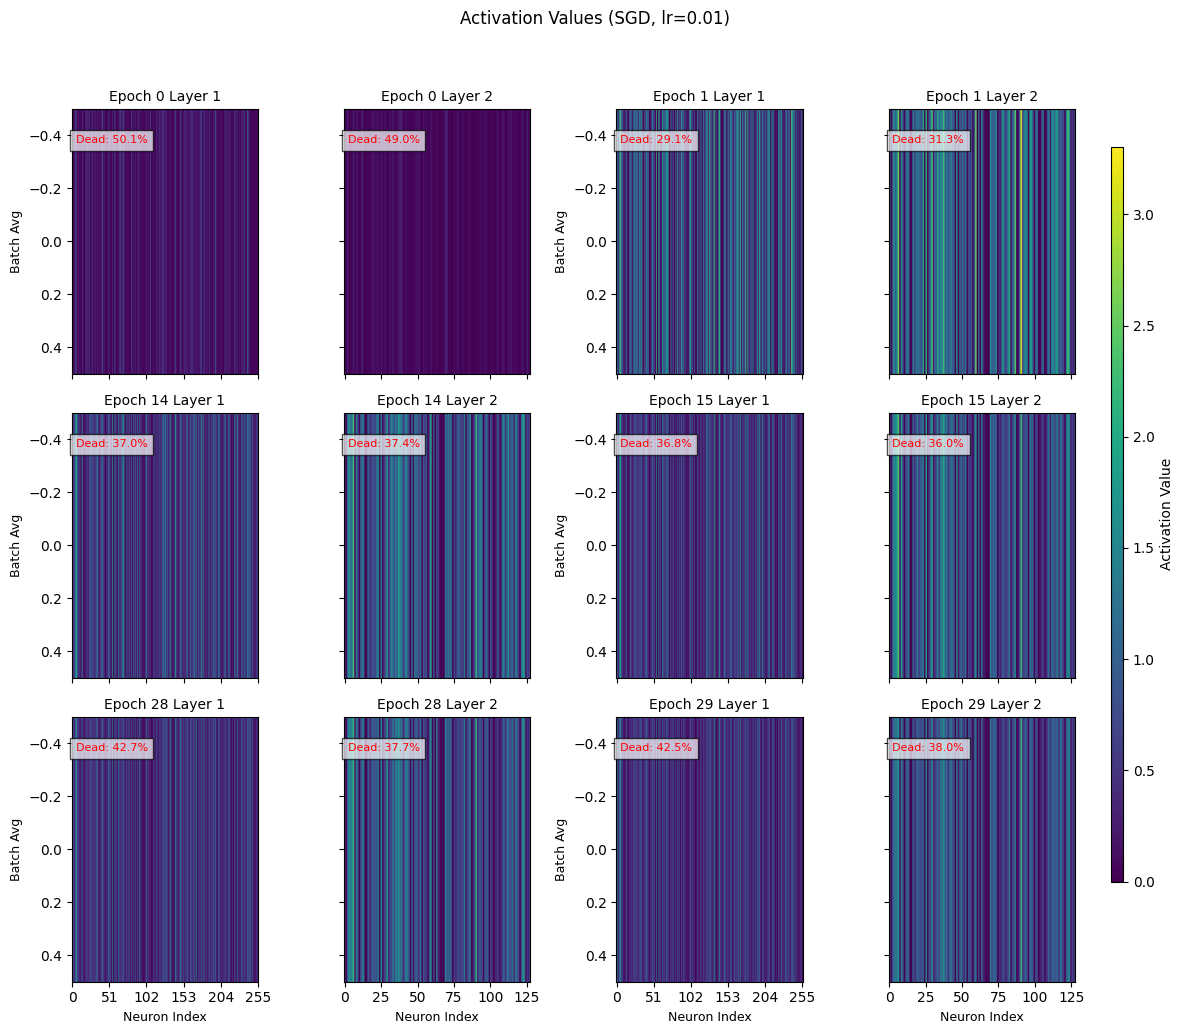

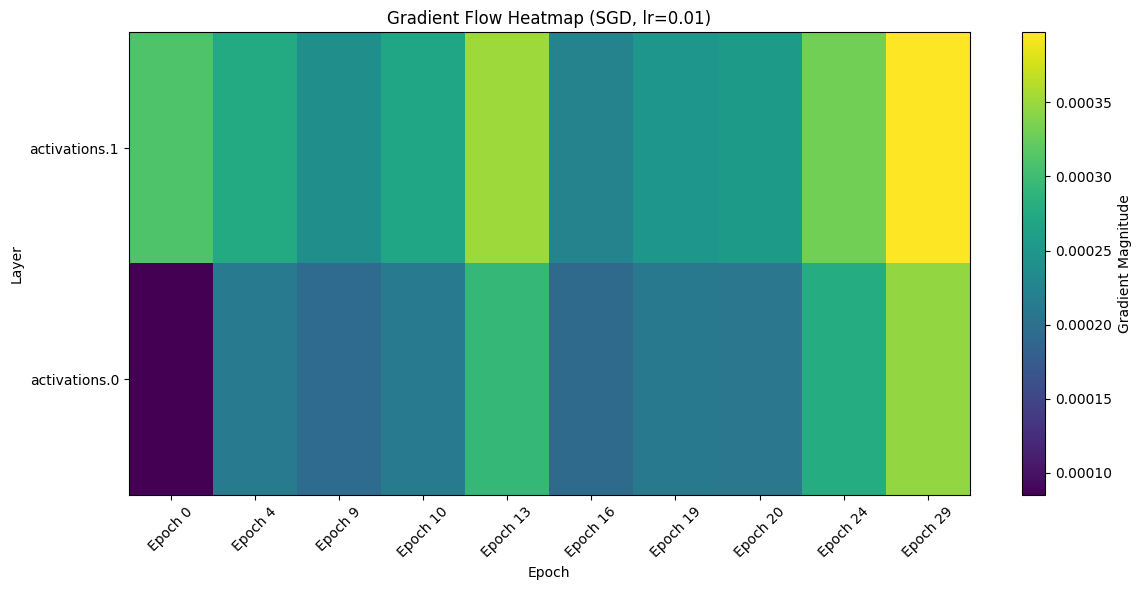


--- SGD (lr=0.001) ---

Epoch [1/30], LR: 0.001000, Train Loss: 2.1189, Test Loss: 1.8742, Train Acc: 0.3982, Test Acc: 0.4725
Epoch [2/30], LR: 0.001000, Train Loss: 1.5515, Test Loss: 1.2750, Train Acc: 0.5532, Test Acc: 0.6586
Epoch [3/30], LR: 0.001000, Train Loss: 1.0992, Test Loss: 0.9751, Train Acc: 0.6878, Test Acc: 0.7073
Epoch [4/30], LR: 0.001000, Train Loss: 0.8887, Test Loss: 0.8358, Train Acc: 0.7225, Test Acc: 0.7243
Epoch [5/30], LR: 0.001000, Train Loss: 0.7840, Test Loss: 0.7615, Train Acc: 0.7362, Test Acc: 0.7375
Epoch [6/30], LR: 0.001000, Train Loss: 0.7234, Test Loss: 0.7144, Train Acc: 0.7471, Test Acc: 0.7457
Epoch [7/30], LR: 0.001000, Train Loss: 0.6834, Test Loss: 0.6816, Train Acc: 0.7555, Test Acc: 0.7537
Epoch [8/30], LR: 0.001000, Train Loss: 0.6537, Test Loss: 0.6568, Train Acc: 0.7646, Test Acc: 0.7609
Epoch [9/30], LR: 0.001000, Train Loss: 0.6304, Test Loss: 0.6361, Train Acc: 0.7712, Test Acc: 0.7664
Epoch [10/30], LR: 0.001000, Train Loss: 0.6106,

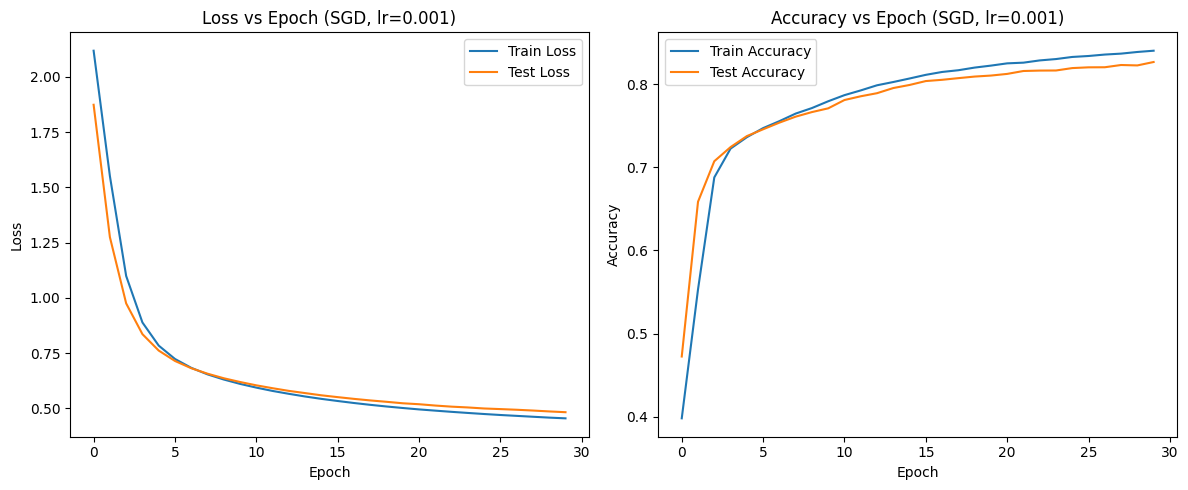

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


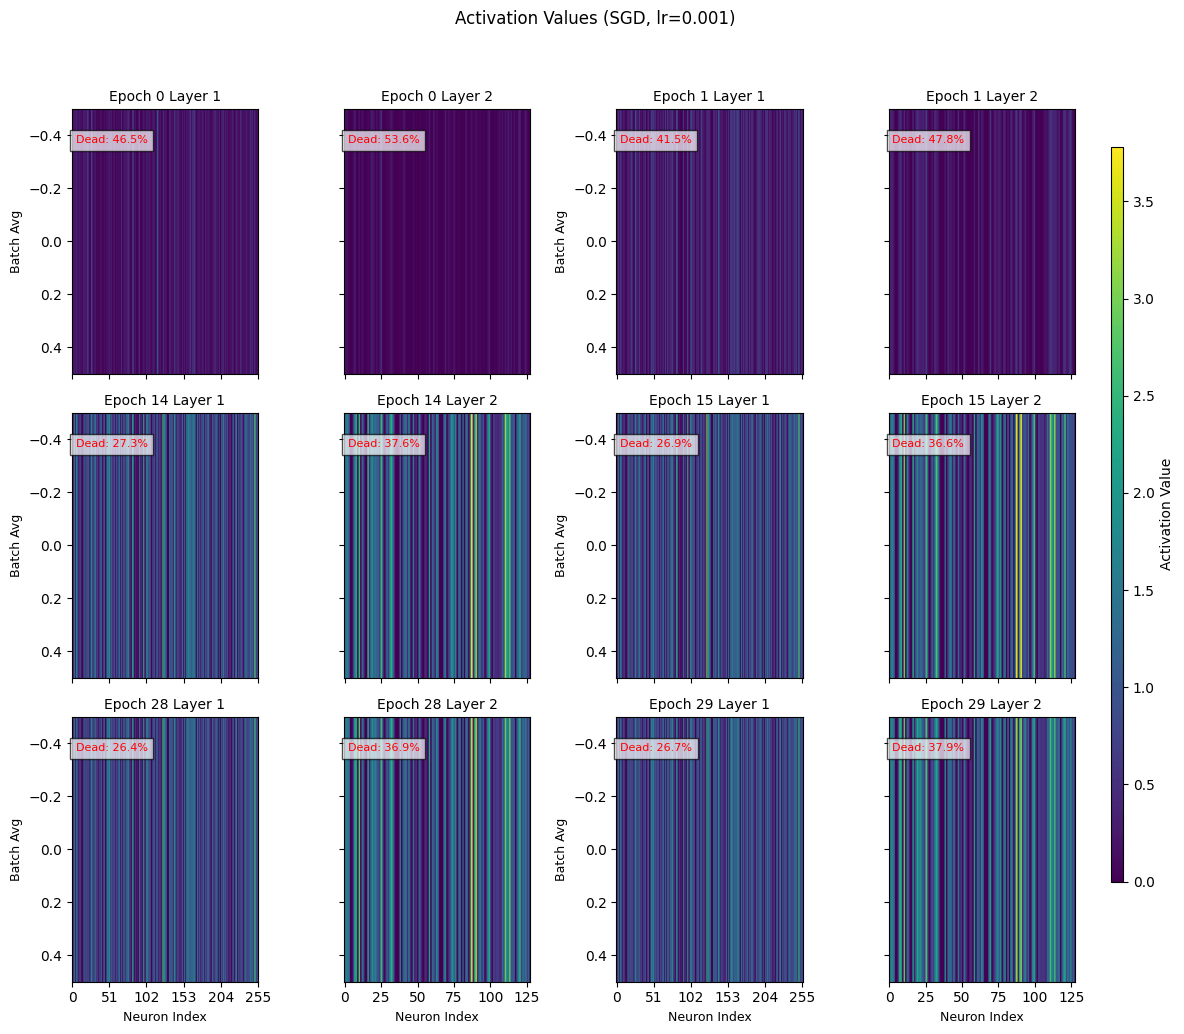

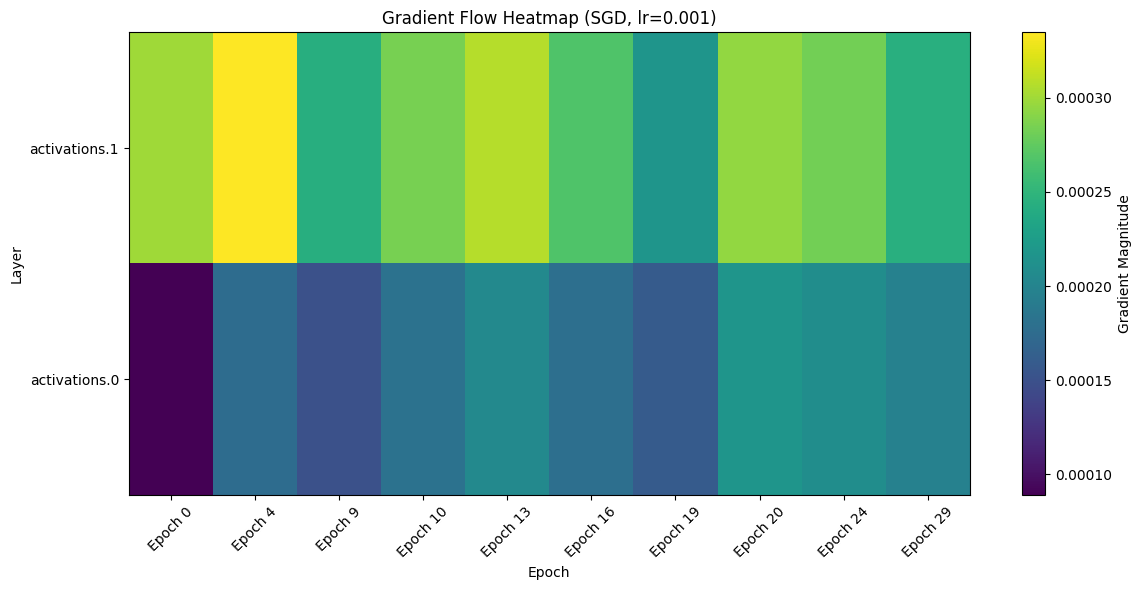


--- SGD+Momentum 학습률 실험 ---


--- SGD+Momentum (lr=0.1, momentum=0.9) ---

Epoch [1/30], LR: 0.100000, Train Loss: 0.6498, Test Loss: 0.5868, Train Acc: 0.7731, Test Acc: 0.7946
Epoch [2/30], LR: 0.100000, Train Loss: 0.5382, Test Loss: 0.5196, Train Acc: 0.8153, Test Acc: 0.8341
Epoch [3/30], LR: 0.100000, Train Loss: 0.4958, Test Loss: 0.5710, Train Acc: 0.8333, Test Acc: 0.8147
Epoch [4/30], LR: 0.100000, Train Loss: 0.4935, Test Loss: 0.5210, Train Acc: 0.8335, Test Acc: 0.8240
Epoch [5/30], LR: 0.100000, Train Loss: 0.4799, Test Loss: 0.4697, Train Acc: 0.8397, Test Acc: 0.8442
Epoch [6/30], LR: 0.100000, Train Loss: 0.4553, Test Loss: 0.5023, Train Acc: 0.8475, Test Acc: 0.8386
Epoch [7/30], LR: 0.100000, Train Loss: 0.4568, Test Loss: 0.4884, Train Acc: 0.8471, Test Acc: 0.8429
Epoch [8/30], LR: 0.100000, Train Loss: 0.4433, Test Loss: 0.5186, Train Acc: 0.8498, Test Acc: 0.8297
Epoch [9/30], LR: 0.100000, Train Loss: 0.4299, Test Loss: 0.4989, Train Acc: 0.8540, Test Acc: 0.83

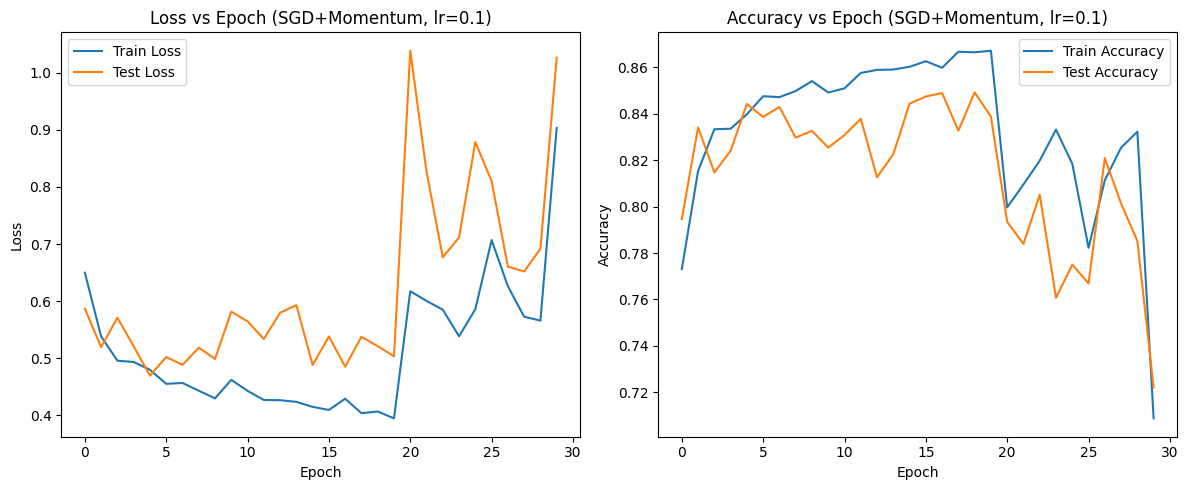

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


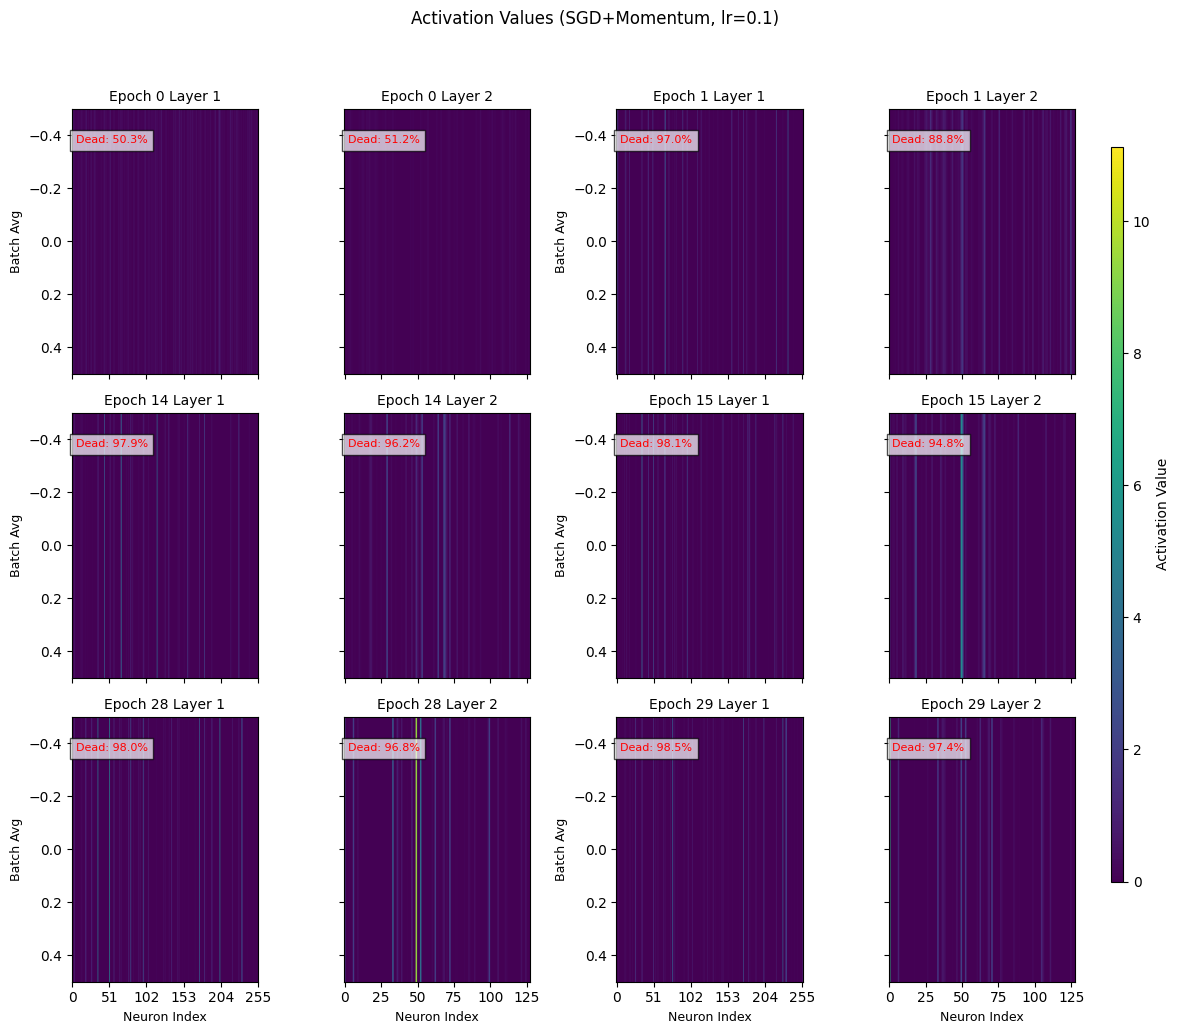

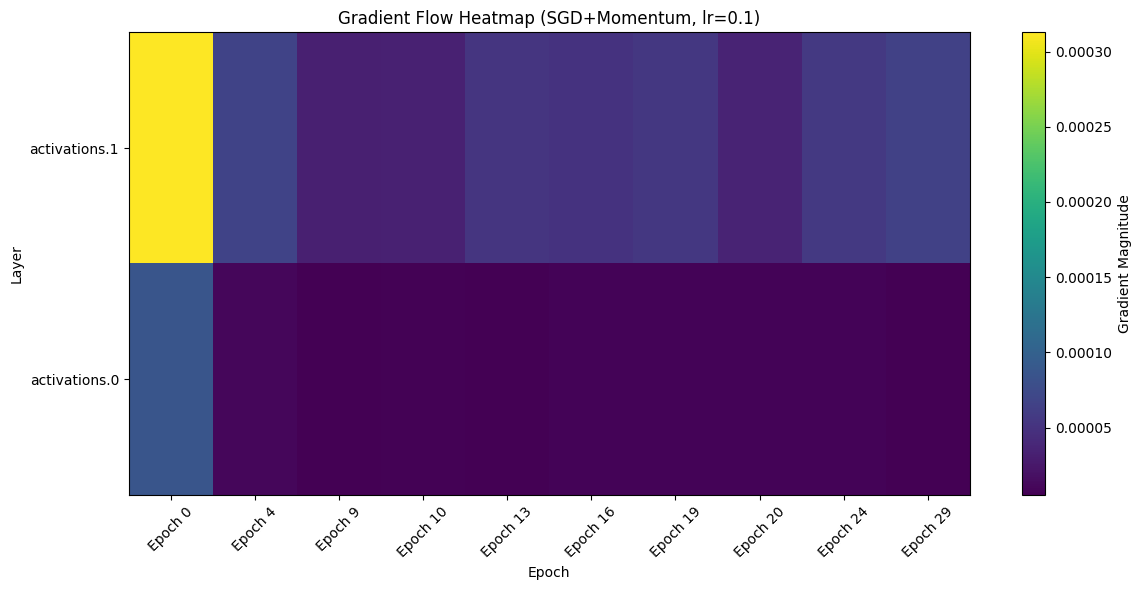


--- SGD+Momentum (lr=0.01, momentum=0.9) ---

Epoch [1/30], LR: 0.010000, Train Loss: 0.5713, Test Loss: 0.4443, Train Acc: 0.7939, Test Acc: 0.8376
Epoch [2/30], LR: 0.010000, Train Loss: 0.3885, Test Loss: 0.3980, Train Acc: 0.8568, Test Acc: 0.8525
Epoch [3/30], LR: 0.010000, Train Loss: 0.3480, Test Loss: 0.3858, Train Acc: 0.8726, Test Acc: 0.8595
Epoch [4/30], LR: 0.010000, Train Loss: 0.3264, Test Loss: 0.3716, Train Acc: 0.8800, Test Acc: 0.8597
Epoch [5/30], LR: 0.010000, Train Loss: 0.3016, Test Loss: 0.3531, Train Acc: 0.8879, Test Acc: 0.8695
Epoch [6/30], LR: 0.010000, Train Loss: 0.2835, Test Loss: 0.3402, Train Acc: 0.8953, Test Acc: 0.8776
Epoch [7/30], LR: 0.010000, Train Loss: 0.2724, Test Loss: 0.3408, Train Acc: 0.8993, Test Acc: 0.8746
Epoch [8/30], LR: 0.010000, Train Loss: 0.2612, Test Loss: 0.3473, Train Acc: 0.9029, Test Acc: 0.8766
Epoch [9/30], LR: 0.010000, Train Loss: 0.2487, Test Loss: 0.3511, Train Acc: 0.9071, Test Acc: 0.8765
Epoch [10/30], LR: 0.01000

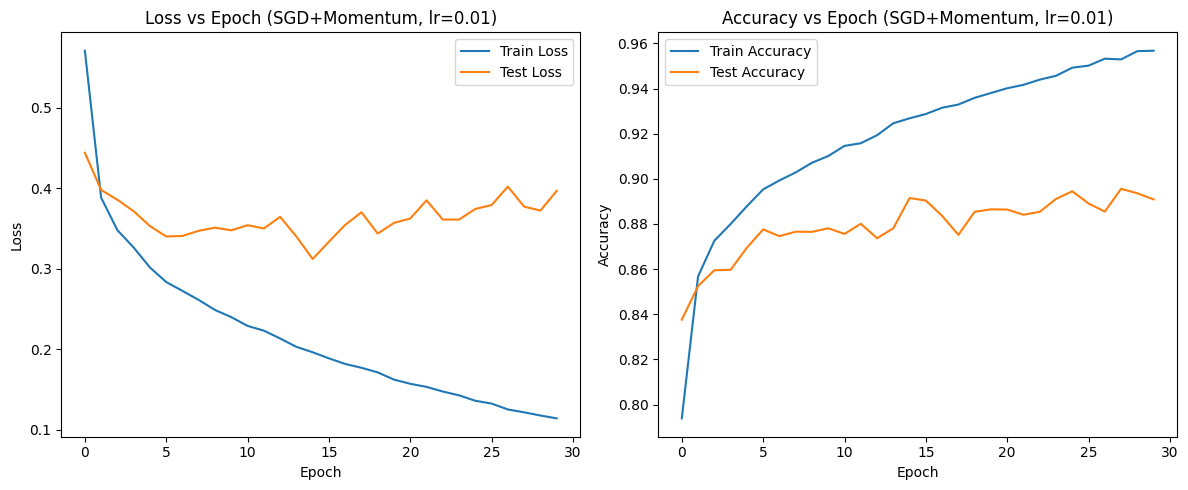

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


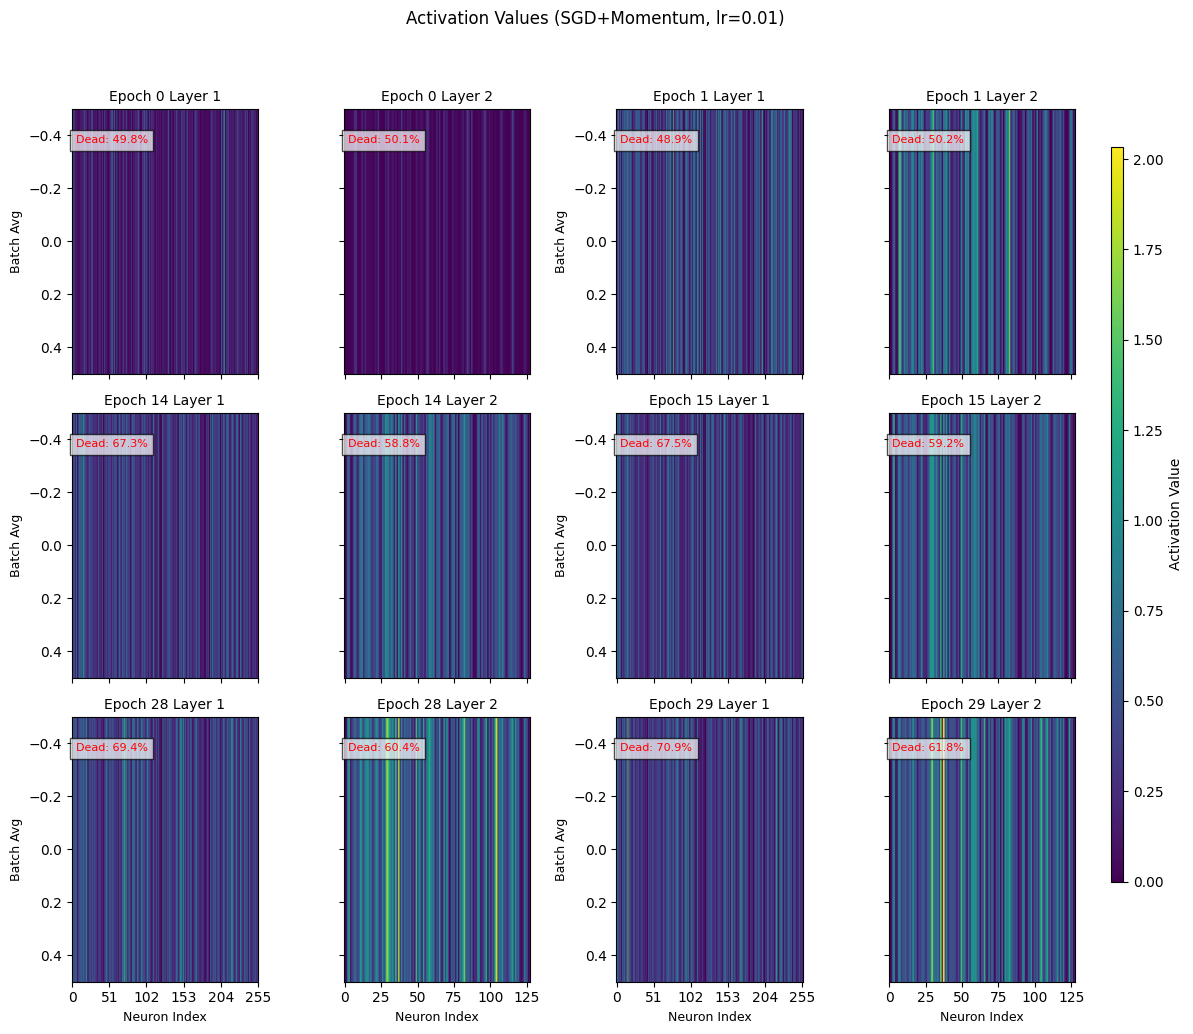

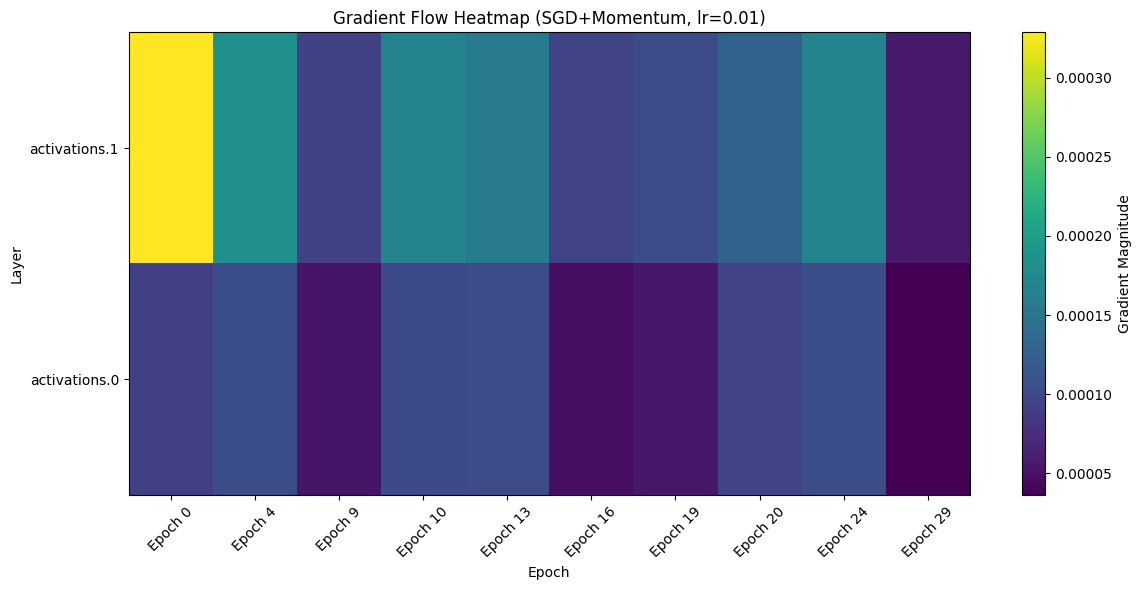


--- SGD+Momentum (lr=0.001, momentum=0.9) ---

Epoch [1/30], LR: 0.001000, Train Loss: 1.0097, Test Loss: 0.6211, Train Acc: 0.6740, Test Acc: 0.7747
Epoch [2/30], LR: 0.001000, Train Loss: 0.5490, Test Loss: 0.5324, Train Acc: 0.8012, Test Acc: 0.8066
Epoch [3/30], LR: 0.001000, Train Loss: 0.4834, Test Loss: 0.4891, Train Acc: 0.8269, Test Acc: 0.8239
Epoch [4/30], LR: 0.001000, Train Loss: 0.4508, Test Loss: 0.4679, Train Acc: 0.8393, Test Acc: 0.8333
Epoch [5/30], LR: 0.001000, Train Loss: 0.4288, Test Loss: 0.4511, Train Acc: 0.8474, Test Acc: 0.8371
Epoch [6/30], LR: 0.001000, Train Loss: 0.4116, Test Loss: 0.4521, Train Acc: 0.8530, Test Acc: 0.8370
Epoch [7/30], LR: 0.001000, Train Loss: 0.3973, Test Loss: 0.4263, Train Acc: 0.8580, Test Acc: 0.8449
Epoch [8/30], LR: 0.001000, Train Loss: 0.3844, Test Loss: 0.4193, Train Acc: 0.8636, Test Acc: 0.8483
Epoch [9/30], LR: 0.001000, Train Loss: 0.3736, Test Loss: 0.4121, Train Acc: 0.8668, Test Acc: 0.8498
Epoch [10/30], LR: 0.0010

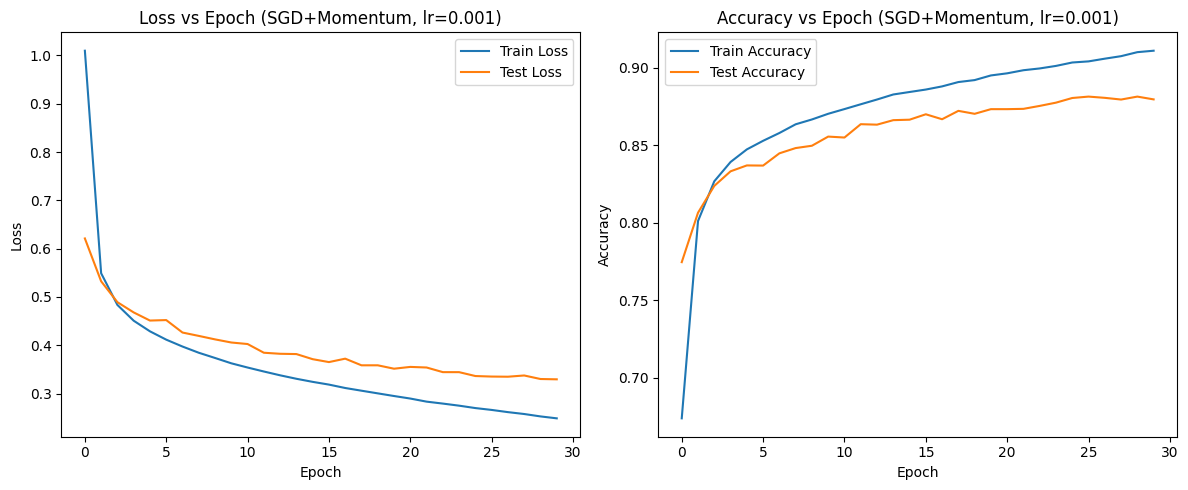

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


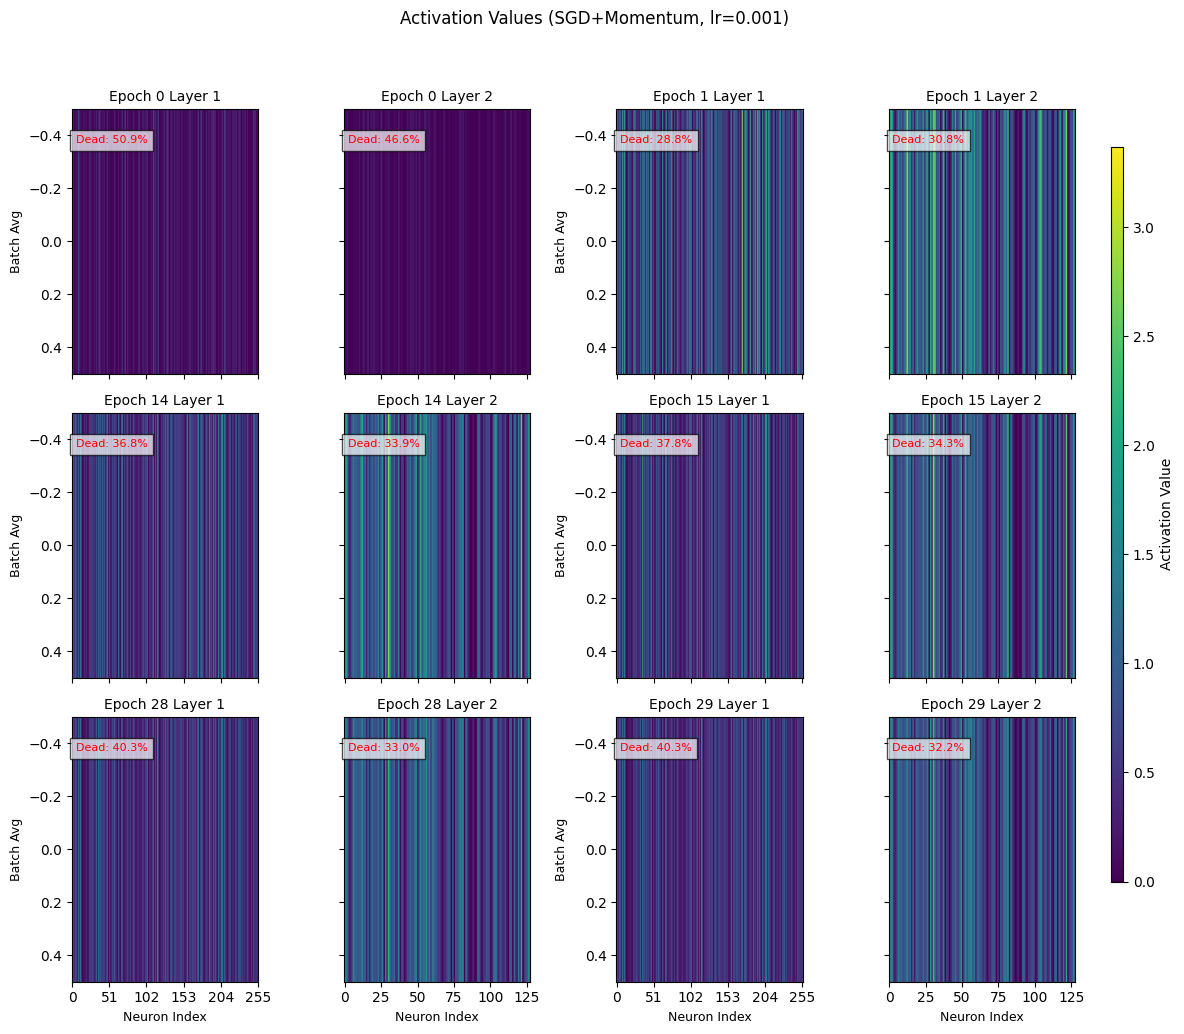

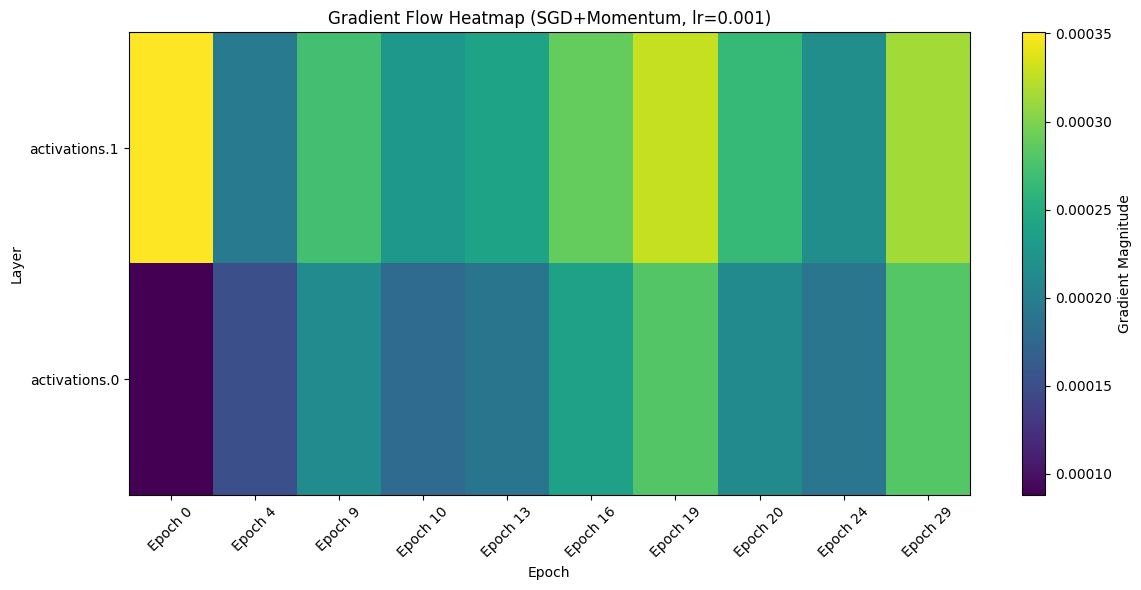


--- Adam 학습률 실험 ---


--- Adam (lr=0.1) ---

Epoch [1/30], LR: 0.100000, Train Loss: 3.7685, Test Loss: 2.3093, Train Acc: 0.2021, Test Acc: 0.1007
Epoch [2/30], LR: 0.100000, Train Loss: 2.5522, Test Loss: 2.3185, Train Acc: 0.1046, Test Acc: 0.1000
Epoch [3/30], LR: 0.100000, Train Loss: 2.9002, Test Loss: 2.5130, Train Acc: 0.1010, Test Acc: 0.1000
Epoch [4/30], LR: 0.100000, Train Loss: 2.3154, Test Loss: 2.5755, Train Acc: 0.0998, Test Acc: 0.1000
Epoch [5/30], LR: 0.100000, Train Loss: 2.3115, Test Loss: 2.5704, Train Acc: 0.1008, Test Acc: 0.1000
Epoch [6/30], LR: 0.100000, Train Loss: 2.3122, Test Loss: 2.5719, Train Acc: 0.1017, Test Acc: 0.1000
Epoch [7/30], LR: 0.100000, Train Loss: 2.3113, Test Loss: 2.5778, Train Acc: 0.1024, Test Acc: 0.1000
Epoch [8/30], LR: 0.100000, Train Loss: 2.3127, Test Loss: 2.5680, Train Acc: 0.1003, Test Acc: 0.1000
Epoch [9/30], LR: 0.100000, Train Loss: 2.3106, Test Loss: 2.5704, Train Acc: 0.1002, Test Acc: 0.1000
Epoch [10/30], LR: 0.100000

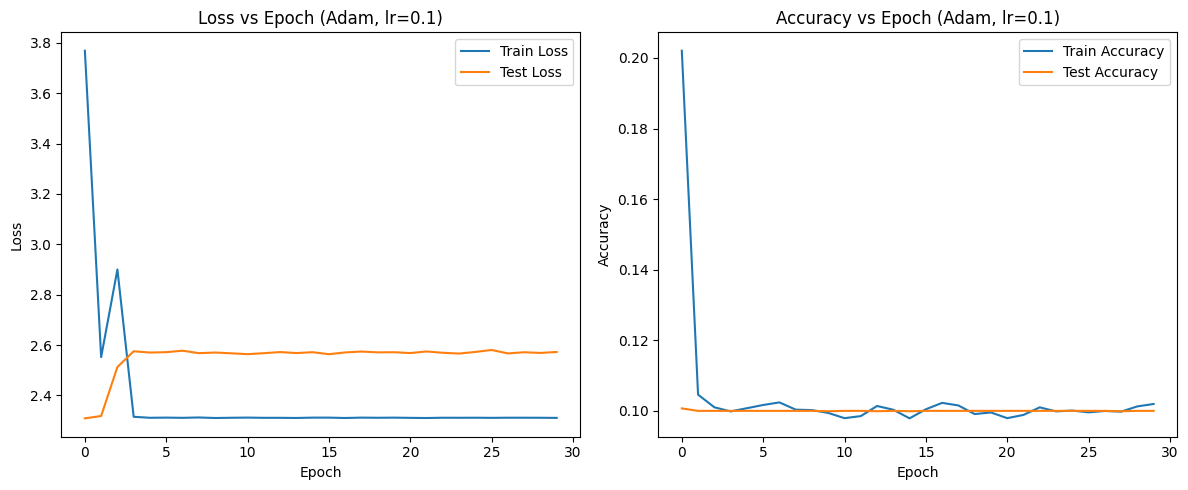

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


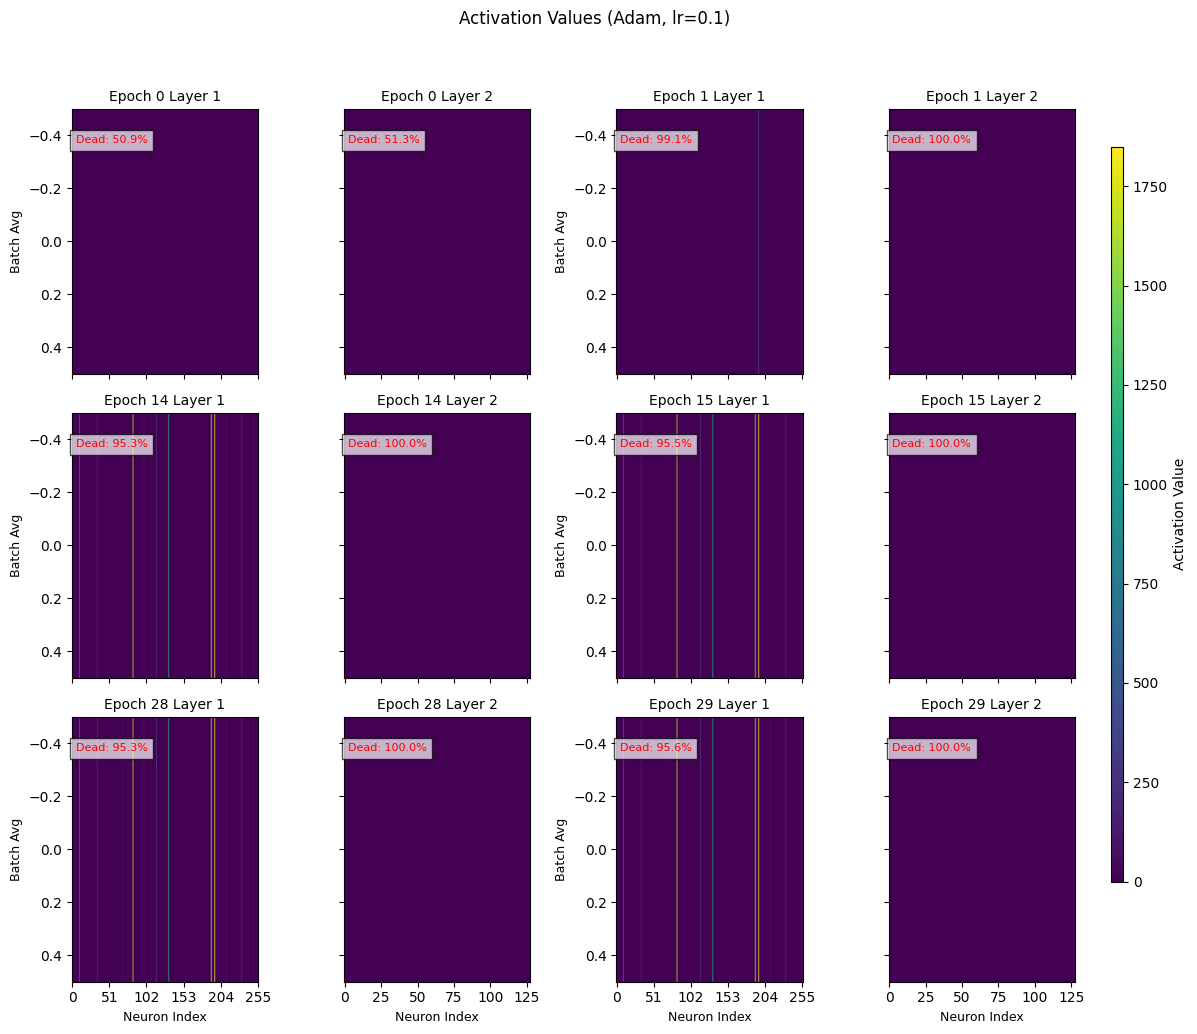

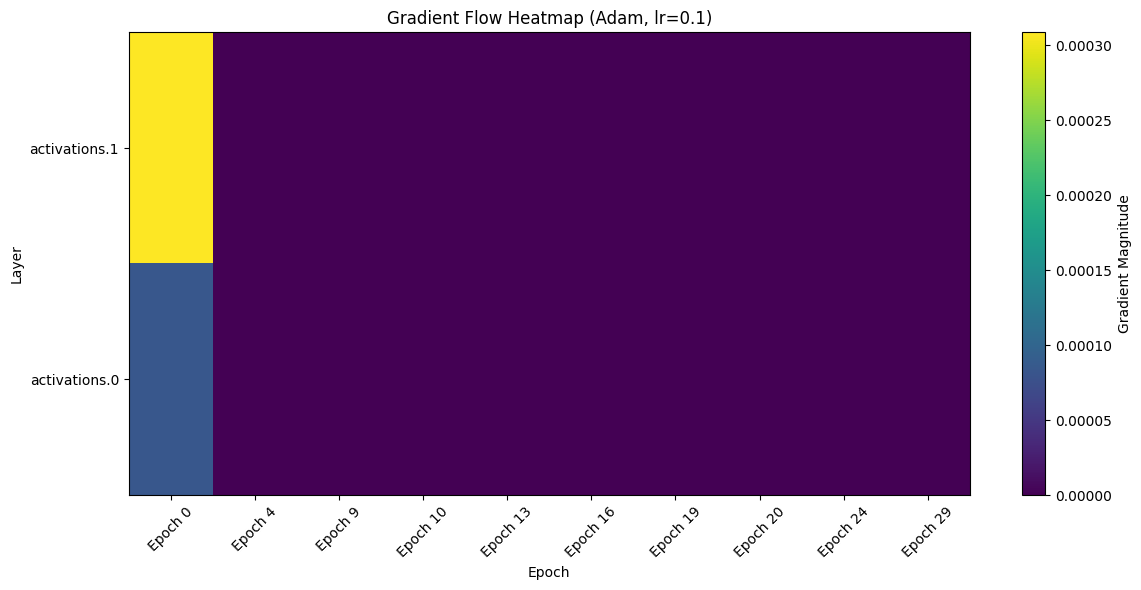


--- Adam (lr=0.01) ---

Epoch [1/30], LR: 0.010000, Train Loss: 0.5493, Test Loss: 0.4812, Train Acc: 0.8045, Test Acc: 0.8277
Epoch [2/30], LR: 0.010000, Train Loss: 0.4375, Test Loss: 0.4934, Train Acc: 0.8441, Test Acc: 0.8245
Epoch [3/30], LR: 0.010000, Train Loss: 0.4169, Test Loss: 0.4516, Train Acc: 0.8528, Test Acc: 0.8421
Epoch [4/30], LR: 0.010000, Train Loss: 0.4021, Test Loss: 0.4316, Train Acc: 0.8578, Test Acc: 0.8466
Epoch [5/30], LR: 0.010000, Train Loss: 0.3883, Test Loss: 0.4439, Train Acc: 0.8637, Test Acc: 0.8534
Epoch [6/30], LR: 0.010000, Train Loss: 0.3853, Test Loss: 0.4313, Train Acc: 0.8650, Test Acc: 0.8505
Epoch [7/30], LR: 0.010000, Train Loss: 0.3763, Test Loss: 0.4327, Train Acc: 0.8677, Test Acc: 0.8462
Epoch [8/30], LR: 0.010000, Train Loss: 0.3679, Test Loss: 0.4864, Train Acc: 0.8703, Test Acc: 0.8358
Epoch [9/30], LR: 0.010000, Train Loss: 0.3672, Test Loss: 0.4636, Train Acc: 0.8697, Test Acc: 0.8394
Epoch [10/30], LR: 0.010000, Train Loss: 0.3680,

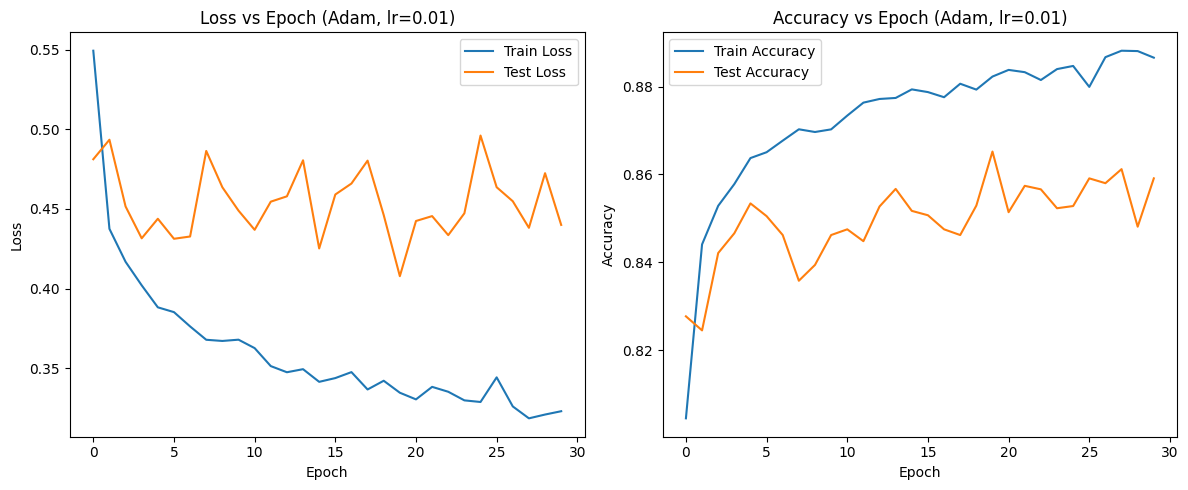

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


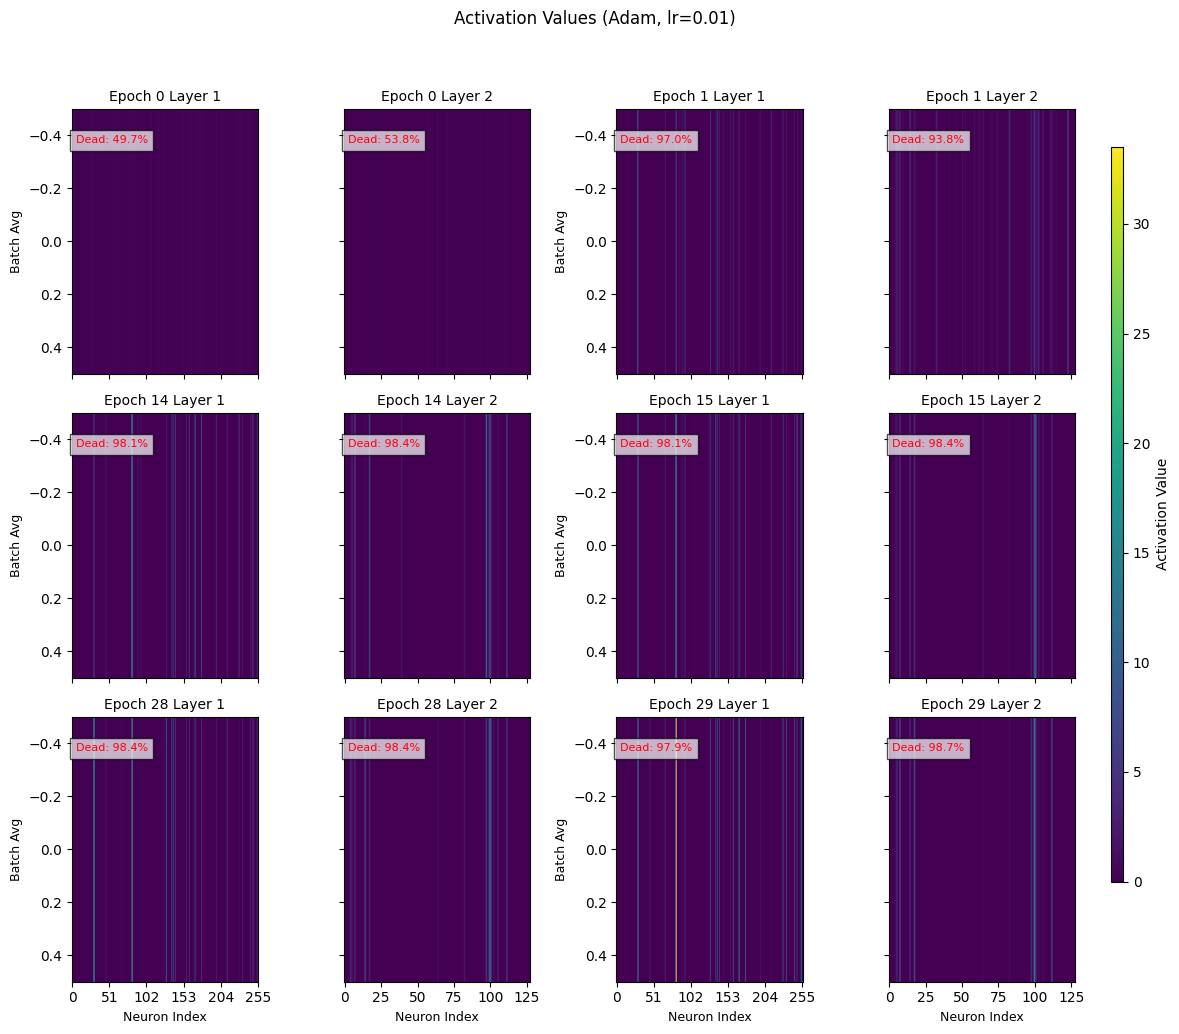

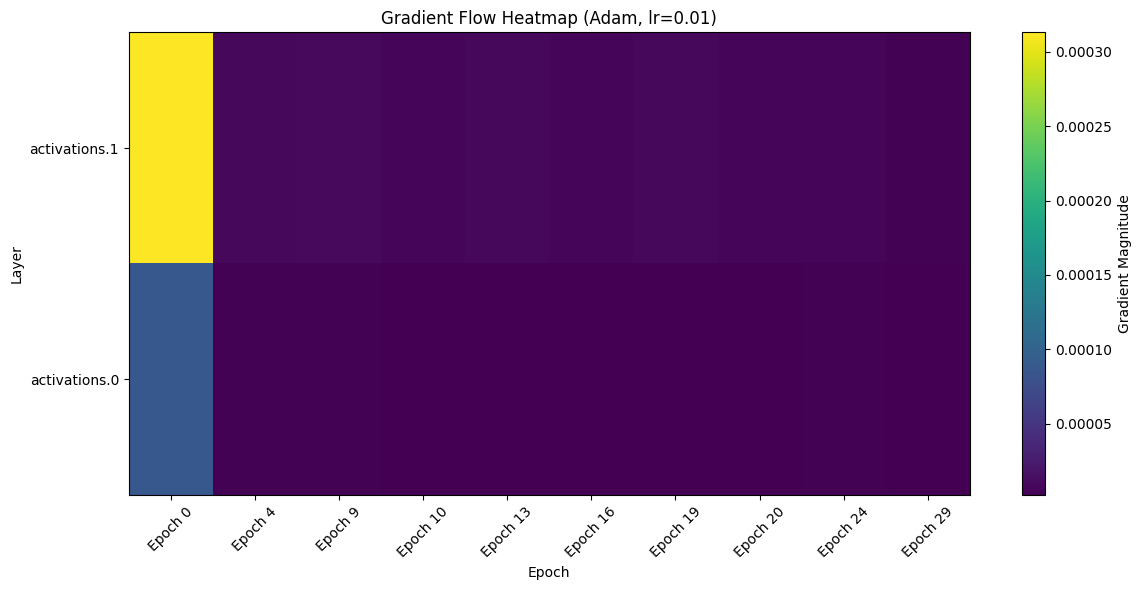


--- Adam (lr=0.001) ---

Epoch [1/30], LR: 0.001000, Train Loss: 0.4931, Test Loss: 0.4117, Train Acc: 0.8208, Test Acc: 0.8496
Epoch [2/30], LR: 0.001000, Train Loss: 0.3703, Test Loss: 0.3826, Train Acc: 0.8634, Test Acc: 0.8595
Epoch [3/30], LR: 0.001000, Train Loss: 0.3316, Test Loss: 0.3820, Train Acc: 0.8781, Test Acc: 0.8627
Epoch [4/30], LR: 0.001000, Train Loss: 0.3053, Test Loss: 0.3845, Train Acc: 0.8873, Test Acc: 0.8605
Epoch [5/30], LR: 0.001000, Train Loss: 0.2869, Test Loss: 0.3378, Train Acc: 0.8933, Test Acc: 0.8811
Epoch [6/30], LR: 0.001000, Train Loss: 0.2679, Test Loss: 0.3508, Train Acc: 0.8999, Test Acc: 0.8776
Epoch [7/30], LR: 0.001000, Train Loss: 0.2559, Test Loss: 0.3365, Train Acc: 0.9039, Test Acc: 0.8825
Epoch [8/30], LR: 0.001000, Train Loss: 0.2442, Test Loss: 0.3435, Train Acc: 0.9083, Test Acc: 0.8781
Epoch [9/30], LR: 0.001000, Train Loss: 0.2308, Test Loss: 0.3431, Train Acc: 0.9122, Test Acc: 0.8786
Epoch [10/30], LR: 0.001000, Train Loss: 0.2211

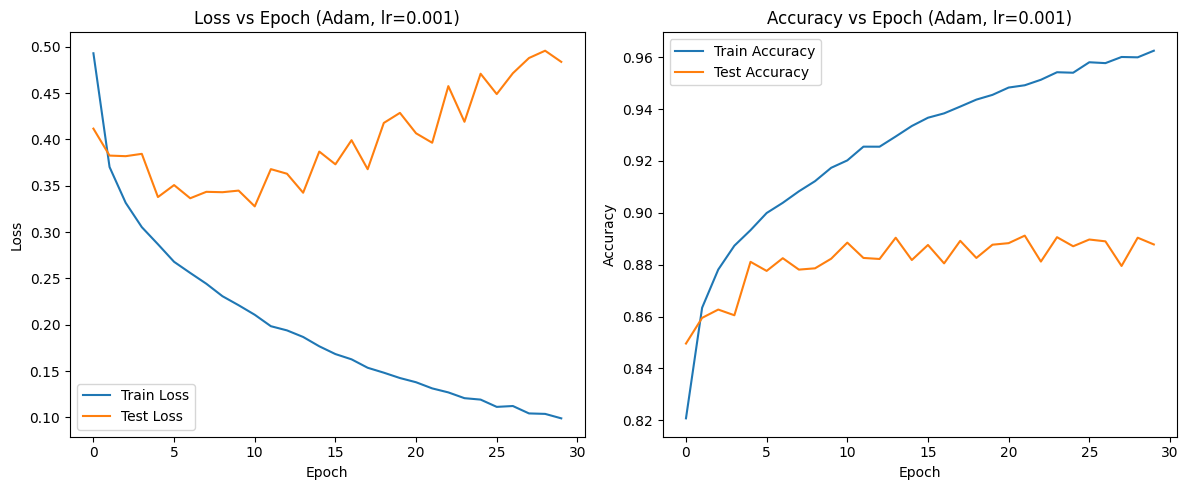

<ipython-input-1-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


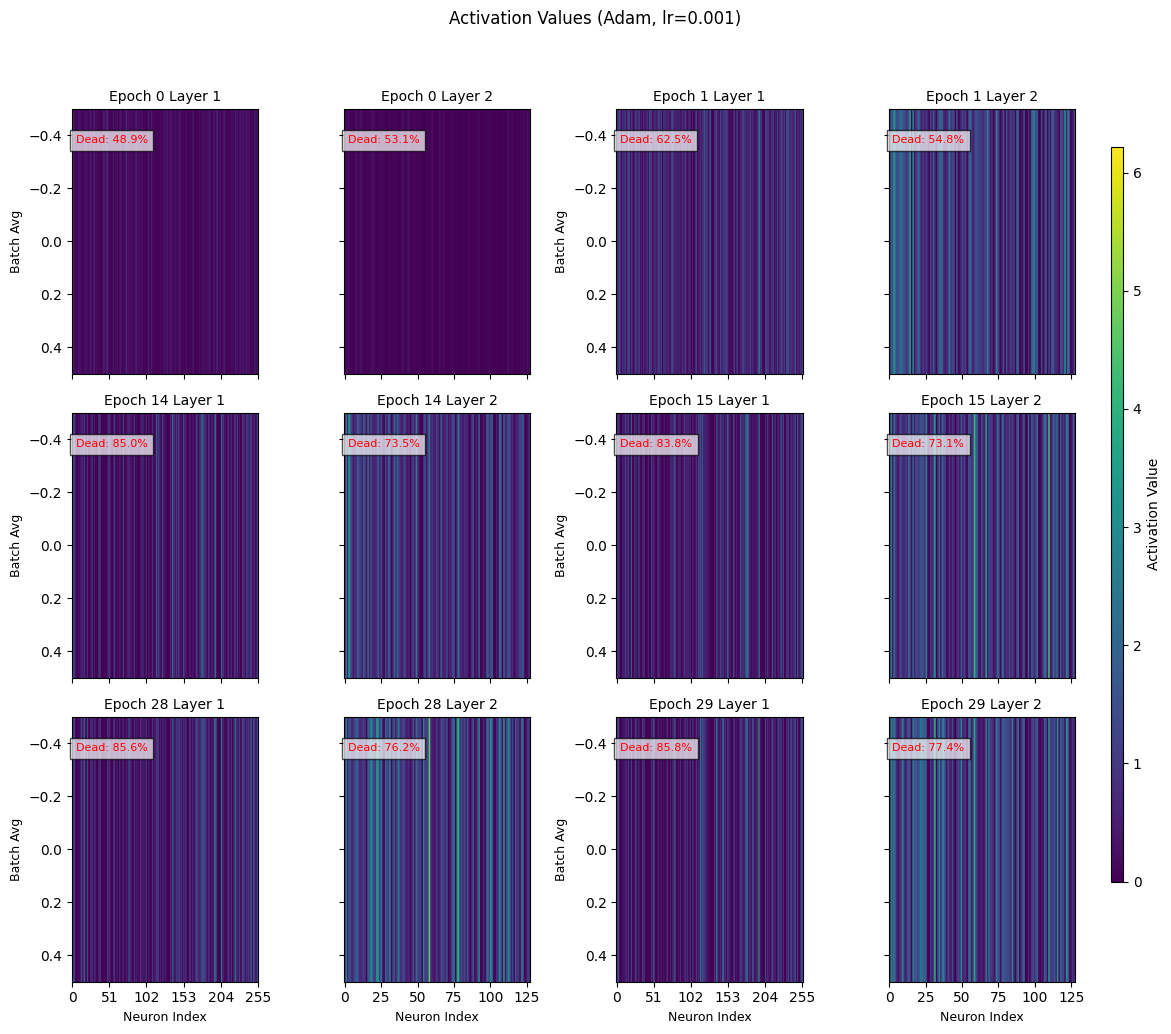

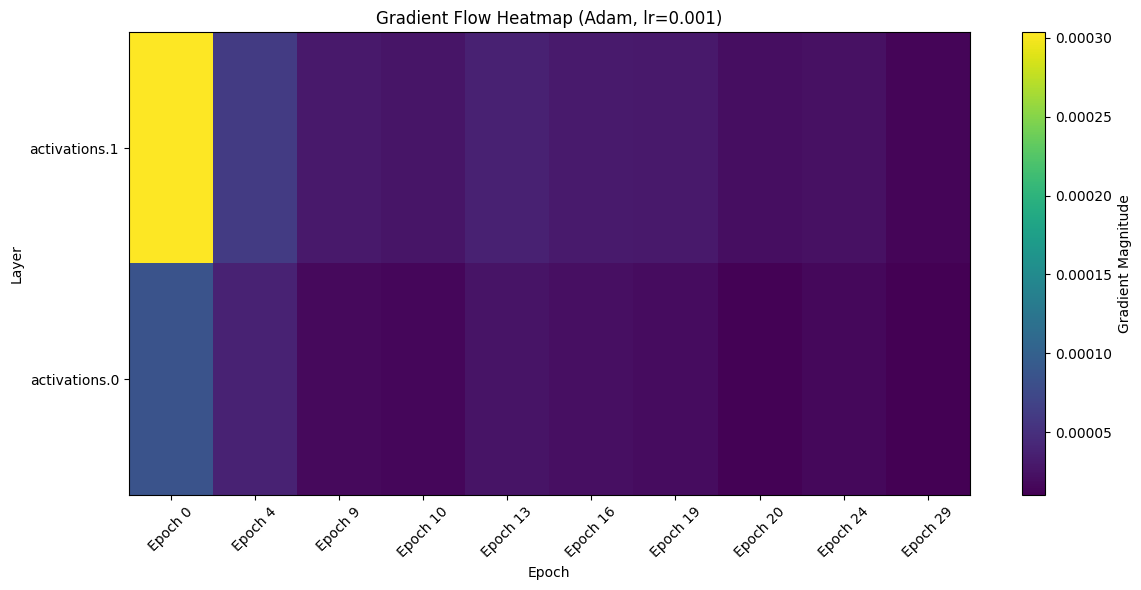

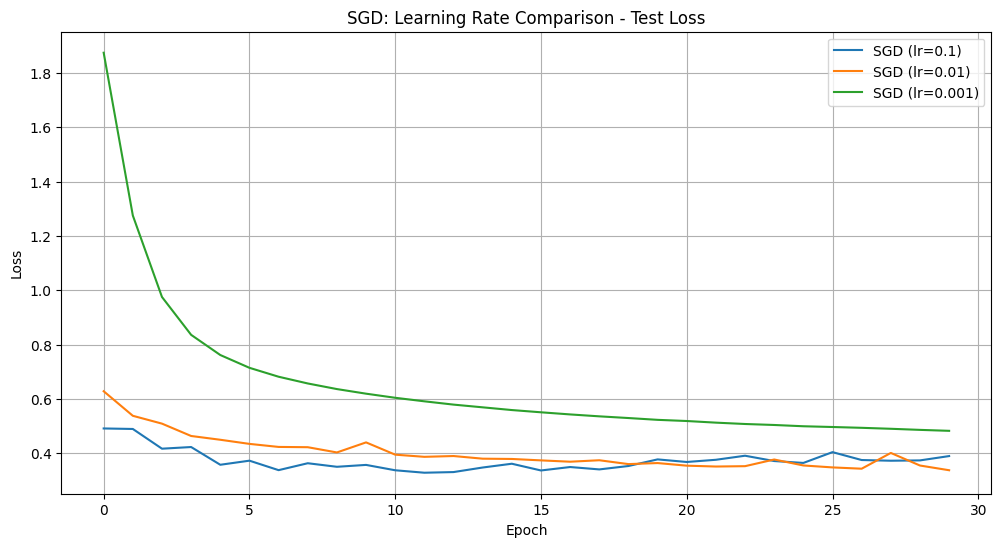

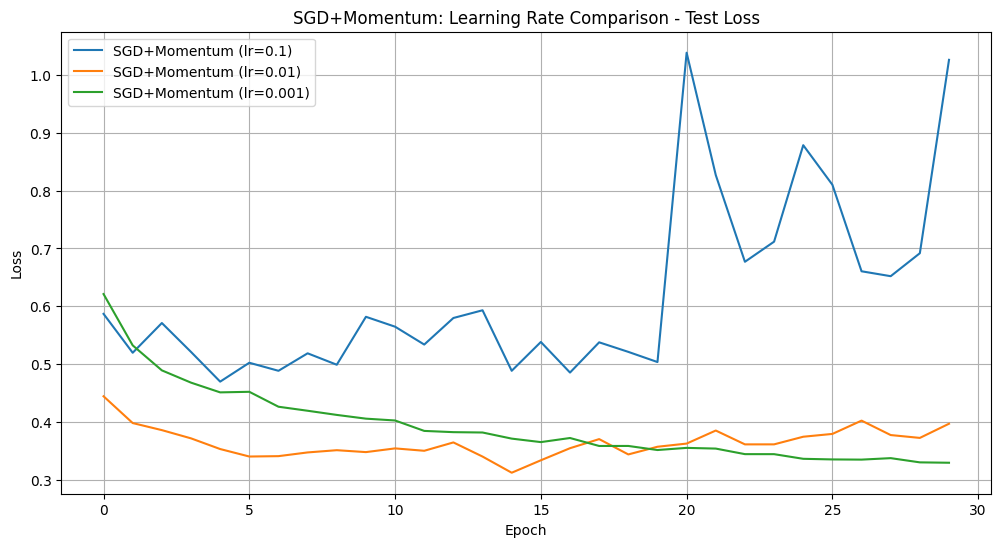

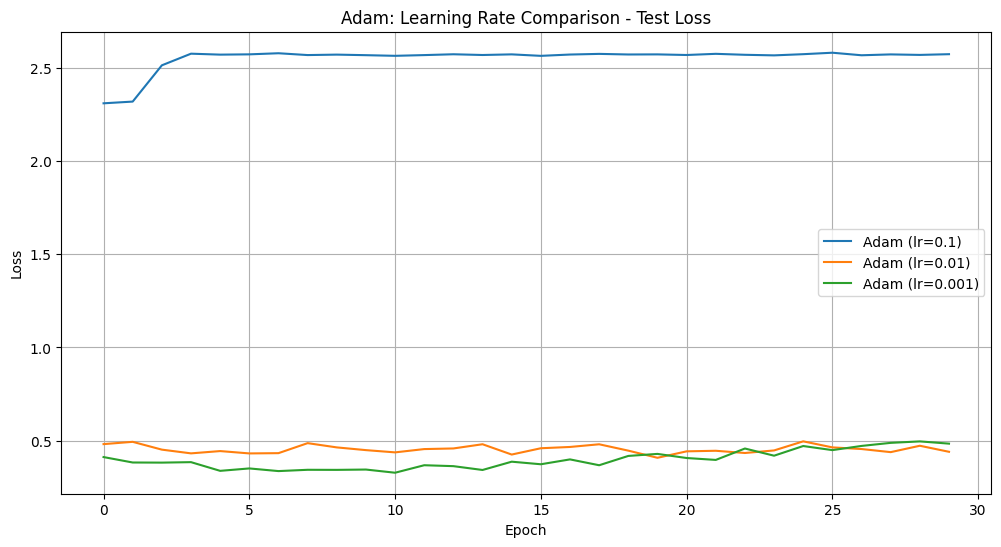

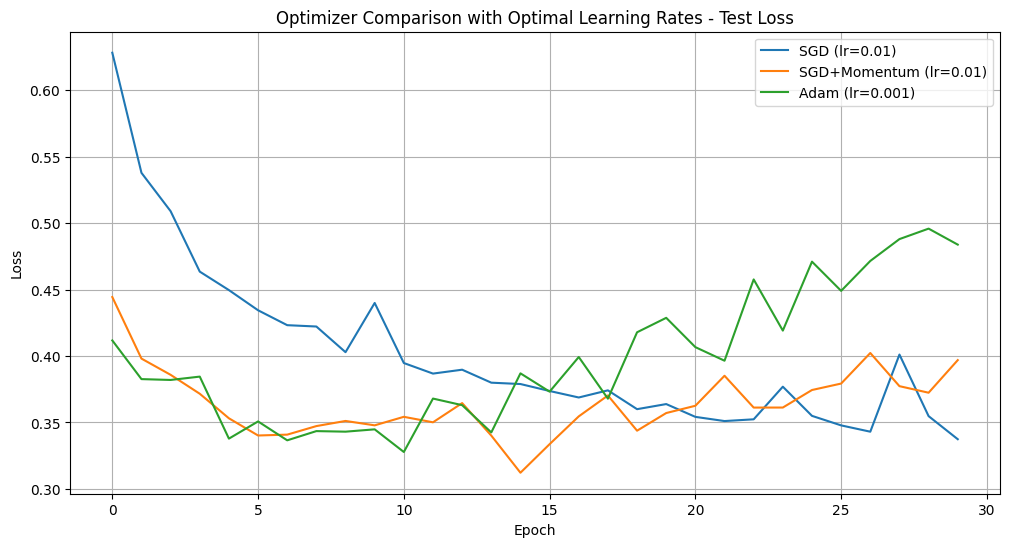

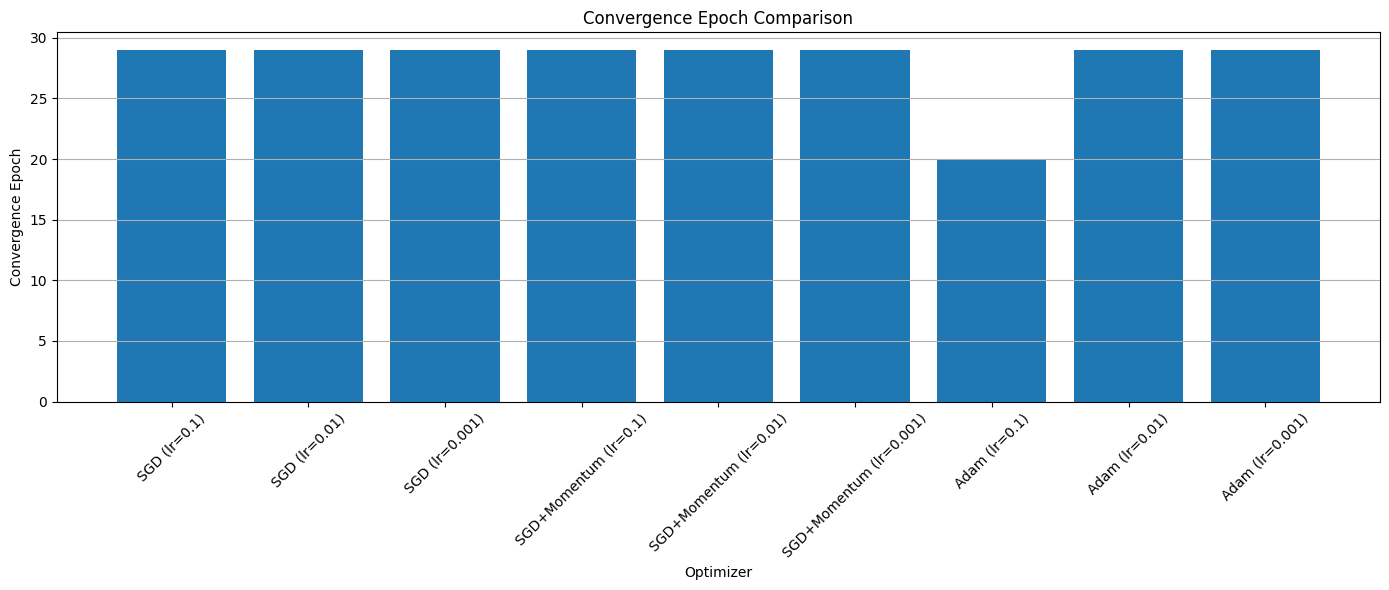


==== 수렴 속도 비교 ====

SGD (lr=0.1): 29 에폭에서 수렴
SGD (lr=0.01): 29 에폭에서 수렴
SGD (lr=0.001): 29 에폭에서 수렴
SGD+Momentum (lr=0.1): 29 에폭에서 수렴
SGD+Momentum (lr=0.01): 29 에폭에서 수렴
SGD+Momentum (lr=0.001): 29 에폭에서 수렴
Adam (lr=0.1): 20 에폭에서 수렴
Adam (lr=0.01): 29 에폭에서 수렴
Adam (lr=0.001): 29 에폭에서 수렴

실험 C 완료: 결과는 expC_results 디렉토리에 저장되었습니다.



In [ ]:
# 옵티마이저 실험용 모델 학습 함수
def train_model_optimizer(model, train_loader, test_loader, criterion, optimizer, lr_scheduler=None, num_epochs=30):
    """
    모델 학습 함수 - 옵티마이저 실험용
    """
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    lr_history = []  # 학습률 변화 기록

    # 활성화값과 그래디언트 훅 등록
    act_grad_hook = ActivationGradientHook()
    act_grad_hook.register_hooks(model)

    # 각 에폭별 활성화값과 그래디언트 저장용
    activation_history = {epoch: {} for epoch in range(num_epochs)}
    gradient_history = {epoch: {} for epoch in range(num_epochs)}
    dead_relu_history = {epoch: {} for epoch in range(num_epochs)}

    for epoch in range(num_epochs):
        # 현재 학습률 저장
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        # 학습
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, layer_outputs, activation_outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 자동 미분 사용
            optimizer.step()  # optimizer 업데이트

            train_loss += loss.item()  # loss 계산
            _, predicted = torch.max(outputs.data, 1)  # 최대값 인덱스 -> y^ (예측한 클래스)
            train_preds.extend(predicted.cpu().numpy())  # y^ -> numpy
            train_labels.extend(labels.cpu().numpy())  # y -> numpy

            # 활성화값, 그래디언트 저장. 메모리 한계와 미니 배치의 특성상 첫 번째 배치에서만 저장하도록 구성
            if batch_idx == 0:
                # 활성화값 저장
                for i, act in enumerate(activation_outputs):
                    activation_history[epoch][f'layer_{i+1}'] = act.detach().cpu().numpy()
                    # Dead ReLU 계산, 0인 비율을 계산하면 됨
                    dead_relu_history[epoch][f'layer_{i+1}'] = (act == 0).float().mean().item()

                # 그래디언트
                for name, gradient in act_grad_hook.gradients.items():
                    gradient_history[epoch][name] = gradient.numpy()

                # 메모리 정리용
                act_grad_hook.clear()

        # model.eval 사용
        model.eval()
        test_loss = 0
        test_preds = []
        test_labels = []

        with torch.no_grad():  # gradient 계산 X
            for inputs, labels in test_loader:  # 테스트 데이터 로드
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _, _ = model(inputs)  # 예측값 계산
                loss = criterion(outputs, labels)  # loss 계산
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)  # 예측 결과
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # 결과 계산
        train_loss = train_loss / len(train_loader)
        test_loss = test_loss / len(test_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        test_acc = accuracy_score(test_labels, test_preds)

        # 결과 저장
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'LR: {current_lr:.6f}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Test Acc: {test_acc:.4f}')

        # 학습률 스케줄러 업데이트
        if lr_scheduler is not None:
            lr_scheduler.step()

    # 훅 제거
    act_grad_hook.remove_hooks()

    return train_losses, test_losses, train_accs, test_accs, activation_history, gradient_history, dead_relu_history, lr_history

# 실험 C 함수: 최적화 알고리즘 비교
def run_experiment_C():
    print("\n===== 실험 C: 최적화 알고리즘 비교 (SGD, SGD+Momentum, Adam) =====\n")

    # 결과 저장 디렉토리 생성
    if not os.path.exists("expC_results"):
        os.makedirs("expC_results")

    # 학습 에폭 수 설정
    num_epochs = 30

    # 손실 함수 설정 (CrossEntropy 사용)
    loss_fn = nn.CrossEntropyLoss()

    # 학습률 설정
    learning_rates = [0.1, 0.01, 0.001]

    # 결과 저장 딕셔너리
    sgd_results = {}
    momentum_results = {}
    adam_results = {}

    # 1. SGD 학습률 실험 (3개)
    print("\n--- SGD 학습률 실험 ---\n")

    for lr in learning_rates:
        print(f"\n--- SGD (lr={lr}) ---\n")
        model = MLP().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)

        results = train_model_optimizer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=loss_fn,
            optimizer=optimizer,
            num_epochs=num_epochs
        )

        sgd_results[lr] = results

        # 개별 결과 시각화
        plot_learning_curves(
            results[0], results[1], results[2], results[3],
            title_suffix=f"(SGD, lr={lr})",
            save_dir=f"expC_results/SGD_lr_{lr}"
        )
        # 활성화값과 그래디언트 히트맵 시각화
        plot_activation_heatmap(
            results[4],
            title_suffix=f"(SGD, lr={lr})",
            save_dir=f"expC_results/SGD_lr_{lr}"
        )

        plot_gradient_flow_heatmap(
            results[5],
            title_suffix=f"(SGD, lr={lr})",
            save_dir=f"expC_results/SGD_lr_{lr}"
        )

    # 2. SGD+Momentum 학습률 실험 (3개)
    print("\n--- SGD+Momentum 학습률 실험 ---\n")

    for lr in learning_rates:
        print(f"\n--- SGD+Momentum (lr={lr}, momentum=0.9) ---\n")
        model = MLP().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        results = train_model_optimizer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=loss_fn,
            optimizer=optimizer,
            num_epochs=num_epochs
        )

        momentum_results[lr] = results

        # 개별 결과 시각화
        plot_learning_curves(
            results[0], results[1], results[2], results[3],
            title_suffix=f"(SGD+Momentum, lr={lr})",
            save_dir=f"expC_results/SGD_Momentum_lr_{lr}"
        )
        # 활성화값과 그래디언트 히트맵 시각화
        plot_activation_heatmap(
            results[4],
            title_suffix=f"(SGD+Momentum, lr={lr})",
            save_dir=f"expC_results/SGD_Momentum_lr_{lr}"
        )

        plot_gradient_flow_heatmap(
            results[5],
            title_suffix=f"(SGD+Momentum, lr={lr})",
            save_dir=f"expC_results/SGD_Momentum_lr_{lr}"
        )

    # 3. Adam 학습률 실험 (3개)
    print("\n--- Adam 학습률 실험 ---\n")

    for lr in learning_rates:
        print(f"\n--- Adam (lr={lr}) ---\n")
        model = MLP().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        results = train_model_optimizer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=loss_fn,
            optimizer=optimizer,
            num_epochs=num_epochs
        )

        adam_results[lr] = results

        # 개별 결과 시각화
        plot_learning_curves(
            results[0], results[1], results[2], results[3],
            title_suffix=f"(Adam, lr={lr})",
            save_dir=f"expC_results/Adam_lr_{lr}"
        )
        # 활성화값과 그래디언트 히트맵 시각화
        plot_activation_heatmap(
            results[4],
            title_suffix=f"(Adam, lr={lr})",
            save_dir=f"expC_results/Adam_lr_{lr}"
        )

        plot_gradient_flow_heatmap(
            results[5],
            title_suffix=f"(Adam, lr={lr})",
            save_dir=f"expC_results/Adam_lr_{lr}"
        )

    # 각 최적화 알고리즘별 학습률에 따른 수렴 속도 비교 시각화

    # 1. SGD 학습률 비교
    plt.figure(figsize=(12, 6))
    for lr in learning_rates:
        plt.plot(sgd_results[lr][1], label=f'SGD (lr={lr})')
    plt.title('SGD: Learning Rate Comparison - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_results/SGD_lr_comparison_loss.png")
    plt.show()

    # 2. SGD+Momentum 학습률 비교
    plt.figure(figsize=(12, 6))
    for lr in learning_rates:
        plt.plot(momentum_results[lr][1], label=f'SGD+Momentum (lr={lr})')
    plt.title('SGD+Momentum: Learning Rate Comparison - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_results/SGD_Momentum_lr_comparison_loss.png")
    plt.show()

    # 3. Adam 학습률 비교
    plt.figure(figsize=(12, 6))
    for lr in learning_rates:
        plt.plot(adam_results[lr][1], label=f'Adam (lr={lr})')
    plt.title('Adam: Learning Rate Comparison - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_results/Adam_lr_comparison_loss.png")
    plt.show()

    # 최적 학습률에서의 옵티마이저 비교
    plt.figure(figsize=(12, 6))
    plt.plot(sgd_results[0.01][1], label='SGD (lr=0.01)')
    plt.plot(momentum_results[0.01][1], label='SGD+Momentum (lr=0.01)')
    plt.plot(adam_results[0.001][1], label='Adam (lr=0.001)')
    plt.title('Optimizer Comparison with Optimal Learning Rates - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_results/optimizer_comparison_optimal_lr.png")
    plt.show()

    # 수렴 속도 분석
    convergence_epochs = {}

    # SGD 수렴 에폭
    for lr in learning_rates:
        convergence_epochs[f'SGD (lr={lr})'] = detect_convergence(sgd_results[lr][1])

    # SGD+Momentum 수렴 에폭
    for lr in learning_rates:
        convergence_epochs[f'SGD+Momentum (lr={lr})'] = detect_convergence(momentum_results[lr][1])

    # Adam 수렴 에폭
    for lr in learning_rates:
        convergence_epochs[f'Adam (lr={lr})'] = detect_convergence(adam_results[lr][1])

    # 수렴 에폭 비교 시각화
    plt.figure(figsize=(14, 6))
    plt.bar(convergence_epochs.keys(), convergence_epochs.values())
    plt.title('Convergence Epoch Comparison')
    plt.xlabel('Optimizer')
    plt.ylabel('Convergence Epoch')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig("expC_results/convergence_epoch_comparison.png")
    plt.show()

    # 결과 요약 출력
    print("\n==== 수렴 속도 비교 ====\n")
    for opt, epoch in convergence_epochs.items():
        print(f"{opt}: {epoch} 에폭에서 수렴")

    print("\n실험 C 완료: 결과는 expC_results 디렉토리에 저장되었습니다.\n")

    return sgd_results, momentum_results, adam_results

# 메인 실행 코드
if __name__ == "__main__":
    # 실험 C 실행
    results = run_experiment_C()

# 4. Experiment C2 - Optimizer 비교 :  SGD, SGD+Momentum, Adam with Exponential Decay



===== 실험 C: 최적화 알고리즘 비교 with Weight Decay (SGD, SGD+Momentum, Adam) =====


--- SGD + Weight Decay 학습률 실험 ---


--- SGD + Weight Decay (lr=0.1, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.100000, Train Loss: 0.5704, Test Loss: 0.4334, Train Acc: 0.7898, Test Acc: 0.8412
Epoch [2/30], LR: 0.100000, Train Loss: 0.3996, Test Loss: 0.4527, Train Acc: 0.8522, Test Acc: 0.8343
Epoch [3/30], LR: 0.100000, Train Loss: 0.3546, Test Loss: 0.4119, Train Acc: 0.8690, Test Acc: 0.8506
Epoch [4/30], LR: 0.100000, Train Loss: 0.3291, Test Loss: 0.3654, Train Acc: 0.8778, Test Acc: 0.8659
Epoch [5/30], LR: 0.100000, Train Loss: 0.3062, Test Loss: 0.3854, Train Acc: 0.8856, Test Acc: 0.8610
Epoch [6/30], LR: 0.100000, Train Loss: 0.2926, Test Loss: 0.3711, Train Acc: 0.8916, Test Acc: 0.8566
Epoch [7/30], LR: 0.100000, Train Loss: 0.2785, Test Loss: 0.3650, Train Acc: 0.8951, Test Acc: 0.8693
Epoch [8/30], LR: 0.100000, Train Loss: 0.2655, Test Loss: 0.4379, Train Acc: 0.9009, Test Acc: 0.8391
Epoch

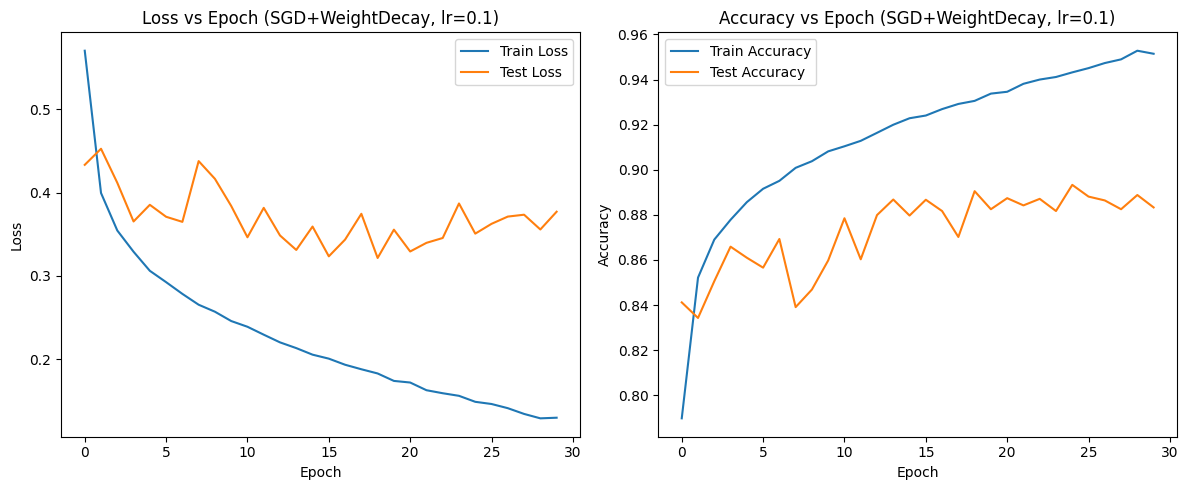

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


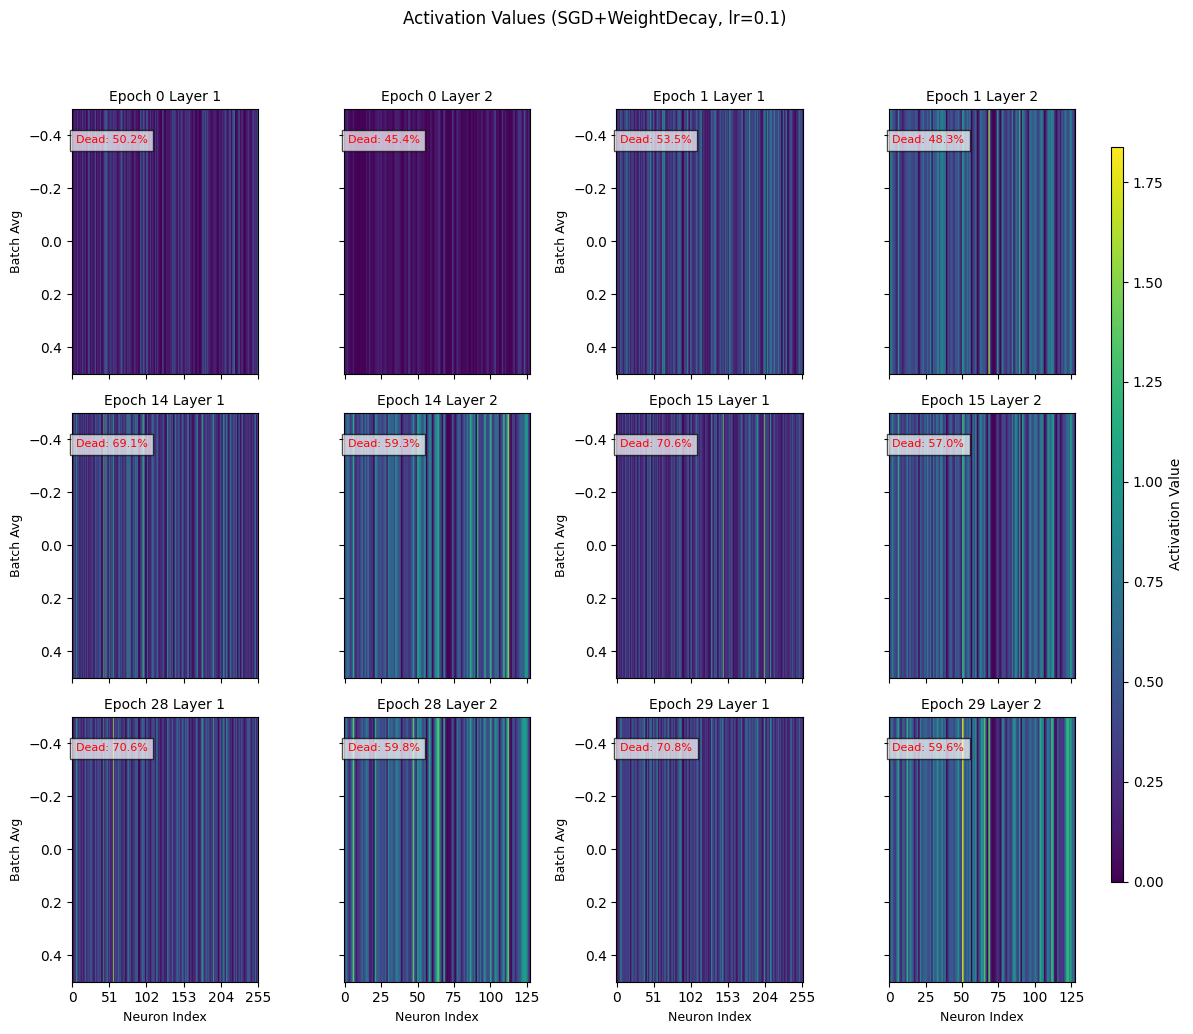

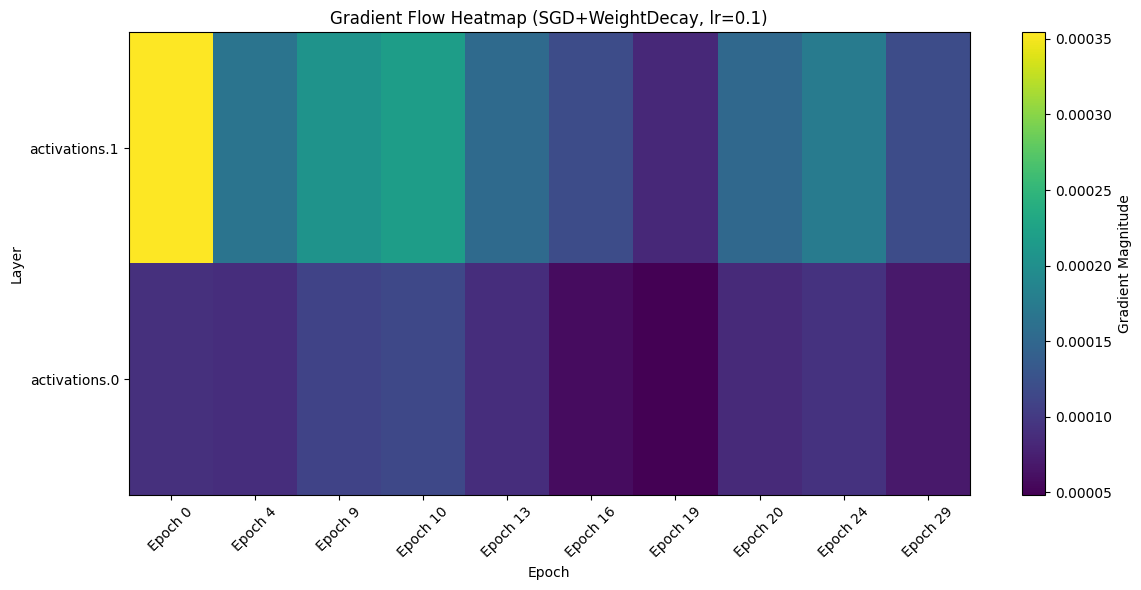


--- SGD + Weight Decay (lr=0.01, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.010000, Train Loss: 0.9775, Test Loss: 0.6222, Train Acc: 0.6868, Test Acc: 0.7716
Epoch [2/30], LR: 0.010000, Train Loss: 0.5521, Test Loss: 0.5401, Train Acc: 0.8012, Test Acc: 0.8019
Epoch [3/30], LR: 0.010000, Train Loss: 0.4850, Test Loss: 0.4906, Train Acc: 0.8264, Test Acc: 0.8230
Epoch [4/30], LR: 0.010000, Train Loss: 0.4513, Test Loss: 0.4677, Train Acc: 0.8392, Test Acc: 0.8323
Epoch [5/30], LR: 0.010000, Train Loss: 0.4284, Test Loss: 0.4528, Train Acc: 0.8476, Test Acc: 0.8352
Epoch [6/30], LR: 0.010000, Train Loss: 0.4107, Test Loss: 0.4415, Train Acc: 0.8545, Test Acc: 0.8399
Epoch [7/30], LR: 0.010000, Train Loss: 0.3956, Test Loss: 0.4233, Train Acc: 0.8590, Test Acc: 0.8467
Epoch [8/30], LR: 0.010000, Train Loss: 0.3826, Test Loss: 0.4128, Train Acc: 0.8632, Test Acc: 0.8509
Epoch [9/30], LR: 0.010000, Train Loss: 0.3721, Test Loss: 0.4045, Train Acc: 0.8675, Test Acc: 0.8535
Epoch [10/30]

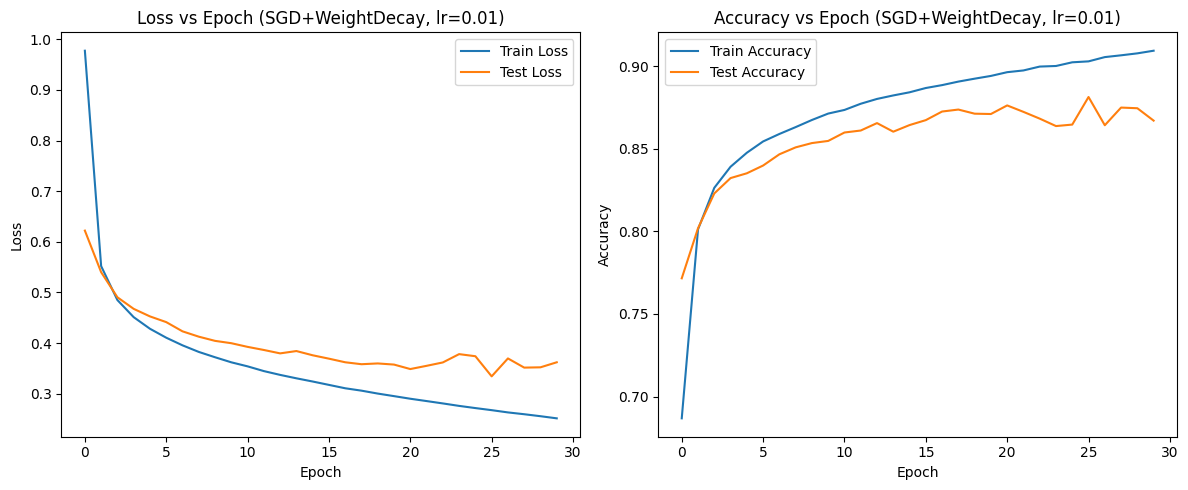

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


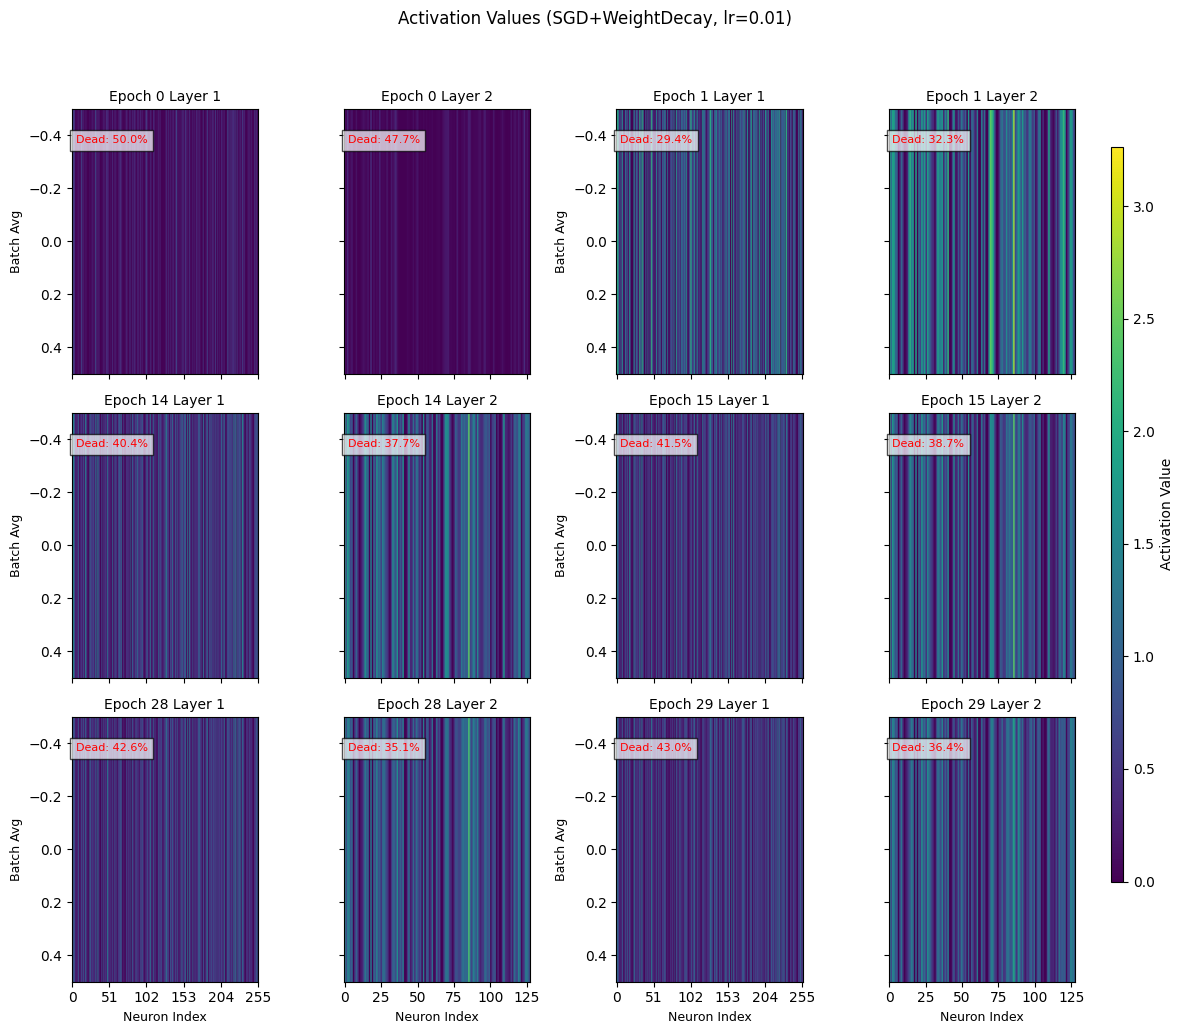

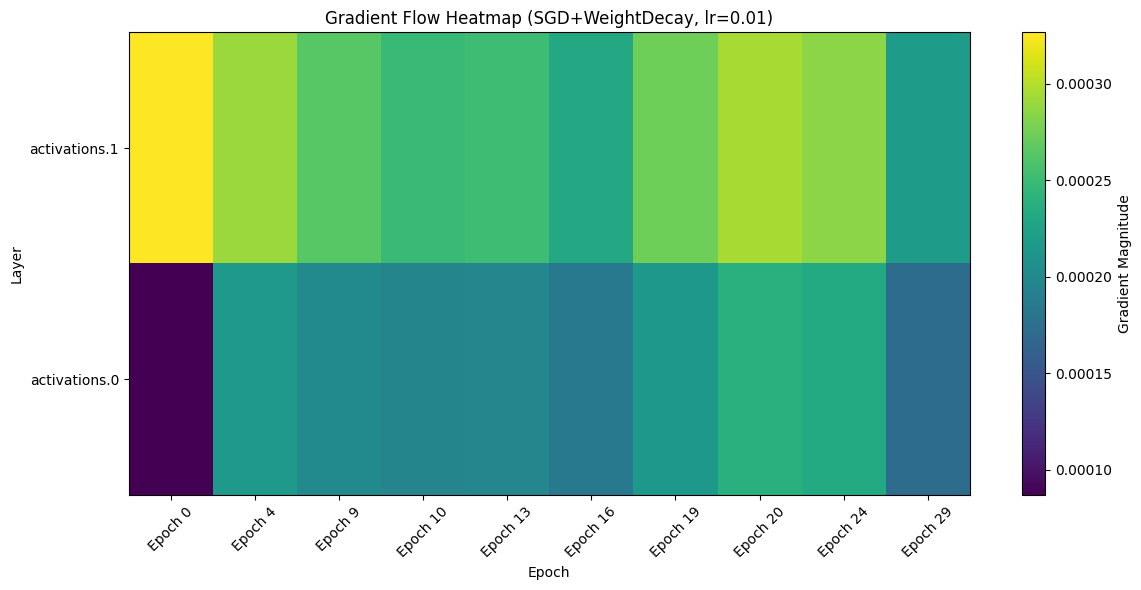


--- SGD + Weight Decay (lr=0.001, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.001000, Train Loss: 2.1299, Test Loss: 1.8801, Train Acc: 0.3953, Test Acc: 0.4870
Epoch [2/30], LR: 0.001000, Train Loss: 1.5580, Test Loss: 1.2887, Train Acc: 0.5695, Test Acc: 0.6578
Epoch [3/30], LR: 0.001000, Train Loss: 1.1127, Test Loss: 0.9882, Train Acc: 0.7003, Test Acc: 0.7123
Epoch [4/30], LR: 0.001000, Train Loss: 0.8971, Test Loss: 0.8408, Train Acc: 0.7290, Test Acc: 0.7314
Epoch [5/30], LR: 0.001000, Train Loss: 0.7848, Test Loss: 0.7587, Train Acc: 0.7433, Test Acc: 0.7409
Epoch [6/30], LR: 0.001000, Train Loss: 0.7189, Test Loss: 0.7081, Train Acc: 0.7526, Test Acc: 0.7529
Epoch [7/30], LR: 0.001000, Train Loss: 0.6760, Test Loss: 0.6745, Train Acc: 0.7615, Test Acc: 0.7578
Epoch [8/30], LR: 0.001000, Train Loss: 0.6448, Test Loss: 0.6481, Train Acc: 0.7709, Test Acc: 0.7648
Epoch [9/30], LR: 0.001000, Train Loss: 0.6203, Test Loss: 0.6266, Train Acc: 0.7785, Test Acc: 0.7718
Epoch [10/30

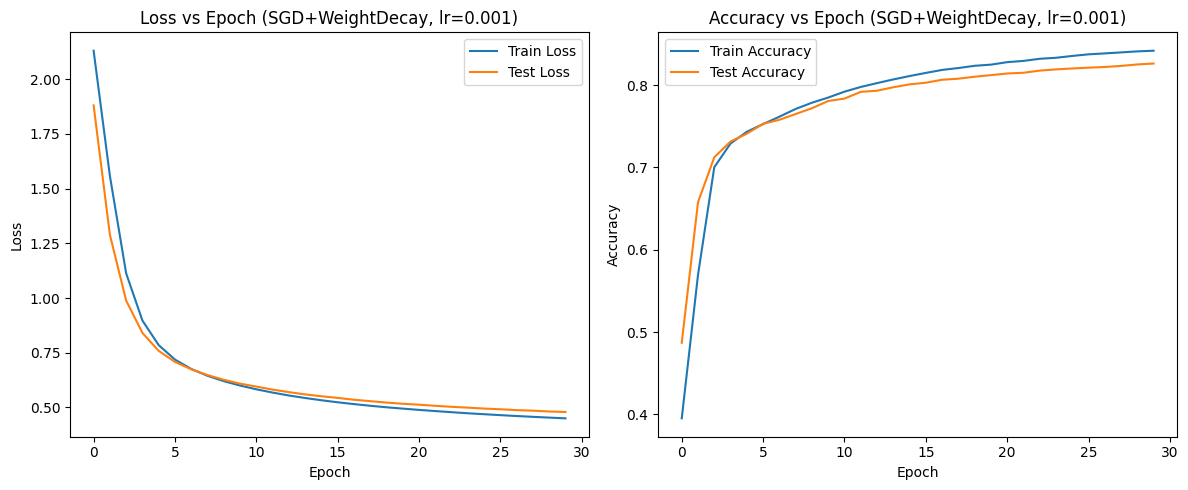

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


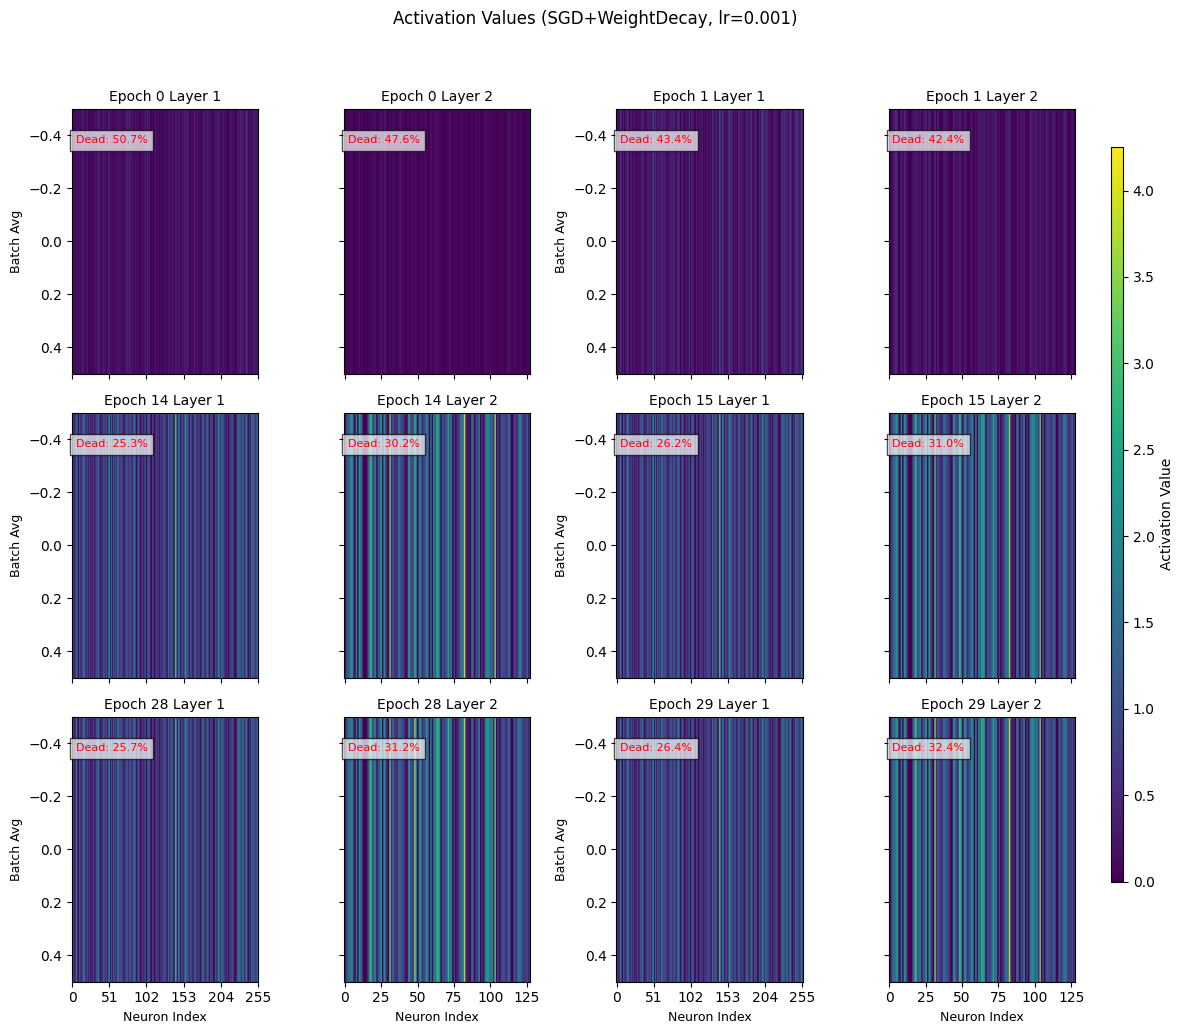

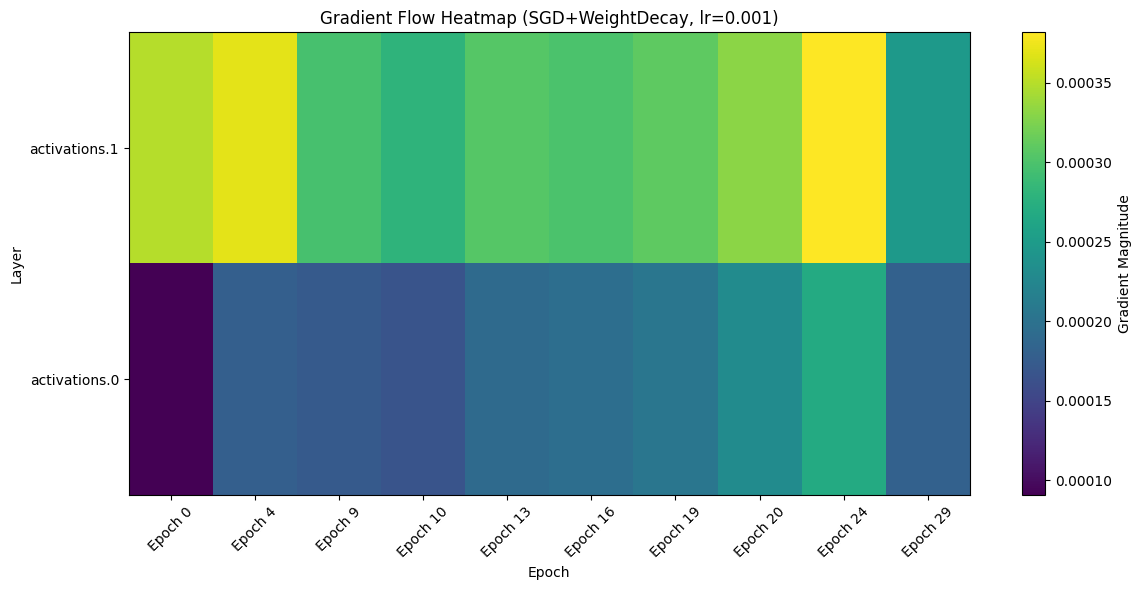


--- SGD+Momentum + Weight Decay 학습률 실험 ---


--- SGD+Momentum + Weight Decay (lr=0.1, momentum=0.9, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.100000, Train Loss: 0.6786, Test Loss: 0.6938, Train Acc: 0.7639, Test Acc: 0.7285
Epoch [2/30], LR: 0.100000, Train Loss: 0.5605, Test Loss: 0.5696, Train Acc: 0.8112, Test Acc: 0.8130
Epoch [3/30], LR: 0.100000, Train Loss: 0.5328, Test Loss: 0.5529, Train Acc: 0.8221, Test Acc: 0.8148
Epoch [4/30], LR: 0.100000, Train Loss: 0.5119, Test Loss: 0.5419, Train Acc: 0.8287, Test Acc: 0.8143
Epoch [5/30], LR: 0.100000, Train Loss: 0.4876, Test Loss: 0.5255, Train Acc: 0.8351, Test Acc: 0.8229
Epoch [6/30], LR: 0.100000, Train Loss: 0.4892, Test Loss: 0.6789, Train Acc: 0.8352, Test Acc: 0.7988
Epoch [7/30], LR: 0.100000, Train Loss: 0.4948, Test Loss: 0.5543, Train Acc: 0.8338, Test Acc: 0.8156
Epoch [8/30], LR: 0.100000, Train Loss: 0.4860, Test Loss: 0.5188, Train Acc: 0.8347, Test Acc: 0.8220
Epoch [9/30], LR: 0.100000, Train Loss: 0.4589, T

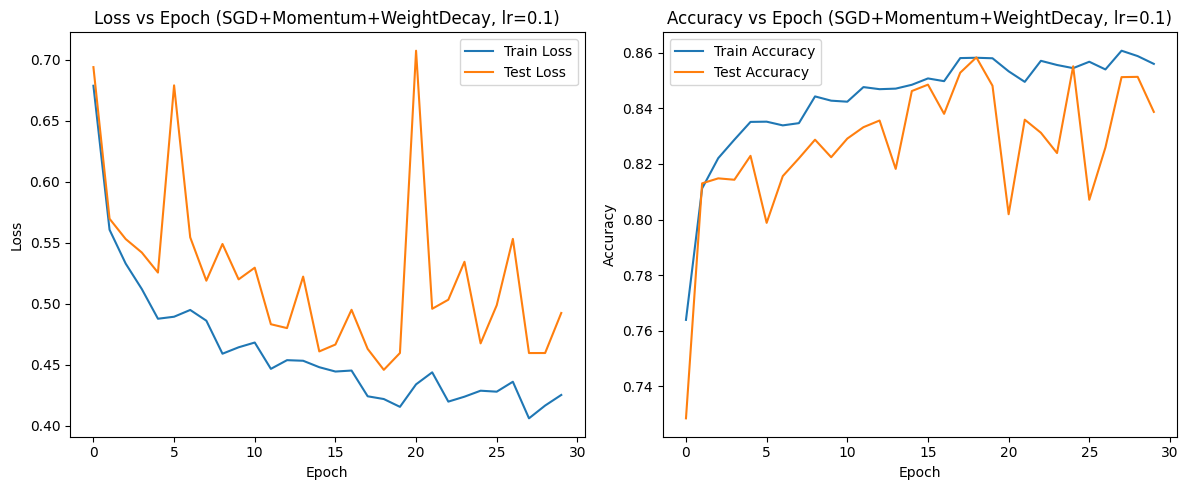

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


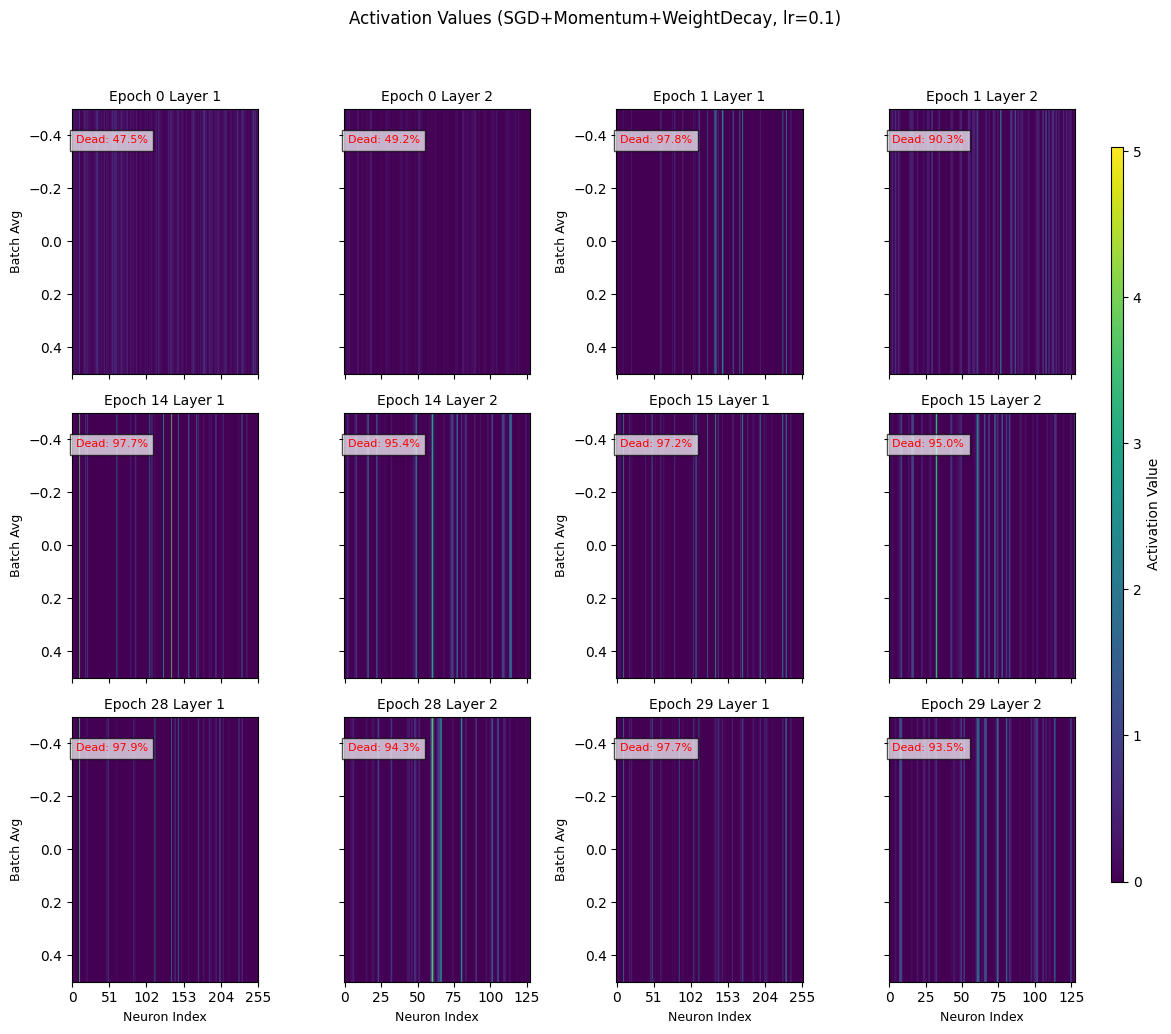

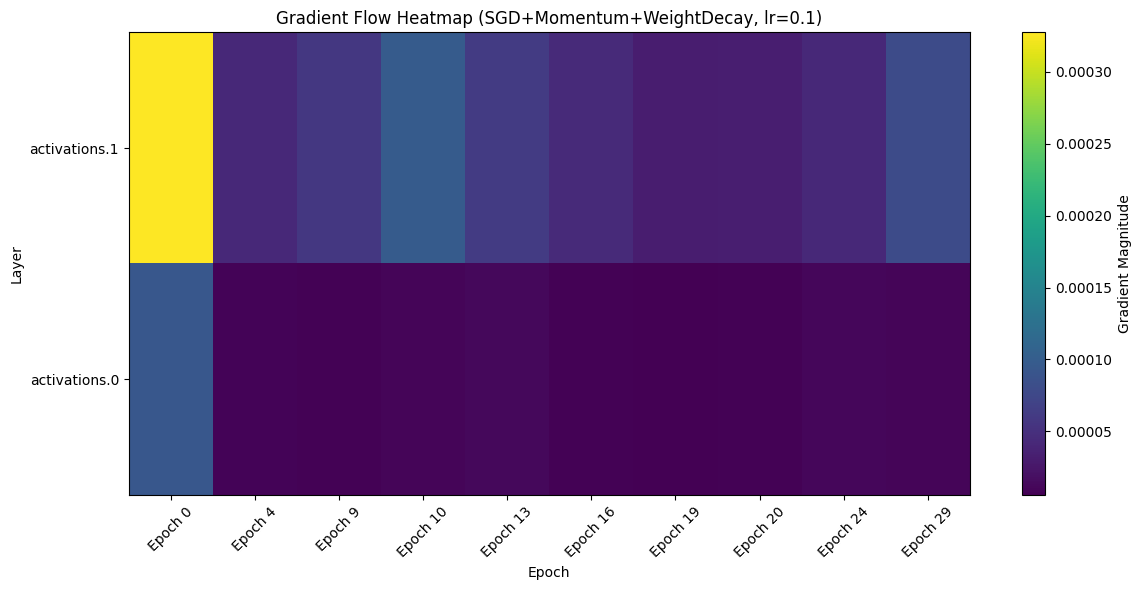


--- SGD+Momentum + Weight Decay (lr=0.01, momentum=0.9, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.010000, Train Loss: 0.5759, Test Loss: 0.4553, Train Acc: 0.7910, Test Acc: 0.8326
Epoch [2/30], LR: 0.010000, Train Loss: 0.3894, Test Loss: 0.3860, Train Acc: 0.8570, Test Acc: 0.8615
Epoch [3/30], LR: 0.010000, Train Loss: 0.3484, Test Loss: 0.3847, Train Acc: 0.8721, Test Acc: 0.8616
Epoch [4/30], LR: 0.010000, Train Loss: 0.3247, Test Loss: 0.3575, Train Acc: 0.8818, Test Acc: 0.8692
Epoch [5/30], LR: 0.010000, Train Loss: 0.3039, Test Loss: 0.3445, Train Acc: 0.8878, Test Acc: 0.8760
Epoch [6/30], LR: 0.010000, Train Loss: 0.2885, Test Loss: 0.3492, Train Acc: 0.8926, Test Acc: 0.8748
Epoch [7/30], LR: 0.010000, Train Loss: 0.2751, Test Loss: 0.3426, Train Acc: 0.8972, Test Acc: 0.8737
Epoch [8/30], LR: 0.010000, Train Loss: 0.2628, Test Loss: 0.3365, Train Acc: 0.9021, Test Acc: 0.8802
Epoch [9/30], LR: 0.010000, Train Loss: 0.2543, Test Loss: 0.3334, Train Acc: 0.9052, Test Ac

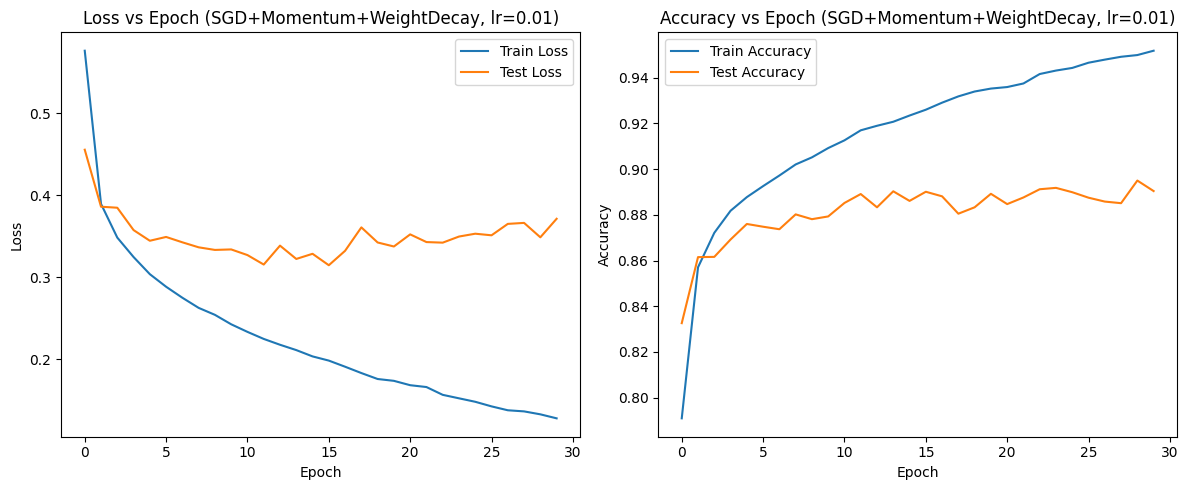

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


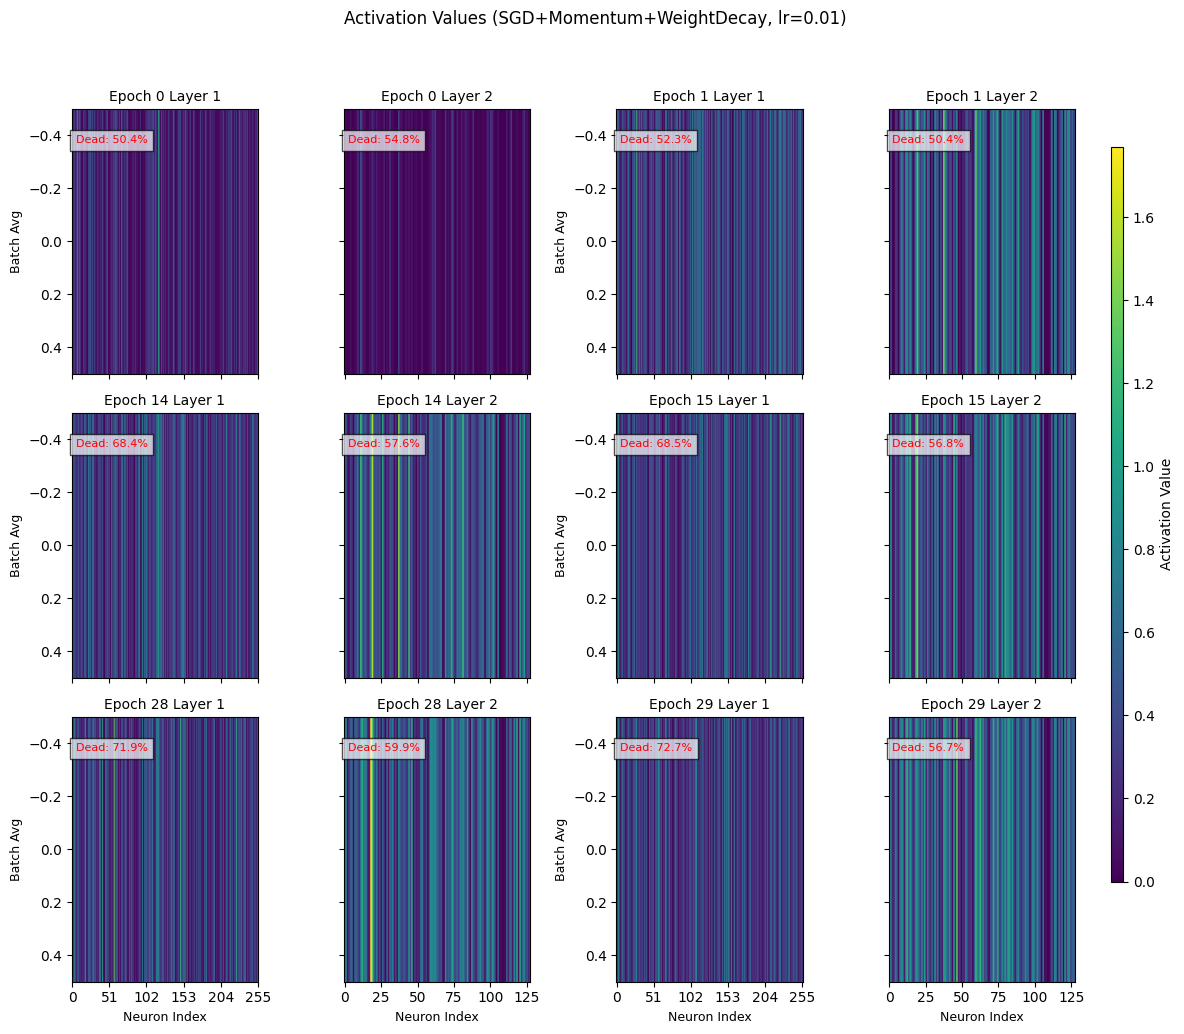

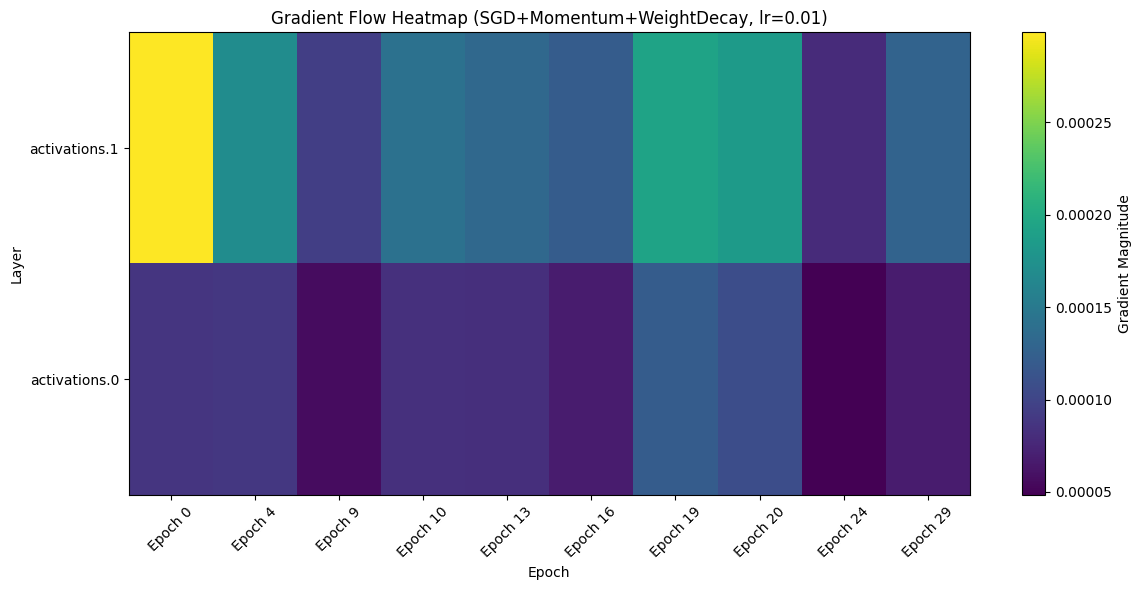


--- SGD+Momentum + Weight Decay (lr=0.001, momentum=0.9, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.001000, Train Loss: 1.0235, Test Loss: 0.6287, Train Acc: 0.6710, Test Acc: 0.7702
Epoch [2/30], LR: 0.001000, Train Loss: 0.5505, Test Loss: 0.5259, Train Acc: 0.8022, Test Acc: 0.8070
Epoch [3/30], LR: 0.001000, Train Loss: 0.4829, Test Loss: 0.4918, Train Acc: 0.8276, Test Acc: 0.8216
Epoch [4/30], LR: 0.001000, Train Loss: 0.4494, Test Loss: 0.4738, Train Acc: 0.8389, Test Acc: 0.8259
Epoch [5/30], LR: 0.001000, Train Loss: 0.4259, Test Loss: 0.4498, Train Acc: 0.8489, Test Acc: 0.8385
Epoch [6/30], LR: 0.001000, Train Loss: 0.4086, Test Loss: 0.4475, Train Acc: 0.8558, Test Acc: 0.8345
Epoch [7/30], LR: 0.001000, Train Loss: 0.3934, Test Loss: 0.4242, Train Acc: 0.8601, Test Acc: 0.8476
Epoch [8/30], LR: 0.001000, Train Loss: 0.3806, Test Loss: 0.4137, Train Acc: 0.8645, Test Acc: 0.8485
Epoch [9/30], LR: 0.001000, Train Loss: 0.3699, Test Loss: 0.4078, Train Acc: 0.8684, Test A

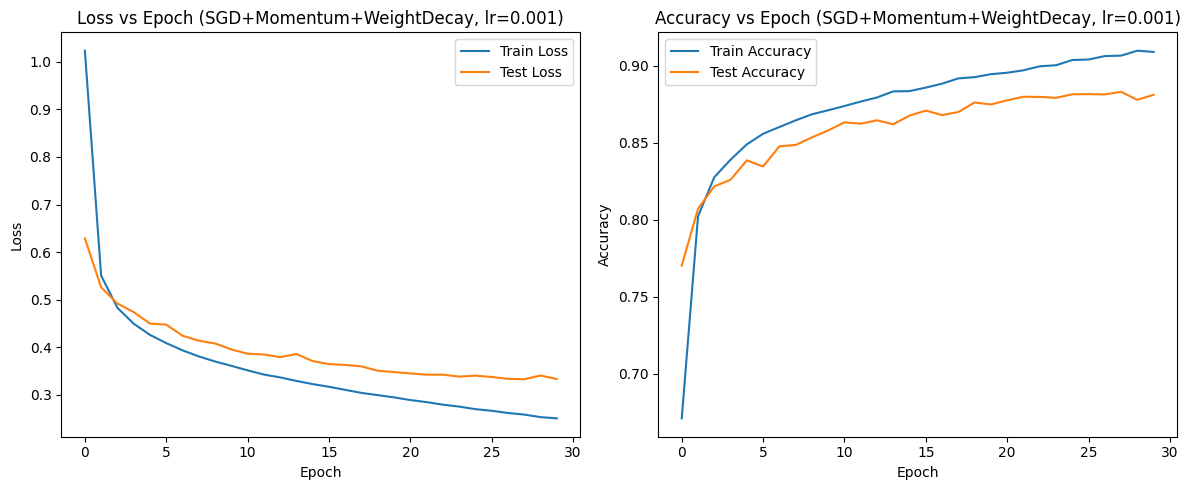

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


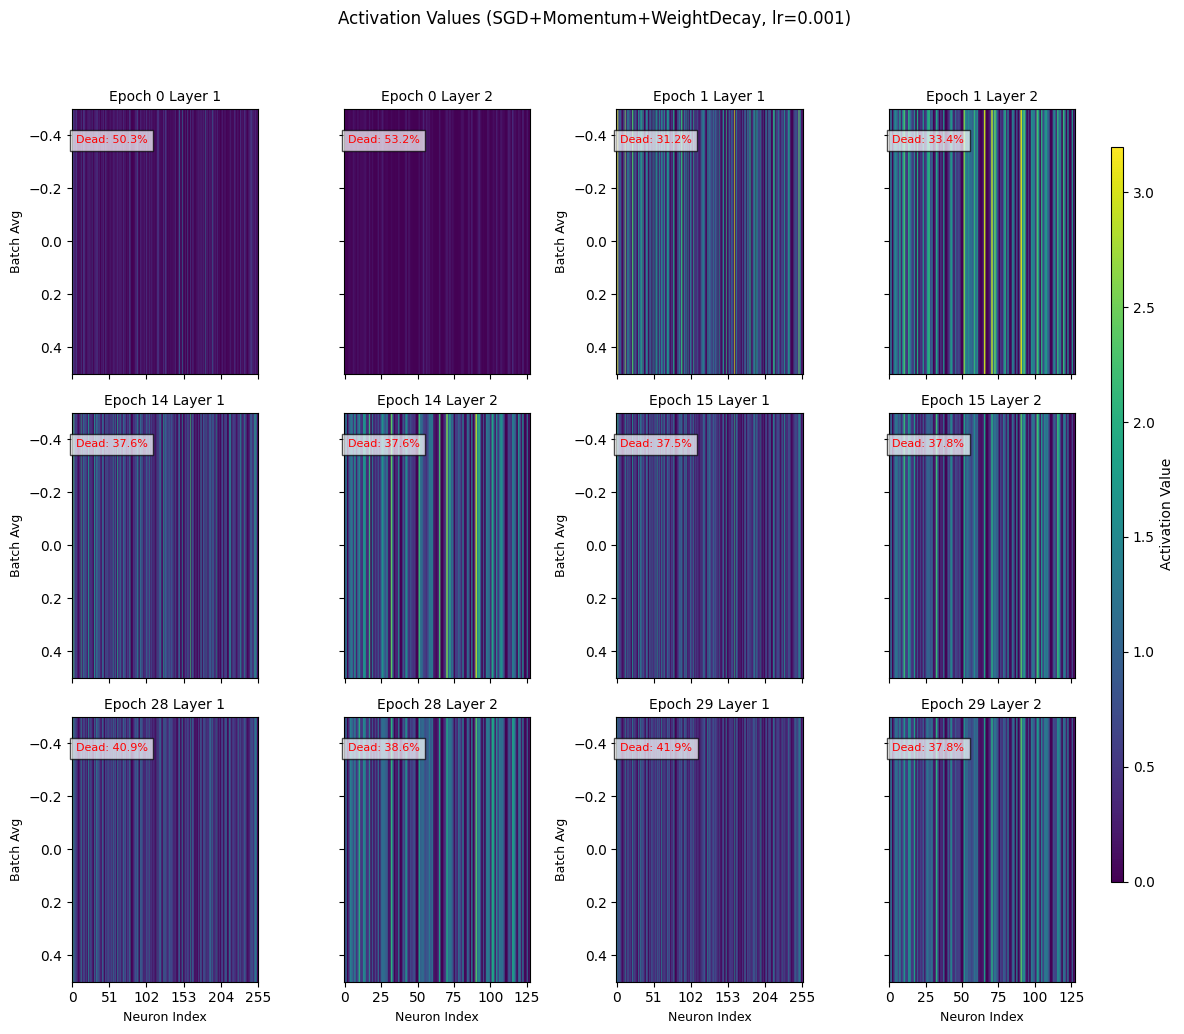

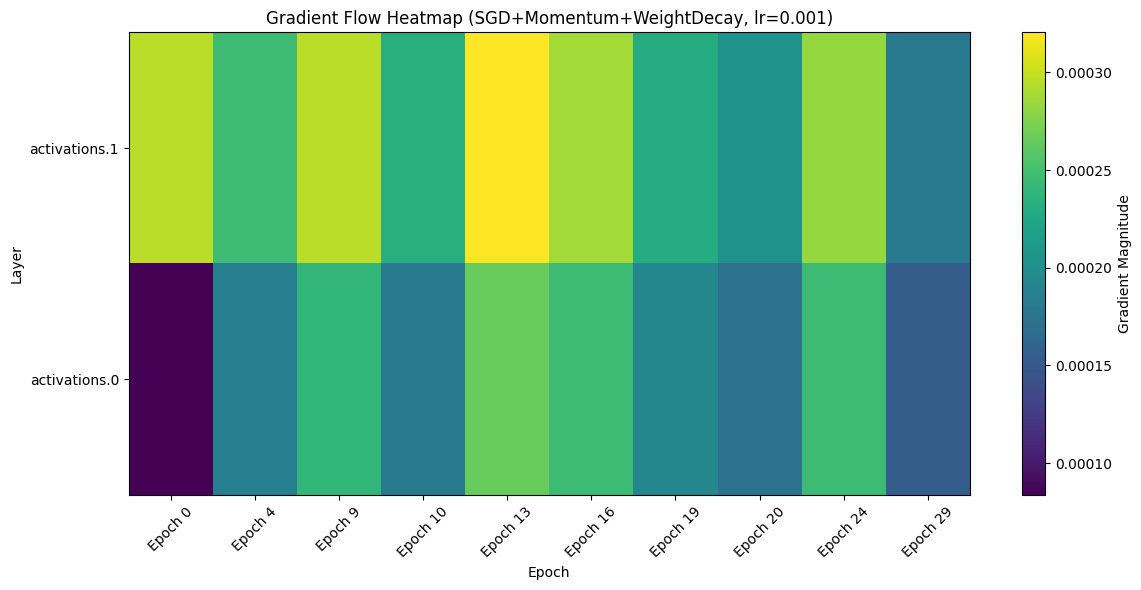


--- Adam + Weight Decay 학습률 실험 ---


--- Adam + Weight Decay (lr=0.1, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.100000, Train Loss: 4.9094, Test Loss: 2.2967, Train Acc: 0.1350, Test Acc: 0.1113
Epoch [2/30], LR: 0.100000, Train Loss: 2.3443, Test Loss: 2.3183, Train Acc: 0.1033, Test Acc: 0.1000
Epoch [3/30], LR: 0.100000, Train Loss: 2.3135, Test Loss: 2.3098, Train Acc: 0.0989, Test Acc: 0.1001
Epoch [4/30], LR: 0.100000, Train Loss: 2.3231, Test Loss: 2.3129, Train Acc: 0.1003, Test Acc: 0.1000
Epoch [5/30], LR: 0.100000, Train Loss: 2.3108, Test Loss: 2.3147, Train Acc: 0.0999, Test Acc: 0.1000
Epoch [6/30], LR: 0.100000, Train Loss: 2.3106, Test Loss: 2.3177, Train Acc: 0.0997, Test Acc: 0.1000
Epoch [7/30], LR: 0.100000, Train Loss: 6.3867, Test Loss: 3.2462, Train Acc: 0.0998, Test Acc: 0.1003
Epoch [8/30], LR: 0.100000, Train Loss: 2.7055, Test Loss: 2.3082, Train Acc: 0.0998, Test Acc: 0.1000
Epoch [9/30], LR: 0.100000, Train Loss: 2.5443, Test Loss: 2.3076, Train Acc: 0

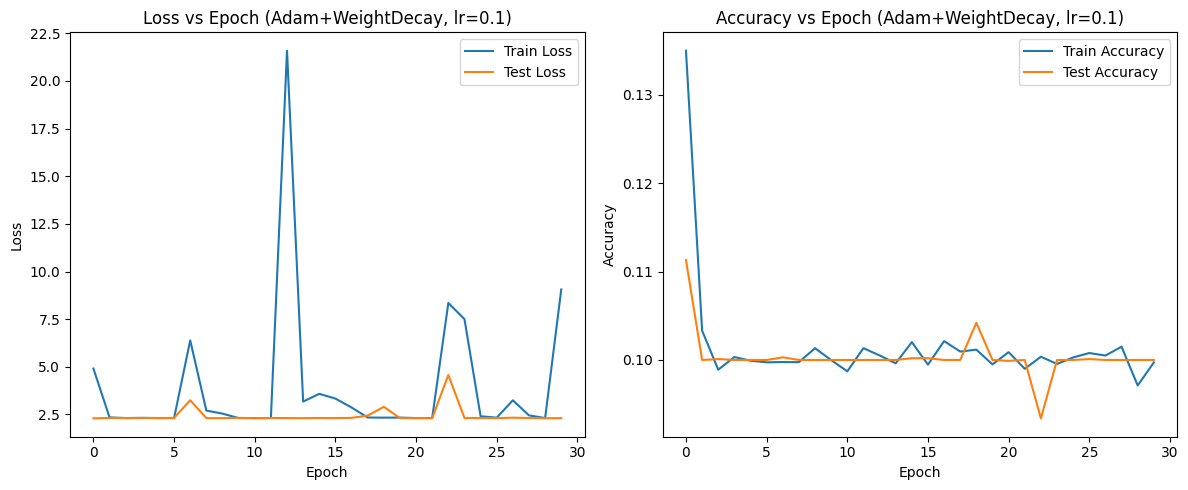

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


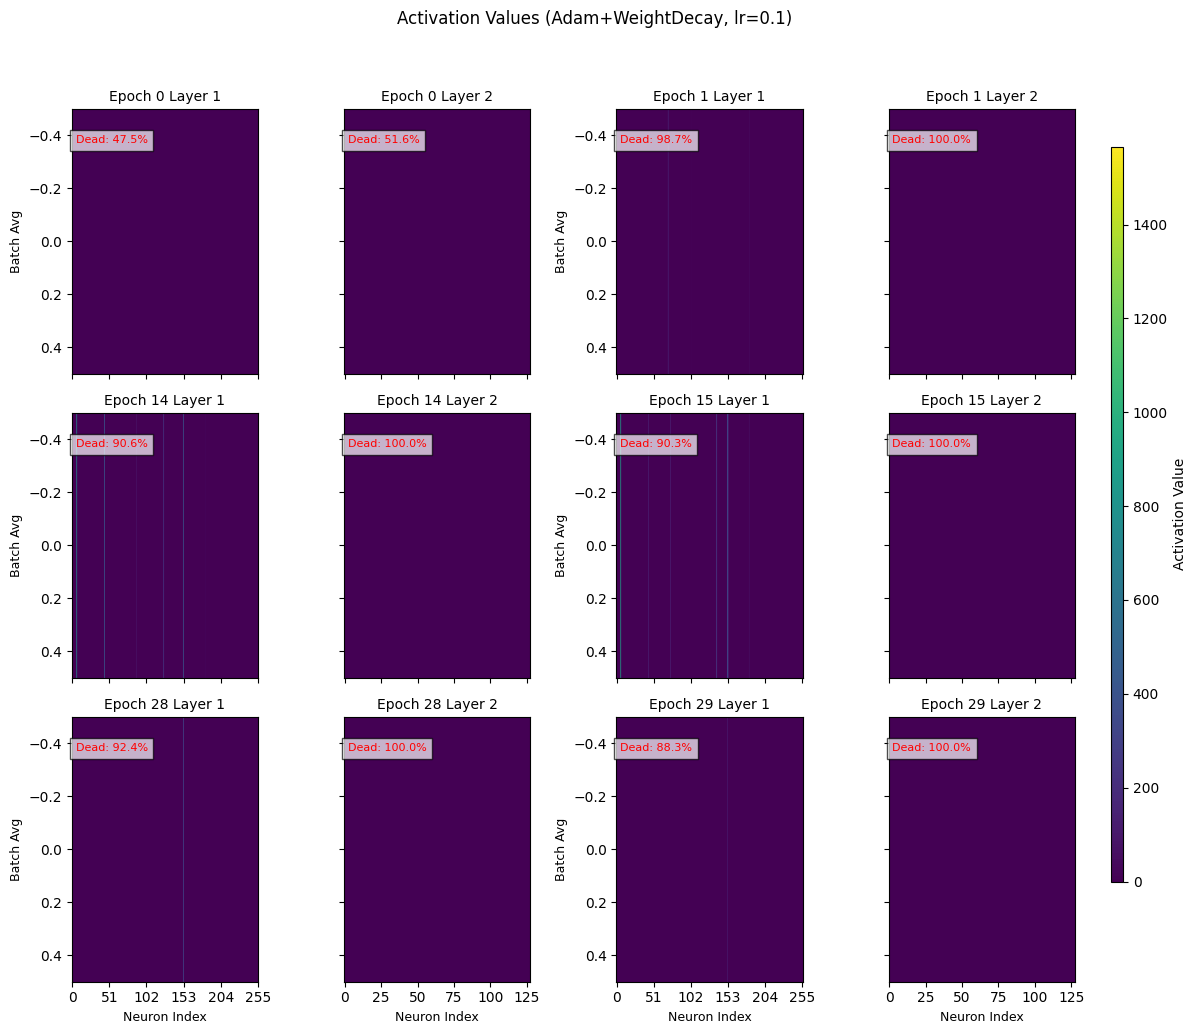

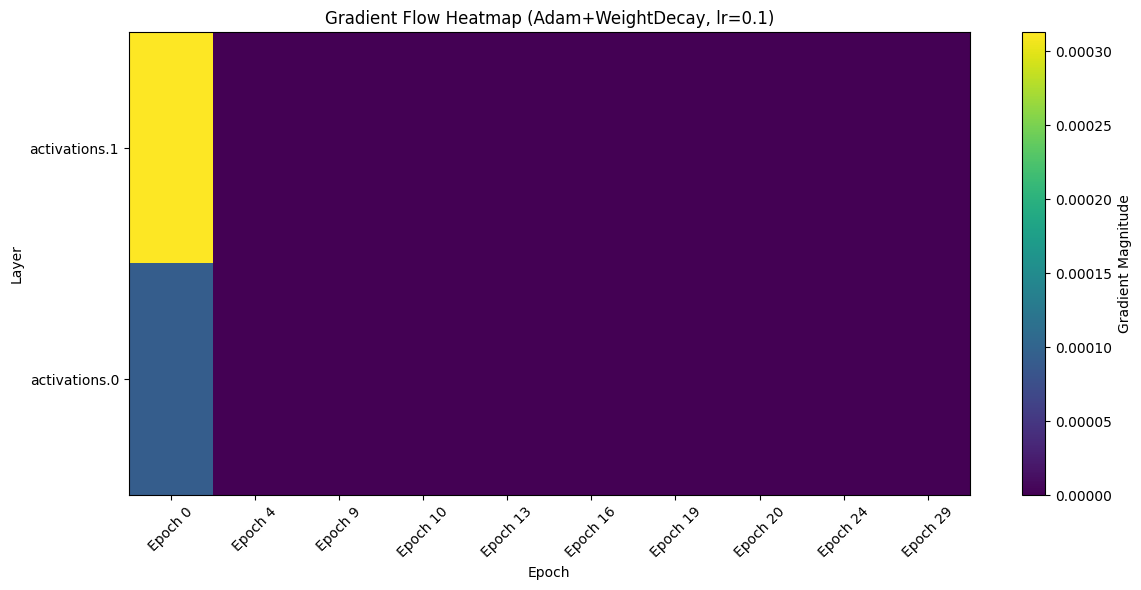


--- Adam + Weight Decay (lr=0.01, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.010000, Train Loss: 0.5534, Test Loss: 0.5289, Train Acc: 0.7991, Test Acc: 0.8166
Epoch [2/30], LR: 0.010000, Train Loss: 0.4745, Test Loss: 0.4989, Train Acc: 0.8295, Test Acc: 0.8154
Epoch [3/30], LR: 0.010000, Train Loss: 0.4439, Test Loss: 0.4765, Train Acc: 0.8398, Test Acc: 0.8349
Epoch [4/30], LR: 0.010000, Train Loss: 0.4454, Test Loss: 0.4990, Train Acc: 0.8414, Test Acc: 0.8217
Epoch [5/30], LR: 0.010000, Train Loss: 0.4305, Test Loss: 0.4493, Train Acc: 0.8455, Test Acc: 0.8357
Epoch [6/30], LR: 0.010000, Train Loss: 0.4364, Test Loss: 0.4739, Train Acc: 0.8440, Test Acc: 0.8315
Epoch [7/30], LR: 0.010000, Train Loss: 0.4259, Test Loss: 0.5504, Train Acc: 0.8485, Test Acc: 0.8141
Epoch [8/30], LR: 0.010000, Train Loss: 0.4324, Test Loss: 0.4687, Train Acc: 0.8458, Test Acc: 0.8403
Epoch [9/30], LR: 0.010000, Train Loss: 0.4328, Test Loss: 0.4657, Train Acc: 0.8473, Test Acc: 0.8390
Epoch [10/30

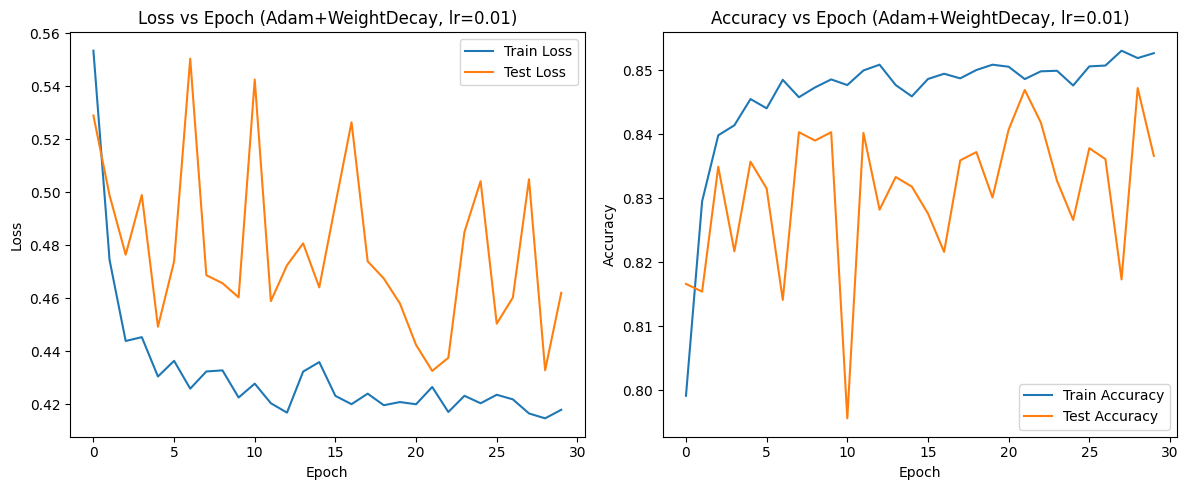

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


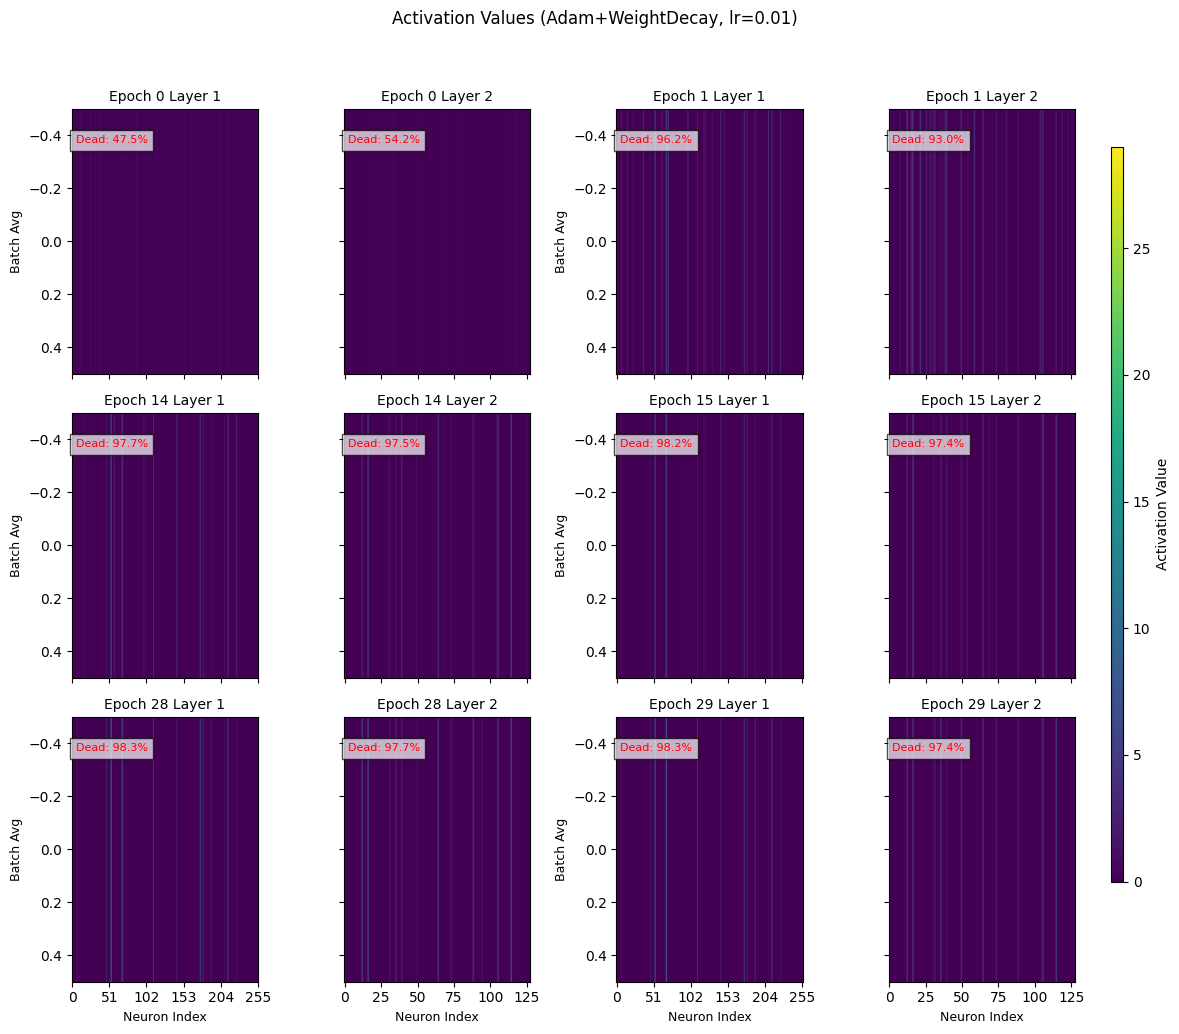

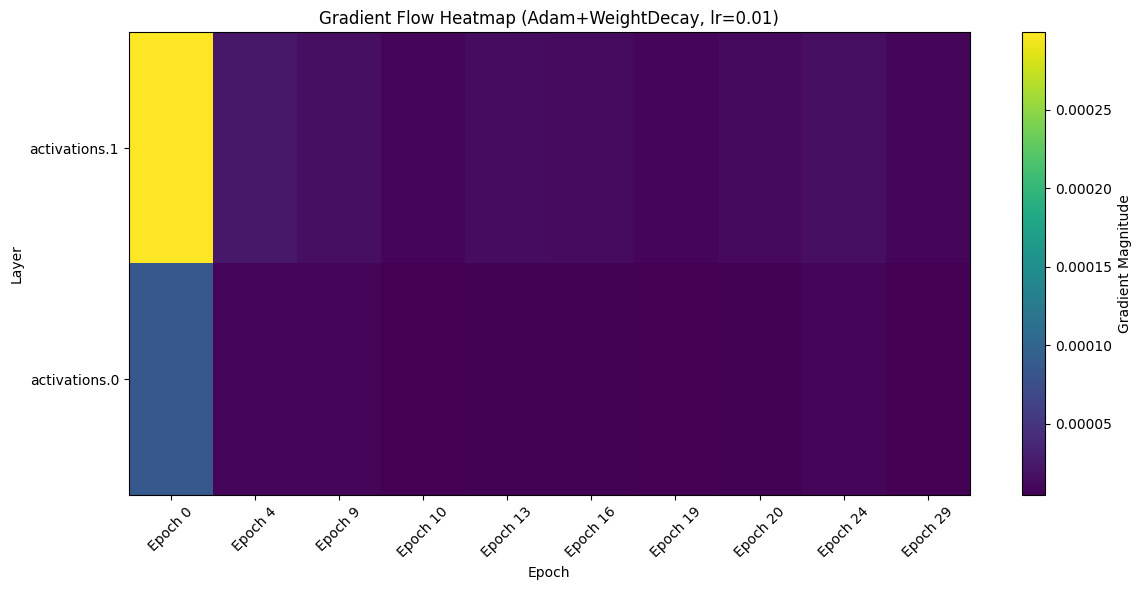


--- Adam + Weight Decay (lr=0.001, weight_decay=0.0001) ---

Epoch [1/30], LR: 0.001000, Train Loss: 0.4951, Test Loss: 0.4154, Train Acc: 0.8215, Test Acc: 0.8474
Epoch [2/30], LR: 0.001000, Train Loss: 0.3717, Test Loss: 0.3717, Train Acc: 0.8636, Test Acc: 0.8645
Epoch [3/30], LR: 0.001000, Train Loss: 0.3344, Test Loss: 0.3727, Train Acc: 0.8772, Test Acc: 0.8641
Epoch [4/30], LR: 0.001000, Train Loss: 0.3118, Test Loss: 0.3531, Train Acc: 0.8836, Test Acc: 0.8723
Epoch [5/30], LR: 0.001000, Train Loss: 0.2944, Test Loss: 0.3626, Train Acc: 0.8894, Test Acc: 0.8685
Epoch [6/30], LR: 0.001000, Train Loss: 0.2819, Test Loss: 0.3599, Train Acc: 0.8933, Test Acc: 0.8731
Epoch [7/30], LR: 0.001000, Train Loss: 0.2681, Test Loss: 0.3386, Train Acc: 0.8982, Test Acc: 0.8792
Epoch [8/30], LR: 0.001000, Train Loss: 0.2578, Test Loss: 0.3515, Train Acc: 0.9025, Test Acc: 0.8759
Epoch [9/30], LR: 0.001000, Train Loss: 0.2455, Test Loss: 0.3299, Train Acc: 0.9083, Test Acc: 0.8836
Epoch [10/3

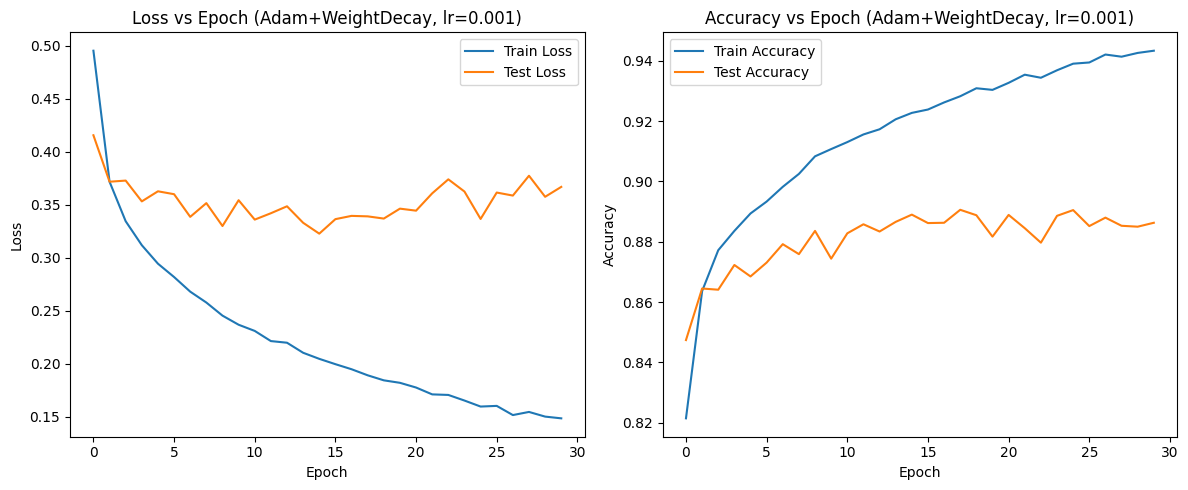

<ipython-input-3-8019a2fa2f94>:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


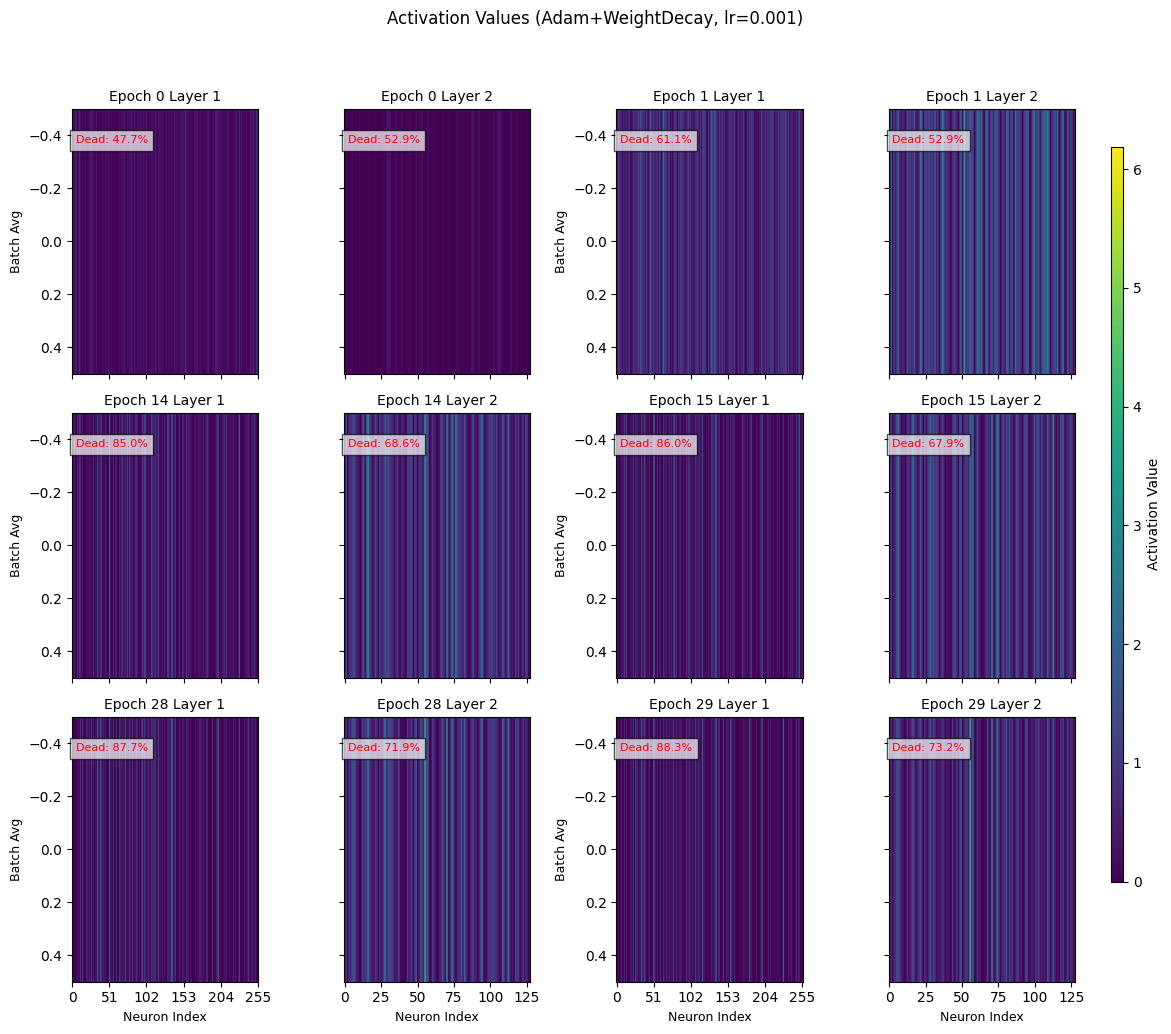

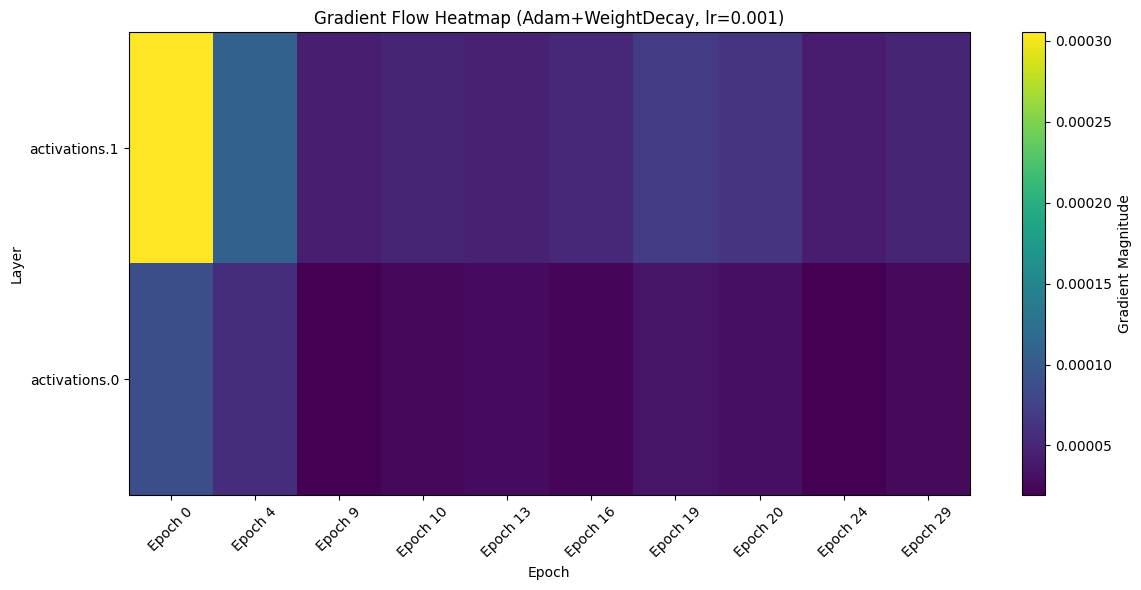

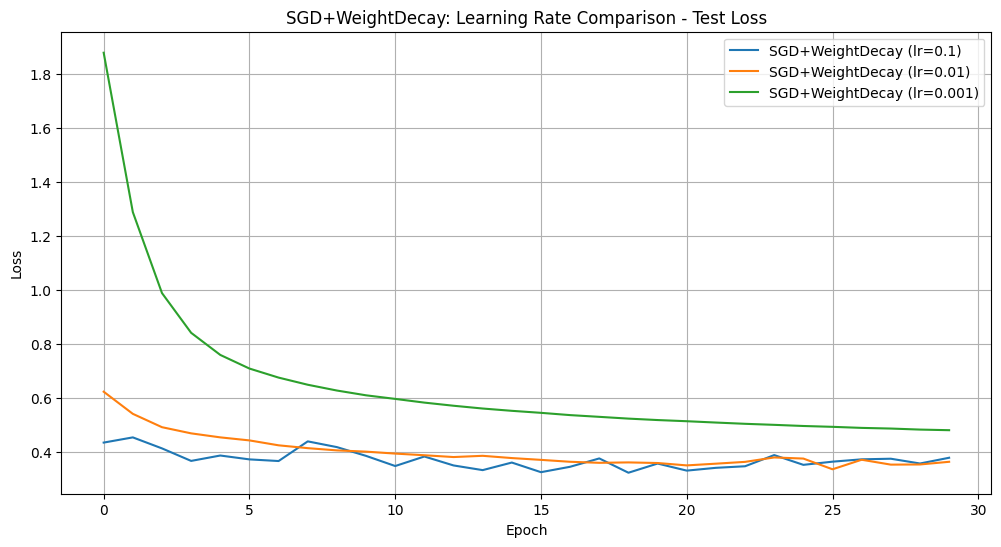

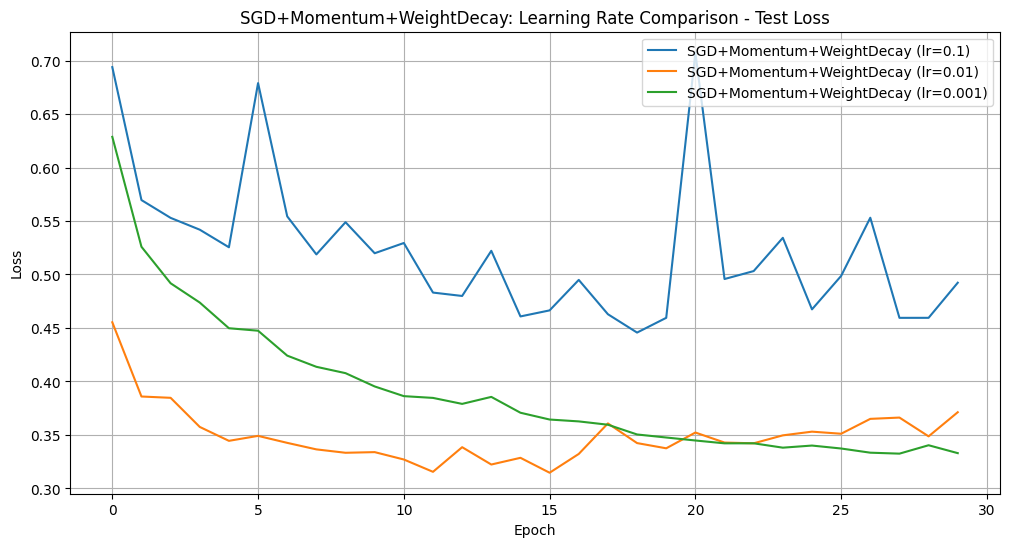

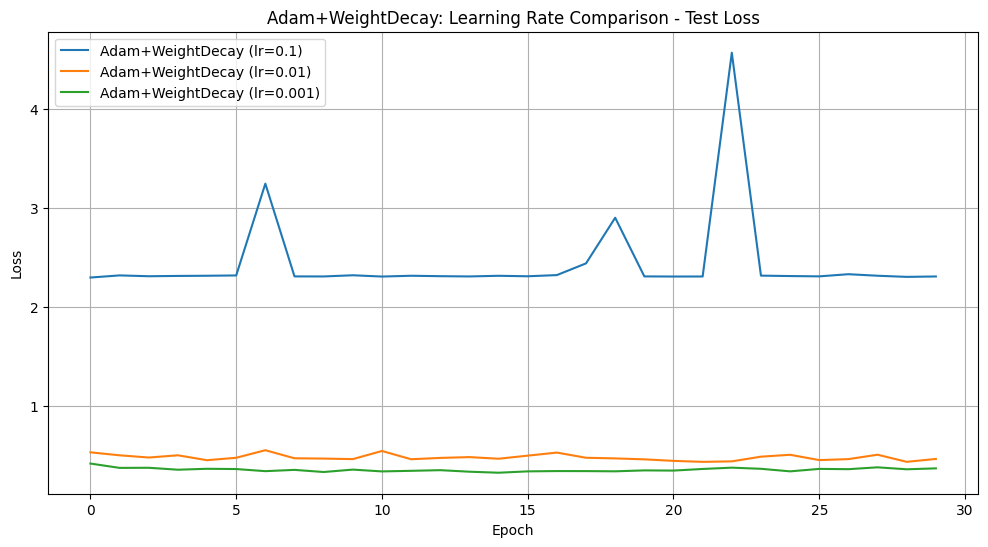

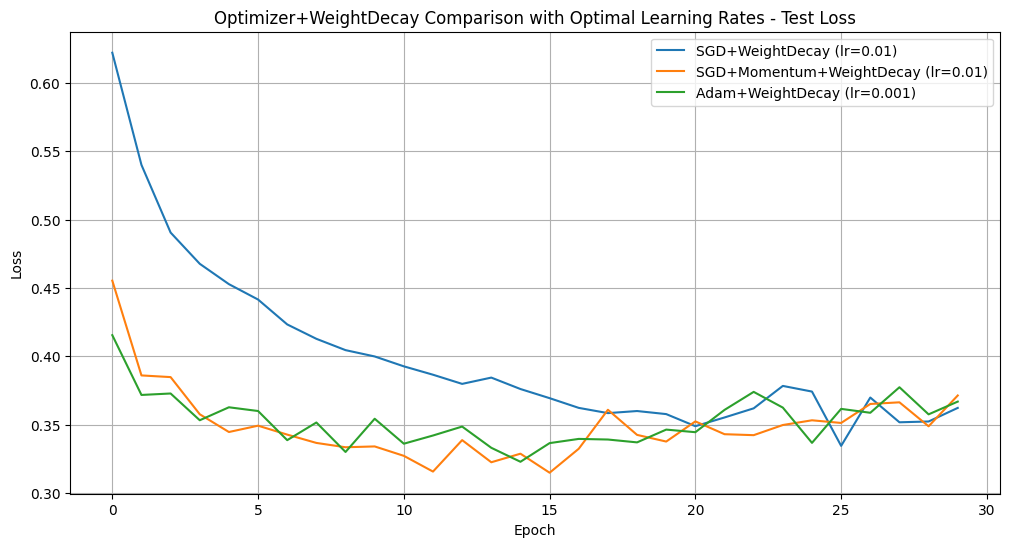

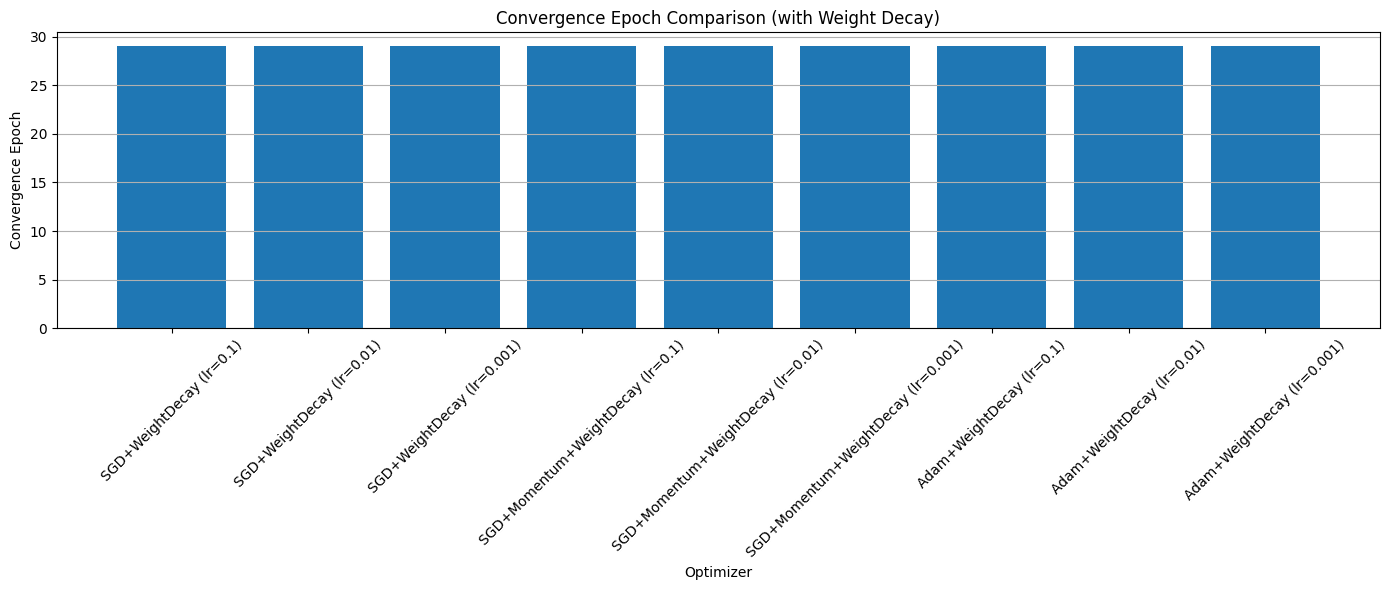


==== Weight Decay 적용 수렴 속도 비교 ====

SGD+WeightDecay (lr=0.1): 29 에폭에서 수렴
SGD+WeightDecay (lr=0.01): 29 에폭에서 수렴
SGD+WeightDecay (lr=0.001): 29 에폭에서 수렴
SGD+Momentum+WeightDecay (lr=0.1): 29 에폭에서 수렴
SGD+Momentum+WeightDecay (lr=0.01): 29 에폭에서 수렴
SGD+Momentum+WeightDecay (lr=0.001): 29 에폭에서 수렴
Adam+WeightDecay (lr=0.1): 29 에폭에서 수렴
Adam+WeightDecay (lr=0.01): 29 에폭에서 수렴
Adam+WeightDecay (lr=0.001): 29 에폭에서 수렴

Weight Decay 파라미터: 0.0001

실험 C (Weight Decay) 완료: 결과는 expC_weight_decay_results 디렉토리에 저장되었습니다.



In [ ]:
# 옵티마이저 실험용 모델 학습 함수
def train_model_optimizer(model, train_loader, test_loader, criterion, optimizer, lr_scheduler=None, num_epochs=30):
    """
    모델 학습 함수 - 옵티마이저 실험용
    """
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    lr_history = []  # 학습률 변화 기록

    # 활성화값과 그래디언트 훅 등록
    act_grad_hook = ActivationGradientHook()
    act_grad_hook.register_hooks(model)

    # 각 에폭별 활성화값과 그래디언트 저장용
    activation_history = {epoch: {} for epoch in range(num_epochs)}
    gradient_history = {epoch: {} for epoch in range(num_epochs)}
    dead_relu_history = {epoch: {} for epoch in range(num_epochs)}

    for epoch in range(num_epochs):
        # 현재 학습률 저장
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        # 학습
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, layer_outputs, activation_outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 자동 미분 사용
            optimizer.step()  # optimizer 업데이트

            train_loss += loss.item()  # loss 계산
            _, predicted = torch.max(outputs.data, 1)  # 최대값 인덱스 -> y^ (예측한 클래스)
            train_preds.extend(predicted.cpu().numpy())  # y^ -> numpy
            train_labels.extend(labels.cpu().numpy())  # y -> numpy

            # 활성화값, 그래디언트 저장. 메모리 한계와 미니 배치의 특성상 첫 번째 배치에서만 저장하도록 구성
            if batch_idx == 0:
                # 활성화값 저장
                for i, act in enumerate(activation_outputs):
                    activation_history[epoch][f'layer_{i+1}'] = act.detach().cpu().numpy()
                    # Dead ReLU 계산, 0인 비율을 계산하면 됨
                    dead_relu_history[epoch][f'layer_{i+1}'] = (act == 0).float().mean().item()

                # 그래디언트
                for name, gradient in act_grad_hook.gradients.items():
                    gradient_history[epoch][name] = gradient.numpy()

                # 메모리 정리용
                act_grad_hook.clear()

        # model.eval 사용
        model.eval()
        test_loss = 0
        test_preds = []
        test_labels = []

        with torch.no_grad():  # gradient 계산 X
            for inputs, labels in test_loader:  # 테스트 데이터 로드
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _, _ = model(inputs)  # 예측값 계산
                loss = criterion(outputs, labels)  # loss 계산
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)  # 예측 결과
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # 결과 계산
        train_loss = train_loss / len(train_loader)
        test_loss = test_loss / len(test_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        test_acc = accuracy_score(test_labels, test_preds)

        # 결과 저장
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'LR: {current_lr:.6f}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Test Acc: {test_acc:.4f}')

        # 학습률 스케줄러 업데이트
        if lr_scheduler is not None:
            lr_scheduler.step()

    # 훅 제거
    act_grad_hook.remove_hooks()

    return train_losses, test_losses, train_accs, test_accs, activation_history, gradient_history, dead_relu_history, lr_history


# 실험 C 함수: 최적화 알고리즘 비교 (Weight Decay 적용)
def run_experiment_C_with_weight_decay():
    print("\n===== 실험 C: 최적화 알고리즘 비교 with Weight Decay (SGD, SGD+Momentum, Adam) =====\n")

    # 결과 저장 디렉토리 생성
    if not os.path.exists("expC_weight_decay_results"):
        os.makedirs("expC_weight_decay_results")

    # 학습 에폭 수 설정
    num_epochs = 30

    # 손실 함수 설정 (CrossEntropy 사용)
    loss_fn = nn.CrossEntropyLoss()

    # 학습률 설정
    learning_rates = [0.1, 0.01, 0.001]

    # Weight Decay 설정
    weight_decay = 1e-4  # 0.0001

    # 결과 저장 딕셔너리
    sgd_results = {}
    momentum_results = {}
    adam_results = {}

    # 1. SGD + Weight Decay 학습률 실험 (3개)
    print("\n--- SGD + Weight Decay 학습률 실험 ---\n")

    for lr in learning_rates:
        print(f"\n--- SGD + Weight Decay (lr={lr}, weight_decay={weight_decay}) ---\n")
        model = MLP().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

        results = train_model_optimizer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=loss_fn,
            optimizer=optimizer,
            num_epochs=num_epochs
        )

        sgd_results[lr] = results

        # 개별 결과 시각화
        plot_learning_curves(
            results[0], results[1], results[2], results[3],
            title_suffix=f"(SGD+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/SGD_WeightDecay_lr_{lr}"
        )
        # 활성화값과 그래디언트 히트맵 시각화
        plot_activation_heatmap(
            results[4],
            title_suffix=f"(SGD+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/SGD_WeightDecay_lr_{lr}"
        )

        plot_gradient_flow_heatmap(
            results[5],
            title_suffix=f"(SGD+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/SGD_WeightDecay_lr_{lr}"
        )

    # 2. SGD+Momentum + Weight Decay 학습률 실험 (3개)
    print("\n--- SGD+Momentum + Weight Decay 학습률 실험 ---\n")

    for lr in learning_rates:
        print(f"\n--- SGD+Momentum + Weight Decay (lr={lr}, momentum=0.9, weight_decay={weight_decay}) ---\n")
        model = MLP().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

        results = train_model_optimizer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=loss_fn,
            optimizer=optimizer,
            num_epochs=num_epochs
        )

        momentum_results[lr] = results

        # 개별 결과 시각화
        plot_learning_curves(
            results[0], results[1], results[2], results[3],
            title_suffix=f"(SGD+Momentum+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/SGD_Momentum_WeightDecay_lr_{lr}"
        )
        # 활성화값과 그래디언트 히트맵 시각화
        plot_activation_heatmap(
            results[4],
            title_suffix=f"(SGD+Momentum+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/SGD_Momentum_WeightDecay_lr_{lr}"
        )

        plot_gradient_flow_heatmap(
            results[5],
            title_suffix=f"(SGD+Momentum+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/SGD_Momentum_WeightDecay_lr_{lr}"
        )

    # 3. Adam + Weight Decay 학습률 실험 (3개)
    print("\n--- Adam + Weight Decay 학습률 실험 ---\n")

    for lr in learning_rates:
        print(f"\n--- Adam + Weight Decay (lr={lr}, weight_decay={weight_decay}) ---\n")
        model = MLP().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        results = train_model_optimizer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=loss_fn,
            optimizer=optimizer,
            num_epochs=num_epochs
        )

        adam_results[lr] = results

        # 개별 결과 시각화
        plot_learning_curves(
            results[0], results[1], results[2], results[3],
            title_suffix=f"(Adam+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/Adam_WeightDecay_lr_{lr}"
        )
        # 활성화값과 그래디언트 히트맵 시각화
        plot_activation_heatmap(
            results[4],
            title_suffix=f"(Adam+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/Adam_WeightDecay_lr_{lr}"
        )

        plot_gradient_flow_heatmap(
            results[5],
            title_suffix=f"(Adam+WeightDecay, lr={lr})",
            save_dir=f"expC_weight_decay_results/Adam_WeightDecay_lr_{lr}"
        )

    # 각 최적화 알고리즘별 학습률에 따른 수렴 속도 비교 시각화

    # 1. SGD+WeightDecay 학습률 비교
    plt.figure(figsize=(12, 6))
    for lr in learning_rates:
        plt.plot(sgd_results[lr][1], label=f'SGD+WeightDecay (lr={lr})')
    plt.title('SGD+WeightDecay: Learning Rate Comparison - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_weight_decay_results/SGD_WeightDecay_lr_comparison_loss.png")
    plt.show()

    # 2. SGD+Momentum+WeightDecay 학습률 비교
    plt.figure(figsize=(12, 6))
    for lr in learning_rates:
        plt.plot(momentum_results[lr][1], label=f'SGD+Momentum+WeightDecay (lr={lr})')
    plt.title('SGD+Momentum+WeightDecay: Learning Rate Comparison - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_weight_decay_results/SGD_Momentum_WeightDecay_lr_comparison_loss.png")
    plt.show()

    # 3. Adam+WeightDecay 학습률 비교
    plt.figure(figsize=(12, 6))
    for lr in learning_rates:
        plt.plot(adam_results[lr][1], label=f'Adam+WeightDecay (lr={lr})')
    plt.title('Adam+WeightDecay: Learning Rate Comparison - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_weight_decay_results/Adam_WeightDecay_lr_comparison_loss.png")
    plt.show()

    # 최적 학습률에서의 옵티마이저 비교
    plt.figure(figsize=(12, 6))
    plt.plot(sgd_results[0.01][1], label='SGD+WeightDecay (lr=0.01)')
    plt.plot(momentum_results[0.01][1], label='SGD+Momentum+WeightDecay (lr=0.01)')
    plt.plot(adam_results[0.001][1], label='Adam+WeightDecay (lr=0.001)')
    plt.title('Optimizer+WeightDecay Comparison with Optimal Learning Rates - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("expC_weight_decay_results/optimizer_WeightDecay_comparison_optimal_lr.png")
    plt.show()

    # 수렴 속도 분석
    convergence_epochs = {}

    # SGD+WeightDecay 수렴 에폭
    for lr in learning_rates:
        convergence_epochs[f'SGD+WeightDecay (lr={lr})'] = detect_convergence(sgd_results[lr][1])

    # SGD+Momentum+WeightDecay 수렴 에폭
    for lr in learning_rates:
        convergence_epochs[f'SGD+Momentum+WeightDecay (lr={lr})'] = detect_convergence(momentum_results[lr][1])

    # Adam+WeightDecay 수렴 에폭
    for lr in learning_rates:
        convergence_epochs[f'Adam+WeightDecay (lr={lr})'] = detect_convergence(adam_results[lr][1])

    # 수렴 에폭 비교 시각화
    plt.figure(figsize=(14, 6))
    plt.bar(convergence_epochs.keys(), convergence_epochs.values())
    plt.title('Convergence Epoch Comparison (with Weight Decay)')
    plt.xlabel('Optimizer')
    plt.ylabel('Convergence Epoch')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig("expC_weight_decay_results/convergence_epoch_comparison_with_weight_decay.png")
    plt.show()

    # 결과 요약 출력
    print("\n==== Weight Decay 적용 수렴 속도 비교 ====\n")
    for opt, epoch in convergence_epochs.items():
        print(f"{opt}: {epoch} 에폭에서 수렴")

    print(f"\nWeight Decay 파라미터: {weight_decay}")

    print("\n실험 C (Weight Decay) 완료: 결과는 expC_weight_decay_results 디렉토리에 저장되었습니다.\n")

    return sgd_results, momentum_results, adam_results

# 메인 실행 코드
if __name__ == "__main__":
    # Weight Decay 실험 실행
    results = run_experiment_C_with_weight_decay()